# 👁️ Dual-Stream Age-Aware Iris Stress Detection Model
## 🔥 Training Notebook: Pupil Dilation + Tension Rings with Age Features

### 🎯 Objective
Train an advanced deep learning model to detect stress by analyzing **THREE key indicators**:
1. **Pupil Dilation** (Primary) - Sympathetic nervous system activation
2. **Iris Tension Rings** (Secondary) - Structural stress markers
3. **Age Features** (Contextual) - Age-normalized stress detection

### 📊 Dataset Overview
- **Pupil Stream**: 2,504 images with age information (8 age groups)
- **Iris Stream**: 1,063 images with tension ring annotations
- **Strategy**: Separate training on each stream, dual-stream inference

### 🚀 Architecture Highlights
- ✅ **Dual-Stream CNN**: Separate processing for pupil and iris features
- ✅ **Age-Aware Fusion**: Age features integrated for better stress detection
- ✅ **Learnable Weighted Fusion**: Adaptive α parameter learns optimal stream combination
- ✅ **Production-Ready**: All training stability fixes applied (focal loss, warmup, gradient clipping)

**Date**: November 10, 2025  
**Environment**: Local/Kaggle  
**Framework**: TensorFlow 2.x + Keras 3.x

---

## 📦 Section 1: Environment Setup & Configuration

Complete setup with all imports, GPU configuration, and hyperparameters.

In [1]:
# ============================================================================
# KAGGLE FIX: Protobuf Compatibility
# ============================================================================
# Fix for "AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'"
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# Reduce TensorFlow verbosity (suppress INFO logs from distributed training)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=filter INFO, 2=filter WARNING, 3=filter ERROR

print("✅ Protobuf compatibility fix applied for Kaggle environment")
print("✅ TensorFlow logging verbosity reduced")
# ============================================================================
# SECTION 1.1: IMPORTS AND ENVIRONMENT SETUP
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import gc
from pathlib import Path
from collections import Counter
from tqdm.auto import tqdm
from PIL import Image
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Suppress TensorFlow INFO and WARNING logs
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')

# Also suppress absl logging (used by TensorFlow) - with error handling
try:
    import absl.logging
    absl.logging.set_verbosity(absl.logging.ERROR)
except (ImportError, AttributeError):
    pass  # absl not available or no set_verbosity method

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_curve, auc, accuracy_score, precision_recall_curve,
                              roc_auc_score)
from sklearn.utils.class_weight import compute_class_weight

# Statistical testing
from scipy import stats
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.signal import find_peaks

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("🚀 DUAL-STREAM AGE-AWARE IRIS STRESS DETECTION")
print("="*80)
print(f"\n📚 Library Versions:")
print(f"   TensorFlow: {tf.__version__}")
print(f"   Keras: {keras.__version__}")
print(f"   OpenCV: {cv2.__version__}")
print(f"   NumPy: {np.__version__}")
print(f"   Pandas: {pd.__version__}")

✅ Protobuf compatibility fix applied for Kaggle environment
✅ TensorFlow logging verbosity reduced


2025-11-11 20:30:53.408783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762893053.433049     328 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762893053.440262     328 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🚀 DUAL-STREAM AGE-AWARE IRIS STRESS DETECTION

📚 Library Versions:
   TensorFlow: 2.18.0
   Keras: 3.8.0
   OpenCV: 4.12.0
   NumPy: 1.26.4
   Pandas: 2.2.3


In [2]:
# ============================================================================
# SECTION 1.2: GPU/TPU CONFIGURATION
# ============================================================================

print(f"\n🖥️  Hardware Configuration:")
print("-" * 80)

# Detect and configure GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to avoid OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Set up MirroredStrategy for multi-GPU training
        strategy = tf.distribute.MirroredStrategy()
        
        print(f"   ✅ GPU Available: {len(gpus)} device(s)")
        for i, gpu in enumerate(gpus):
            print(f"      GPU {i}: {gpu.name}")
        print(f"   🔥 Multi-GPU Strategy: MirroredStrategy")
        print(f"   📊 Number of replicas: {strategy.num_replicas_in_sync}")
        
    except RuntimeError as e:
        print(f"   ⚠️  GPU configuration error: {e}")
        strategy = tf.distribute.get_strategy()  # Default strategy
else:
    print("   ⚠️  No GPU found - using CPU (training will be slower)")
    strategy = tf.distribute.get_strategy()  # Default strategy

# Check for TPU (Kaggle/Colab environments)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(f"   🚀 TPU Available!")
    print(f"   📊 Number of TPU cores: {strategy.num_replicas_in_sync}")
except:
    pass  # No TPU available

print(f"\n   Final Strategy: {strategy.__class__.__name__}")
print(f"   Compute Devices: {strategy.num_replicas_in_sync}")
print("-" * 80)


🖥️  Hardware Configuration:
--------------------------------------------------------------------------------
   ✅ GPU Available: 2 device(s)
      GPU 0: /physical_device:GPU:0
      GPU 1: /physical_device:GPU:1
   🔥 Multi-GPU Strategy: MirroredStrategy
   📊 Number of replicas: 2

   Final Strategy: MirroredStrategy
   Compute Devices: 2
--------------------------------------------------------------------------------


I0000 00:00:1762893059.568092     328 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762893059.568806     328 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
# ============================================================================
# SECTION 1.3: GLOBAL CONFIGURATION (UPDATED FOR FINAL DATASET)
# ============================================================================

CONFIG = {
    # ===== Dataset Paths (KAGGLE ENVIRONMENT) =====
    # Datasets added as Kaggle data sources:
    #   1. "pupil-dilation-dataset" → /kaggle/input/pupil-dilation-dataset/
    #   2. "iris-dataset-tension-rings-annotated" → /kaggle/input/iris-dataset-tension-rings-annotated/
    'PUPIL_DATASET_PATH': Path('/kaggle/input/pupil-dilation-dataset/final_stress_dataset'),
    'IRIS_DATASET_PATH': Path('/kaggle/input/iris-dataset-tension-rings-annotated/final_iris_dataset'),
    'OUTPUT_PATH': Path('/kaggle/working'),  # All outputs (plots, models, logs) save here
    
    # ===== Image Processing =====
    'IMG_SIZE': (224, 224),
    'CHANNELS': 5,  # 5-channel features: RGB(3) + Edge(1) + Texture(1)
    
    # ===== Age Features =====
    'N_AGE_GROUPS': 8,  # Age 1-10, 11-20, ..., 71-80
    'AGE_COLUMNS': [f'age_group_{i}' for i in range(1, 9)],
    'AGE_EMBEDDING_DIM': 32,  # Dimension of age embedding
    
    # ===== Training Hyperparameters (UPDATED FOR FINAL DATASET) =====
    'BATCH_SIZE': 32,
    'EPOCHS': 50,  # Reduced from 100 (more data = faster convergence)
    'INITIAL_LR': 1e-6,  # Warmup start
    'PEAK_LR': 5e-5,  # Peak after warmup (target LR)
    'WARMUP_EPOCHS': 5,  # Warmup duration
    'EARLY_STOP_PATIENCE': 15,  # Stop if no improvement for 15 epochs
    'EARLY_STOP_AUC_THRESHOLD': 0.95,  # Stop if AUC ≥ 0.95 for 5 consecutive epochs
    'EARLY_STOP_AUC_PATIENCE': 5,  # Consecutive epochs above threshold
    'REDUCE_LR_PATIENCE': 5,  # Reduce LR if plateauing for 5 epochs
    'STRATEGY': strategy,
    'NUM_REPLICAS': strategy.num_replicas_in_sync,
    
    # ===== Data Split (STRATIFIED 70-20-10 FOR BOTH STREAMS) =====
    'TRAIN_SPLIT': 0.70,  # 70% train (standard research split)
    'VAL_SPLIT': 0.20,    # 20% val (better hyperparameter tuning)
    'TEST_SPLIT': 0.10,   # 10% test (final evaluation)
    'RANDOM_STATE': 42,
    
    # ===== Data Augmentation (REDUCED: TRAIN ONLY, NO VAL/TEST) =====
    'IRIS_AUGMENT_STRESSED': 2,    # 2x stressed iris (reduced from 3x)
    'IRIS_AUGMENT_NORMAL': 1,      # 1x normal iris (no augmentation)
    'PUPIL_AUGMENT_MULTIPLIER': 1.5,  # 1.5x pupil stressed (reduced from 2x)
    # ⚠️ CRITICAL: Augmentation ONLY on training set, NEVER on val/test!
    
    # ===== Class Weights (DISABLED - FOCAL LOSS SUFFICIENT) =====
    'USE_CLASS_WEIGHTS': False,  # Disabled (Focal Loss sufficient)
    'CALCULATE_GENTLE_WEIGHTS': False,
    
    # ===== Model Architecture =====
    'PUPIL_FEATURE_DIM': 256,
    'IRIS_FEATURE_DIM': 256,
    'FUSION_ALPHA_INIT': 0.5,  # Initial α for learnable fusion
    'DROPOUT_RATE': 0.4,  # Reduced from 0.5 (more training data)
    'L2_REGULARIZATION': 0.001,
    
    # ===== Loss Function (BALANCED FOCAL LOSS) =====
    'LOSS_FUNCTION': 'focal',  # Use Focal Loss
    'FOCAL_ALPHA': 0.5,  # Adjusted for 2x augmentation (was 0.49 for 3x)
    'FOCAL_GAMMA': 2.0,  # Focus on hard samples
    
    # ===== Reproducibility =====
    'SEED': 42,
}

# Set random seeds
np.random.seed(CONFIG['SEED'])
tf.random.set_seed(CONFIG['SEED'])

# Create output directory
CONFIG['OUTPUT_PATH'].mkdir(parents=True, exist_ok=True)

# Display configuration
print(f"\n⚙️  Configuration Summary (FINAL DATASET - STRATIFIED 70-20-10):")
print("=" * 80)
print(f"   📂 Environment: Kaggle")
print(f"\n   📁 Dataset Paths:")
print(f"      Pupil: {CONFIG['PUPIL_DATASET_PATH']}")
print(f"      Iris:  {CONFIG['IRIS_DATASET_PATH']}")
print(f"      Output: {CONFIG['OUTPUT_PATH']}")
print(f"\n   🖼️  Image Size: {CONFIG['IMG_SIZE']}")
print(f"   📊 Input Channels: {CONFIG['CHANNELS']} [RGB(3) + Edge(1) + Texture(1)]")
print(f"   👤 Age Groups: {CONFIG['N_AGE_GROUPS']}")
print(f"   📦 Batch Size (per replica): {CONFIG['BATCH_SIZE']}")
print(f"   🔄 Effective Batch Size: {CONFIG['BATCH_SIZE'] * CONFIG['NUM_REPLICAS']}")
print(f"   📈 Learning Rate Strategy: Warmup + Adaptive (ReduceLROnPlateau)")
print(f"      • Warmup (epochs 0-{CONFIG['WARMUP_EPOCHS']}): {CONFIG['INITIAL_LR']:.2e} → {CONFIG['PEAK_LR']:.2e}")
print(f"      • Adaptive (epochs {CONFIG['WARMUP_EPOCHS']}+): ReduceLROnPlateau (patience={CONFIG['REDUCE_LR_PATIENCE']})")
print(f"      • Benefits: Prevents early overfitting + adapts to performance!")
print(f"   🔁 Epochs: {CONFIG['EPOCHS']}")
print(f"   ⏹️  Early Stopping:")
print(f"      • Patience: {CONFIG['EARLY_STOP_PATIENCE']} epochs (no improvement)")
print(f"      • OR AUC ≥ {CONFIG['EARLY_STOP_AUC_THRESHOLD']} for {CONFIG['EARLY_STOP_AUC_PATIENCE']} consecutive epochs")
print(f"   🎯 Loss Function: Focal Loss (α={CONFIG['FOCAL_ALPHA']}, γ={CONFIG['FOCAL_GAMMA']})")
print(f"\n   🔥 OPTIMIZED TRAINING STRATEGY (70-20-10 STRATIFIED):")
print(f"      📊 Dataset Counts:")
print(f"         • Iris: 885 normal, 306 stressed (Total: 1,191)")
print(f"         • Pupil: 2,504 samples from 112 subjects")
print(f"      ✂️  Split Strategy (STRATIFIED - CLASS BALANCED):")
print(f"         • Train: {CONFIG['TRAIN_SPLIT']*100:.0f}% (both streams)")
print(f"         • Val:   {CONFIG['VAL_SPLIT']*100:.0f}% (both streams)")
print(f"         • Test:  {CONFIG['TEST_SPLIT']*100:.0f}% (both streams)")
print(f"         • Method: Stratified by class (ensures balanced val/test)")
print(f"      🔄 Augmentation (TRAIN ONLY - NO VAL/TEST!):")
print(f"         • Iris stressed: {CONFIG['IRIS_AUGMENT_STRESSED']}x (reduced from 3x)")
print(f"         • Iris normal: {CONFIG['IRIS_AUGMENT_NORMAL']}x (no augmentation)")
print(f"         • Pupil stressed: {CONFIG['PUPIL_AUGMENT_MULTIPLIER']}x (reduced from 2x)")
print(f"         • Val/Test: NO augmentation (clean evaluation)")
print(f"      ⚖️  Expected Balance:")
print(f"         • Training: Slightly imbalanced (realistic)")
print(f"         • Val/Test: Natural class distribution (~26% stressed)")
print(f"      🎓 Regularization: Dropout={CONFIG['DROPOUT_RATE']}")
print("=" * 80)

# Verify paths exist
print(f"\n🔍 Verifying Dataset Paths...")
if CONFIG['PUPIL_DATASET_PATH'].exists():
    print(f"   ✅ Pupil dataset found")
else:
    print(f"   ❌ Pupil dataset NOT FOUND - check data sources!")
    
if CONFIG['IRIS_DATASET_PATH'].exists():
    print(f"   ✅ Iris dataset found")
else:
    print(f"   ❌ Iris dataset NOT FOUND - check data sources!")

print(f"\n✅ Section 1 Complete: Optimized Configuration (70-20-10 Stratified, Reduced Augmentation)")
print("=" * 80)


⚙️  Configuration Summary (FINAL DATASET - STRATIFIED 70-20-10):
   📂 Environment: Kaggle

   📁 Dataset Paths:
      Pupil: /kaggle/input/pupil-dilation-dataset/final_stress_dataset
      Iris:  /kaggle/input/iris-dataset-tension-rings-annotated/final_iris_dataset
      Output: /kaggle/working

   🖼️  Image Size: (224, 224)
   📊 Input Channels: 5 [RGB(3) + Edge(1) + Texture(1)]
   👤 Age Groups: 8
   📦 Batch Size (per replica): 32
   🔄 Effective Batch Size: 64
   📈 Learning Rate Strategy: Warmup + Adaptive (ReduceLROnPlateau)
      • Warmup (epochs 0-5): 1.00e-06 → 5.00e-05
      • Adaptive (epochs 5+): ReduceLROnPlateau (patience=5)
      • Benefits: Prevents early overfitting + adapts to performance!
   🔁 Epochs: 50
   ⏹️  Early Stopping:
      • Patience: 15 epochs (no improvement)
      • OR AUC ≥ 0.95 for 5 consecutive epochs
   🎯 Loss Function: Focal Loss (α=0.5, γ=2.0)

   🔥 OPTIMIZED TRAINING STRATEGY (70-20-10 STRATIFIED):
      📊 Dataset Counts:
         • Iris: 885 normal, 3

---

## 📂 Section 2: Dataset Loading & Exploration

Load pre-processed datasets with annotations and perform initial analysis.

In [4]:
# ============================================================================
# SECTION 2.1: LOAD PUPIL DATASET (WITH AGE FEATURES)
# ============================================================================

print("\n" + "="*80)
print("📂 LOADING PUPIL DATASET")
print("="*80)

# Check if dataset exists
pupil_csv_path = CONFIG['PUPIL_DATASET_PATH'] / 'annotations.csv'
if not pupil_csv_path.exists():
    raise FileNotFoundError(f"Pupil annotations not found: {pupil_csv_path}")

# Load annotations
pupil_df = pd.read_csv(pupil_csv_path)

print(f"\n✅ Pupil dataset loaded")
print(f"   Path: {CONFIG['PUPIL_DATASET_PATH']}")
print(f"   Annotations: {len(pupil_df)} images")

# Display first few rows
print(f"\n📋 First 3 rows:")
print(pupil_df.head(3))

# Check columns
print(f"\n📊 Available columns ({len(pupil_df.columns)}):")
for col in pupil_df.columns:
    print(f"   - {col}")

# Create full file paths using relative_path column (includes normal/stressed subfolder)
if 'relative_path' in pupil_df.columns:
    pupil_df['file_path'] = pupil_df['relative_path'].apply(
        lambda x: str(CONFIG['PUPIL_DATASET_PATH'] / x)
    )
else:
    # Fallback: construct path from label + filename
    pupil_df['file_path'] = pupil_df.apply(
        lambda row: str(CONFIG['PUPIL_DATASET_PATH'] / ('stressed' if row['label'] == 1 else 'normal') / row['filename']),
        axis=1
    )

# Extract label (check which column has the label)
if 'label_binary' in pupil_df.columns:
    pupil_df['label'] = pupil_df['label_binary']
elif 'label' in pupil_df.columns:
    pass  # Already has label column
else:
    raise ValueError("No label column found in pupil dataset!")

pupil_df['class_name'] = pupil_df['label'].map({0: 'normal', 1: 'stressed'})
pupil_df['stream_type'] = 'pupil'

# Extract age group columns
age_columns = [col for col in pupil_df.columns if col.startswith('age_group_')]
print(f"\n✅ Age features detected: {len(age_columns)} groups")
for col in age_columns:
    print(f"   - {col}")

CONFIG['AGE_COLUMNS'] = age_columns

# Verify all images exist
print(f"\n🔍 Verifying image files...")
missing_files = []
for idx, row in pupil_df.iterrows():
    if not Path(row['file_path']).exists():
        missing_files.append(row['filename'])

if missing_files:
    print(f"   ⚠️  Missing {len(missing_files)} files:")
    for f in missing_files[:5]:
        print(f"      - {f}")
    if len(missing_files) > 5:
        print(f"      ... and {len(missing_files) - 5} more")
else:
    print(f"   ✅ All {len(pupil_df)} files verified")

# Dataset statistics
print(f"\n📈 Pupil Dataset Statistics:")
print("-" * 80)
print(f"   Total Images: {len(pupil_df)}")
print(f"   Normal: {(pupil_df['label'] == 0).sum()} ({(pupil_df['label'] == 0).sum()/len(pupil_df)*100:.1f}%)")
print(f"   Stressed: {(pupil_df['label'] == 1).sum()} ({(pupil_df['label'] == 1).sum()/len(pupil_df)*100:.1f}%)")
print(f"   Class Imbalance Ratio: 1:{(pupil_df['label'] == 0).sum()/(pupil_df['label'] == 1).sum():.2f}")

# Age distribution
if len(age_columns) > 0:
    print(f"\n📊 Age Distribution:")
    for age_col in age_columns:
        count = pupil_df[age_col].sum()
        pct = count / len(pupil_df) * 100
        age_range = age_col.replace('age_group_', '').replace('_', ' ')
        print(f"   {age_range}: {int(count)} ({pct:.1f}%)")

print("-" * 80)


📂 LOADING PUPIL DATASET

✅ Pupil dataset loaded
   Path: /kaggle/input/pupil-dilation-dataset/final_stress_dataset
   Annotations: 2504 images

📋 First 3 rows:
                                            filename  label  age_start  \
0  GMBAMUIRISDATASET_GMBAMUIRISDATASET_Age110_Fem...      1          1   
1  GMBAMUIRISDATASET_GMBAMUIRISDATASET_Age110_Fem...      1          1   
2  GMBAMUIRISDATASET_GMBAMUIRISDATASET_Age110_Fem...      1          1   

  subject_id  pupil_diameter_mm  pupil_radius_px  pupil_diameter_px  \
0      F (1)           4.187919             52.0              104.0   
1      F (1)           5.918919             73.0              146.0   
2      F (1)           5.234899             65.0              130.0   

   iris_radius_px  iris_diameter_px  pixels_per_mm  ... age_group_Age 41-50  \
0           149.0             298.0      24.833333  ...               False   
1           148.0             296.0      24.666667  ...               False   
2           149.0   

In [5]:
# ============================================================================
# SECTION 2.2: LOAD IRIS DATASET (WITH TENSION RING FEATURES)
# ============================================================================

print("\n" + "="*80)
print("📂 LOADING IRIS DATASET")
print("="*80)

# Check if dataset exists
iris_csv_path = CONFIG['IRIS_DATASET_PATH'] / 'annotations.csv'
if not iris_csv_path.exists():
    raise FileNotFoundError(f"Iris annotations not found: {iris_csv_path}")

# Load annotations
iris_df = pd.read_csv(iris_csv_path)

print(f"\n✅ Iris dataset loaded")
print(f"   Path: {CONFIG['IRIS_DATASET_PATH']}")
print(f"   Annotations: {len(iris_df)} images")

# Display first few rows
print(f"\n📋 First 3 rows:")
print(iris_df.head(3))

# Check columns
print(f"\n📊 Available columns ({len(iris_df.columns)}):")
for col in iris_df.columns:
    print(f"   - {col}")

# Create full file paths using relative_path column (includes normal/stressed subfolder)
if 'relative_path' in iris_df.columns:
    iris_df['file_path'] = iris_df['relative_path'].apply(
        lambda x: str(CONFIG['IRIS_DATASET_PATH'] / x)
    )
else:
    # Fallback: construct path from label + filename
    iris_df['file_path'] = iris_df.apply(
        lambda row: str(CONFIG['IRIS_DATASET_PATH'] / ('stressed' if row['label'] == 1 else 'normal') / row['filename']),
        axis=1
    )

# Extract label
if 'label_binary' in iris_df.columns:
    iris_df['label'] = iris_df['label_binary']
elif 'label' in iris_df.columns:
    pass  # Already has label column
else:
    raise ValueError("No label column found in iris dataset!")

iris_df['class_name'] = iris_df['label'].map({0: 'normal', 1: 'stressed'})
iris_df['stream_type'] = 'iris'

# Add placeholder age features (all zeros) for consistency
# Iris patterns are age-independent, so we don't need age for this stream
for age_col in CONFIG['AGE_COLUMNS']:
    iris_df[age_col] = 0

print(f"   ℹ️  Added placeholder age features (iris patterns are age-independent)")

# Verify all images exist
print(f"\n🔍 Verifying image files...")
missing_files = []
for idx, row in iris_df.iterrows():
    if not Path(row['file_path']).exists():
        missing_files.append(row['filename'])

if missing_files:
    print(f"   ⚠️  Missing {len(missing_files)} files:")
    for f in missing_files[:5]:
        print(f"      - {f}")
    if len(missing_files) > 5:
        print(f"      ... and {len(missing_files) - 5} more")
else:
    print(f"   ✅ All {len(iris_df)} files verified")

# Dataset statistics
print(f"\n📈 Iris Dataset Statistics:")
print("-" * 80)
print(f"   Total Images: {len(iris_df)}")
print(f"   Normal: {(iris_df['label'] == 0).sum()} ({(iris_df['label'] == 0).sum()/len(iris_df)*100:.1f}%)")
print(f"   Stressed: {(iris_df['label'] == 1).sum()} ({(iris_df['label'] == 1).sum()/len(iris_df)*100:.1f}%)")
print(f"   Class Imbalance Ratio: 1:{(iris_df['label'] == 0).sum()/(iris_df['label'] == 1).sum():.2f}")

# Tension ring statistics (if available)
if 'tension_ring_count' in iris_df.columns:
    print(f"\n📊 Tension Ring Statistics:")
    print(f"   Mean rings: {iris_df['tension_ring_count'].mean():.2f}")
    print(f"   Images with rings: {(iris_df['tension_ring_count'] > 0).sum()} ({(iris_df['tension_ring_count'] > 0).sum()/len(iris_df)*100:.1f}%)")
    
    # By class
    for label, class_name in [(0, 'Normal'), (1, 'Stressed')]:
        class_data = iris_df[iris_df['label'] == label]
        mean_rings = class_data['tension_ring_count'].mean()
        with_rings = (class_data['tension_ring_count'] > 0).sum()
        print(f"   {class_name}: {mean_rings:.2f} avg rings, {with_rings}/{len(class_data)} with rings ({with_rings/len(class_data)*100:.1f}%)")

print("-" * 80)


📂 LOADING IRIS DATASET

✅ Iris dataset loaded
   Path: /kaggle/input/iris-dataset-tension-rings-annotated/final_iris_dataset
   Annotations: 1191 images

📋 First 3 rows:
            filename  label_binary     label  label_stressed  label_normal  \
0  stressed_0001.jpg             1  stressed               1             0   
1  stressed_0002.jpg             1  stressed               1             0   
2  stressed_0003.jpg             1  stressed               1             0   

  original_filename  pupil_center_x  pupil_center_y  pupil_radius  \
0       image01.jpg           231.0           316.0            58   
1       image02.jpg           130.0            99.0            21   
2       image03.jpg           114.0           113.0            15   

   iris_center_x  iris_center_y  iris_radius  tension_ring_count  \
0          204.0          304.0          202                   1   
1          130.0          102.0           71                   1   
2          114.0          113.0    


📊 DATASET COMPARISON

                       Metric Pupil Dataset     Iris Dataset
                 Total Images          2504             1191
                Normal Images          1706              885
              Stressed Images           798              306
Class Ratio (Normal:Stressed)        1:2.14           1:2.89
             Has Age Features         Yes ✓ No (placeholder)
        Has Tension Ring Info            No            Yes ✓
--------------------------------------------------------------------------------

✅ Visualization saved: /kaggle/working/dataset_comparison.png

✅ Visualization saved: /kaggle/working/dataset_comparison.png


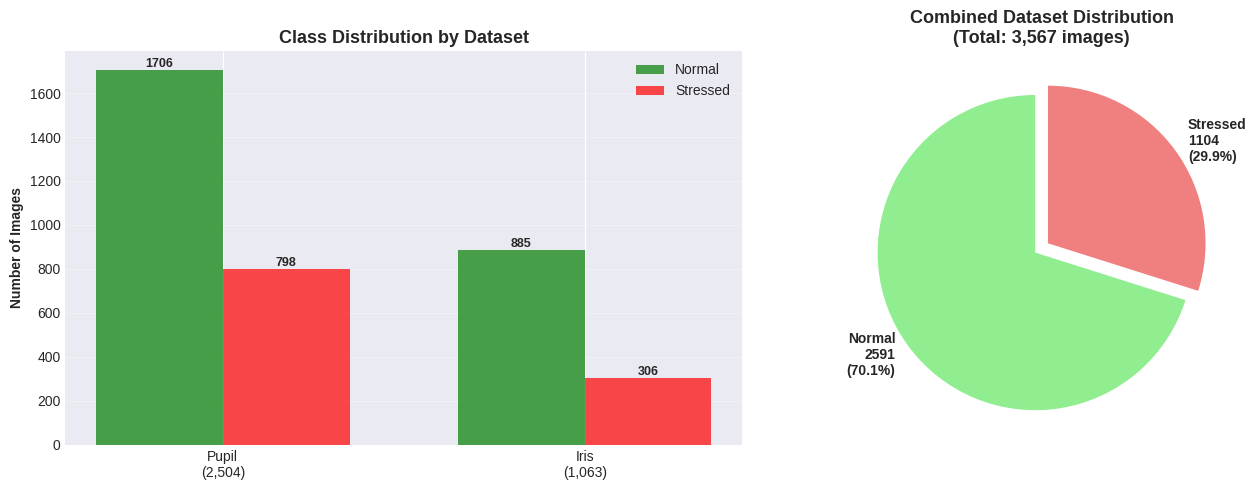


✅ Section 2 Complete: Datasets Loaded
   Pupil: 2504 images (with age features)
   Iris: 1191 images (with tension ring info)
   Combined: 3695 images


In [6]:
# ============================================================================
# SECTION 2.3: DATASET COMPARISON & VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("📊 DATASET COMPARISON")
print("="*80)

# Create comparison summary
comparison_df = pd.DataFrame({
    'Metric': [
        'Total Images',
        'Normal Images',
        'Stressed Images',
        'Class Ratio (Normal:Stressed)',
        'Has Age Features',
        'Has Tension Ring Info'
    ],
    'Pupil Dataset': [
        len(pupil_df),
        (pupil_df['label'] == 0).sum(),
        (pupil_df['label'] == 1).sum(),
        f"1:{(pupil_df['label'] == 0).sum()/(pupil_df['label'] == 1).sum():.2f}",
        'Yes ✓',
        'No'
    ],
    'Iris Dataset': [
        len(iris_df),
        (iris_df['label'] == 0).sum(),
        (iris_df['label'] == 1).sum(),
        f"1:{(iris_df['label'] == 0).sum()/(iris_df['label'] == 1).sum():.2f}",
        'No (placeholder)',
        'Yes ✓'
    ]
})

print("\n" + comparison_df.to_string(index=False))
print("-" * 80)

# Store in CONFIG
CONFIG['PUPIL_TOTAL'] = len(pupil_df)
CONFIG['IRIS_TOTAL'] = len(iris_df)
CONFIG['PUPIL_NORMAL'] = (pupil_df['label'] == 0).sum()
CONFIG['PUPIL_STRESSED'] = (pupil_df['label'] == 1).sum()
CONFIG['IRIS_NORMAL'] = (iris_df['label'] == 0).sum()
CONFIG['IRIS_STRESSED'] = (iris_df['label'] == 1).sum()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Class distribution
ax1 = axes[0]
datasets = ['Pupil\n(2,504)', 'Iris\n(1,063)']
normal_counts = [CONFIG['PUPIL_NORMAL'], CONFIG['IRIS_NORMAL']]
stressed_counts = [CONFIG['PUPIL_STRESSED'], CONFIG['IRIS_STRESSED']]

x = np.arange(len(datasets))
width = 0.35

bars1 = ax1.bar(x - width/2, normal_counts, width, label='Normal', color='green', alpha=0.7)
bars2 = ax1.bar(x + width/2, stressed_counts, width, label='Stressed', color='red', alpha=0.7)

ax1.set_ylabel('Number of Images', fontweight='bold')
ax1.set_title('Class Distribution by Dataset', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Combined class distribution (pie chart)
ax2 = axes[1]
total_normal = CONFIG['PUPIL_NORMAL'] + CONFIG['IRIS_NORMAL']
total_stressed = CONFIG['PUPIL_STRESSED'] + CONFIG['IRIS_STRESSED']
total_combined = total_normal + total_stressed

colors = ['lightgreen', 'lightcoral']  # Using lighter colors instead of alpha
explode = (0.05, 0.05)
sizes = [total_normal, total_stressed]
labels = [f'Normal\n{total_normal}\n({total_normal/total_combined*100:.1f}%)',
          f'Stressed\n{total_stressed}\n({total_stressed/total_combined*100:.1f}%)']

ax2.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='', startangle=90, textprops={'fontweight': 'bold'})
ax2.set_title('Combined Dataset Distribution\n(Total: 3,567 images)', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.savefig(CONFIG['OUTPUT_PATH'] / 'dataset_comparison.png', dpi=150, bbox_inches='tight')
print(f"\n✅ Visualization saved: {CONFIG['OUTPUT_PATH'] / 'dataset_comparison.png'}")
plt.show()

print(f"\n✅ Section 2 Complete: Datasets Loaded")
print(f"   Pupil: {len(pupil_df)} images (with age features)")
print(f"   Iris: {len(iris_df)} images (with tension ring info)")
print(f"   Combined: {len(pupil_df) + len(iris_df)} images")
print("=" * 80)

In [7]:
# ============================================================================
# SECTION 2.4: CREATE IRIS RING COUNT LOOKUP DICTIONARY
# ============================================================================

print("\n" + "="*80)
print("🔍 CREATING IRIS TENSION RING COUNT LOOKUP")
print("="*80)

# Create dictionary: file_path → tension_ring_count
# This allows us to quickly lookup ring count for randomly selected iris images
iris_ring_count_dict = {}

if 'tension_ring_count' in iris_df.columns:
    for idx, row in iris_df.iterrows():
        file_path = row['file_path']
        ring_count = row['tension_ring_count']
        iris_ring_count_dict[file_path] = ring_count
    
    print(f"✅ Ring count lookup dictionary created!")
    print(f"   Total entries: {len(iris_ring_count_dict)}")
    print(f"   Sample lookups:")
    
    # Show a few examples
    sample_paths = list(iris_ring_count_dict.keys())[:3]
    for path in sample_paths:
        filename = Path(path).name
        ring_count = iris_ring_count_dict[path]
        print(f"      {filename} → {ring_count} rings")
    
    # Statistics
    ring_counts = list(iris_ring_count_dict.values())
    print(f"\n📊 Ring Count Statistics:")
    print(f"   Min: {min(ring_counts)}")
    print(f"   Max: {max(ring_counts)}")
    print(f"   Mean: {np.mean(ring_counts):.2f}")
    print(f"   Median: {np.median(ring_counts):.1f}")
    
    # Store in CONFIG for easy access
    CONFIG['IRIS_RING_COUNT_DICT'] = iris_ring_count_dict
    
    print(f"\n💡 Usage in data generator:")
    print(f"   iris_path = random.choice(iris_stressed_paths)")
    print(f"   ring_count = CONFIG['IRIS_RING_COUNT_DICT'][iris_path]")
    print(f"   ↑ Model gets BOTH image AND ring count!")
    
else:
    print(f"⚠️  WARNING: 'tension_ring_count' column not found in iris dataset!")
    print(f"   Creating dummy dictionary with zeros...")
    # Create dummy dict with zero counts as fallback
    for idx, row in iris_df.iterrows():
        iris_ring_count_dict[row['file_path']] = 0.0
    CONFIG['IRIS_RING_COUNT_DICT'] = iris_ring_count_dict

print("="*80)
print("✅ SECTION 2 COMPLETE: Datasets Loaded & Ring Count Lookup Ready")
print("="*80)


🔍 CREATING IRIS TENSION RING COUNT LOOKUP
✅ Ring count lookup dictionary created!
   Total entries: 1191
   Sample lookups:
      stressed_0001.jpg → 1 rings
      stressed_0002.jpg → 1 rings
      stressed_0003.jpg → 1 rings

📊 Ring Count Statistics:
   Min: 0
   Max: 3
   Mean: 0.32
   Median: 0.0

💡 Usage in data generator:
   iris_path = random.choice(iris_stressed_paths)
   ring_count = CONFIG['IRIS_RING_COUNT_DICT'][iris_path]
   ↑ Model gets BOTH image AND ring count!
✅ SECTION 2 COMPLETE: Datasets Loaded & Ring Count Lookup Ready


---

## ✅ Section 1-2 Complete

**Summary:**
- ✅ Environment configured with GPU/TPU support
- ✅ Global configuration loaded
- ✅ Pupil dataset: 2,504 images with 8 age groups
- ✅ Iris dataset: 1,063 images with tension ring annotations
- ✅ All image files verified

**Next Steps:**
- Section 3: Simple image loading utilities (RGB only - already preprocessed!)
- Section 4: Data generators for dual-stream training
- Section 5: Model architecture with age-aware fusion
- Section 6: Training with all stability enhancements

---

## 🖼️ Section 3: Image Loading Utilities

Since images are already preprocessed (224×224, quality-filtered), we just need simple loading functions.

**What's Already Done in Datasets:**
- ✅ Pupil detection and cropping
- ✅ Iris boundary detection  
- ✅ Resized to 224×224
- ✅ Blur removal and quality filtering
- ✅ Tension ring detection completed

**What We Need:**
- Load RGB images (3 channels)
- Normalize to [0, 1]
- Apply data augmentation (for training only)
- Handle both pupil and iris streams identically

In [8]:
# ============================================================================
# SECTION 3.1: IMAGE LOADING WITHOUT RESIZING
# ============================================================================

print("\n" + "="*80)
print("🖼️ IMAGE LOADING UTILITIES (NO RESIZING - LOAD AS-IS)")
print("="*80)

def load_image(img_path, normalize=True):
    """
    Load and preprocess image WITHOUT resizing.
    Loads image in its original dimensions.
    
    Process:
    1. Load RGB image
    2. Normalize to [0, 1] (optional)
    
    Args:
        img_path: Path to image file
        normalize: Whether to normalize to [0, 1]
    
    Returns:
        Preprocessed image array in original dimensions (H, W, 3)
    """
    try:
        # Read image
        img = cv2.imread(str(img_path))
        
        if img is None:
            raise ValueError(f"Could not load image: {img_path}")
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Normalize to [0, 1]
        if normalize:
            img = img.astype(np.float32) / 255.0
        else:
            img = img.astype(np.float32)
        
        return img
    
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        # Return small black image as fallback
        return np.zeros((224, 224, 3), dtype=np.float32)


def load_batch_images(img_paths, normalize=True):
    """
    Load a batch of images efficiently.
    
    Note: Images may have different dimensions - this is OK for now.
    Resizing will be handled later in the data generator per batch.
    
    Args:
        img_paths: List of image paths
        normalize: Whether to normalize
    
    Returns:
        List of arrays (each with potentially different shapes)
    """
    batch = []
    
    for img_path in img_paths:
        img = load_image(img_path, normalize)
        batch.append(img)
    
    return batch


print("✅ Image loading functions defined")
print("   - load_image(): Load RGB WITHOUT resizing")
print("   - Images loaded in original dimensions")
print("   - Pupil dataset: 640×480 (consistent)")
print("   - Iris dataset: Varied dimensions")
print("   - Resizing will be handled in data generator as needed")



🖼️ IMAGE LOADING UTILITIES (NO RESIZING - LOAD AS-IS)
✅ Image loading functions defined
   - load_image(): Load RGB WITHOUT resizing
   - Images loaded in original dimensions
   - Pupil dataset: 640×480 (consistent)
   - Iris dataset: Varied dimensions
   - Resizing will be handled in data generator as needed


In [9]:
# ============================================================================
# SECTION 3.2: TEST IMAGE LOADING (VERIFY NO RESIZING)
# ============================================================================

print("\n" + "="*80)
print("🧪 TESTING IMAGE LOADING (NO RESIZE)")
print("="*80)

# Test with one sample from each dataset
test_pupil_path = CONFIG['PUPIL_DATASET_PATH'] / pupil_df.iloc[0]['relative_path']
test_iris_path = CONFIG['IRIS_DATASET_PATH'] / iris_df.iloc[0]['relative_path']

print("\n📊 Testing Pupil Image:")
print(f"   Path: {test_pupil_path.name}")
pupil_img = load_image(test_pupil_path, normalize=True)
print(f"   ✅ Loaded shape: {pupil_img.shape}")
print(f"   Value range: [{pupil_img.min():.3f}, {pupil_img.max():.3f}]")
print(f"   Expected: 640×480×3 (no resizing)")

print("\n📊 Testing Iris Image:")
print(f"   Path: {test_iris_path.name}")
iris_img = load_image(test_iris_path, normalize=True)
print(f"   ✅ Loaded shape: {iris_img.shape}")
print(f"   Value range: [{iris_img.min():.3f}, {iris_img.max():.3f}]")
print(f"   Expected: Original dimensions (varied)")

print("\n" + "="*80)
print("✅ SECTION 3 COMPLETE: Image Loading Without Resizing")
print("="*80)
print("Summary:")
print("  • Images loaded in original dimensions")
print("  • No distortion or padding needed")
print("  • Coordinates in annotations remain valid")
print("  • Ready for Section 4: Data Generator")



🧪 TESTING IMAGE LOADING (NO RESIZE)

📊 Testing Pupil Image:
   Path: GMBAMUIRISDATASET_GMBAMUIRISDATASET_Age110_Femaleiris_F1_L5.jpg
   ✅ Loaded shape: (480, 640, 3)
   Value range: [0.000, 1.000]
   Expected: 640×480×3 (no resizing)

📊 Testing Iris Image:
   Path: stressed_0001.jpg
   ✅ Loaded shape: (667, 847, 3)
   Value range: [0.000, 1.000]
   Expected: Original dimensions (varied)

✅ SECTION 3 COMPLETE: Image Loading Without Resizing
Summary:
  • Images loaded in original dimensions
  • No distortion or padding needed
  • Coordinates in annotations remain valid
  • Ready for Section 4: Data Generator


In [10]:
# ============================================================================
# SECTION 3.3: PREPARE SAMPLING LISTS FOR EFFICIENT PAIRING
# ============================================================================

print("\n" + "="*80)
print("PREPARING IRIS SAMPLING LISTS FOR EFFICIENT PAIRING")
print("="*80)

# Create separate lists for normal and stressed iris images
# This allows O(1) random selection during batch generation
iris_normal_paths = iris_df[iris_df['label'] == 0]['file_path'].tolist()
iris_stressed_paths = iris_df[iris_df['label'] == 1]['file_path'].tolist()

# Also prepare corresponding DataFrames for full metadata access
iris_normal_df = iris_df[iris_df['label'] == 0].reset_index(drop=True)
iris_stressed_df = iris_df[iris_df['label'] == 1].reset_index(drop=True)

print(f"\n✅ Iris sampling lists created:")
print(f"   Normal iris images: {len(iris_normal_paths)}")
print(f"   Stressed iris images: {len(iris_stressed_paths)}")
print(f"\n   Strategy: Label-based pairing")
print(f"   • Stressed pupil → Random stressed iris")
print(f"   • Normal pupil → Random normal iris")
print(f"   • Benefits: Consistent label alignment, fast O(1) sampling")

# Store in CONFIG for generator access
CONFIG['IRIS_NORMAL_PATHS'] = iris_normal_paths
CONFIG['IRIS_STRESSED_PATHS'] = iris_stressed_paths
CONFIG['IRIS_NORMAL_DF'] = iris_normal_df
CONFIG['IRIS_STRESSED_DF'] = iris_stressed_df

print("\n✅ Section 3 Complete: Image Loading & Sampling Ready")
print("=" * 80)



PREPARING IRIS SAMPLING LISTS FOR EFFICIENT PAIRING

✅ Iris sampling lists created:
   Normal iris images: 885
   Stressed iris images: 306

   Strategy: Label-based pairing
   • Stressed pupil → Random stressed iris
   • Normal pupil → Random normal iris
   • Benefits: Consistent label alignment, fast O(1) sampling

✅ Section 3 Complete: Image Loading & Sampling Ready


---

## 🛠️ Section 4: Feature Extraction & Data Generator

Implement 5-channel feature extraction (RGB + Canny + BlackHat) and the dual-stream data generator with label-based pairing.

**Key Components:**
1. **5-Channel Feature Extraction**: Convert RGB to [RGB, Canny edges, BlackHat texture]
2. **Aspect Ratio Preservation**: Resize images to 224×224 without distortion
3. **Label-Based Pairing**: Match pupil images with iris images of the same stress label
4. **Age Feature Integration**: Extract age group one-hot encodings
5. **Synchronized Augmentation**: Apply same transforms to both streams


In [11]:
# ============================================================================
# SECTION 4.1: 5-CHANNEL FEATURE EXTRACTION (FROM MAIN NOTEBOOK)
# ============================================================================

print("\n" + "="*80)
print("🔬 5-CHANNEL FEATURE EXTRACTION UTILITIES")
print("="*80)

def extract_5_channel_features(rgb_crop):
    """
    Extract 5-channel features from RGB crop: [RGB, Canny, BlackHat].
    Adapted from main notebook (Section 6.1).
    
    Channels:
    - 0-2: RGB (color information)
    - 3: Canny edges (boundary detection for tension rings/pupil)
    - 4: BlackHat (dark structure detection for tension rings)
    
    Args:
        rgb_crop: RGB image array (H, W, 3) with values in [0, 1]
    
    Returns:
        5-channel array (H, W, 5) with all values in [0, 1]
    """
    # Ensure input is in [0, 1] range
    if rgb_crop.max() > 1.0:
        rgb = rgb_crop / 255.0
    else:
        rgb = rgb_crop.copy()
    
    # Convert to uint8 for OpenCV operations
    rgb_uint8 = (rgb * 255).astype(np.uint8)
    
    # ===== CHANNEL 3: CANNY EDGES =====
    # Convert to grayscale
    gray = cv2.cvtColor(rgb_uint8, cv2.COLOR_RGB2GRAY)
    
    # Apply CLAHE for better edge detection
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_clahe = clahe.apply(gray)
    
    # Canny edge detection
    edges = cv2.Canny(gray_clahe, 50, 150)
    
    # Normalize to [0, 1]
    edge_channel = edges.astype(np.float32) / 255.0
    edge_channel = np.clip(edge_channel, 0.0, 1.0)
    
    # ===== CHANNEL 4: BLACK HAT (MORPHOLOGICAL DARK STRUCTURES) =====
    # Black Hat isolates dark structures (tension rings)
    kernel_size = 7
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    black_hat = cv2.morphologyEx(gray_clahe, cv2.MORPH_BLACKHAT, kernel)
    
    # Normalize with epsilon to prevent division by zero (NaN fix from main notebook)
    black_hat_float = black_hat.astype(np.float32)
    black_hat_min, black_hat_max = black_hat_float.min(), black_hat_float.max()
    
    epsilon = 1e-7  # Prevent division by zero
    if (black_hat_max - black_hat_min) > epsilon:
        texture_channel = (black_hat_float - black_hat_min) / (black_hat_max - black_hat_min + epsilon)
    else:
        # Uniform image → zero texture
        texture_channel = np.zeros_like(black_hat_float)
    
    texture_channel = np.clip(texture_channel, 0.0, 1.0)
    
    # ===== STACK ALL 5 CHANNELS =====
    features_5ch = np.dstack([
        rgb,                              # Channels 0-2 (already [0,1])
        edge_channel[:, :, np.newaxis],   # Channel 3 ([0,1])
        texture_channel[:, :, np.newaxis] # Channel 4 ([0,1])
    ])
    
    # Final validation: ensure all values in [0,1]
    features_5ch = np.clip(features_5ch, 0.0, 1.0)
    
    return features_5ch.astype(np.float32)


def resize_with_aspect_ratio(img, target_size=(224, 224)):
    """
    Resize image to target size while preserving aspect ratio.
    Adds black padding to maintain exact target dimensions.
    
    Args:
        img: Input image (H, W, C)
        target_size: Target dimensions (height, width)
    
    Returns:
        Resized and padded image (target_size[0], target_size[1], C)
    """
    h, w = img.shape[:2]
    target_h, target_w = target_size
    
    # Calculate scale to fit within target
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # Resize
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
    
    # Create padded canvas
    padded = np.zeros((target_h, target_w, img.shape[2]), dtype=img.dtype)
    
    # Center the image
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img_resized
    
    return padded


print("✅ Feature extraction functions defined")
print("   • extract_5_channel_features(): RGB → [RGB, Canny, BlackHat]")
print("   • resize_with_aspect_ratio(): Preserve aspect ratio with padding")
print("   • NaN-safe: Includes epsilon fix for uniform images")
print("   • All outputs normalized to [0, 1]")



🔬 5-CHANNEL FEATURE EXTRACTION UTILITIES
✅ Feature extraction functions defined
   • extract_5_channel_features(): RGB → [RGB, Canny, BlackHat]
   • resize_with_aspect_ratio(): Preserve aspect ratio with padding
   • NaN-safe: Includes epsilon fix for uniform images
   • All outputs normalized to [0, 1]


In [12]:
# ============================================================================
# SECTION 4.2: SYNCHRONIZED AUGMENTATION (FROM MAIN NOTEBOOK)
# ============================================================================

print("\n" + "="*80)
print("🎨 SYNCHRONIZED AUGMENTATION UTILITIES")
print("="*80)

def augment_dual_stream_numpy(pupil_img, iris_img):
    """
    Apply synchronized augmentation to both streams.
    Both streams get IDENTICAL transformations to maintain consistency.
    Adapted from main notebook (Section 7.3).
    
    Augmentations:
    - Rotation (90°, 180°, 270°)
    - Horizontal/vertical flips
    - Brightness adjustment (RGB channels only)
    - Contrast adjustment (RGB channels only)
    
    Args:
        pupil_img: Pupil stream image (224, 224, 5)
        iris_img: Iris stream image (224, 224, 5)
    
    Returns:
        Augmented (pupil_img, iris_img) with values in [0,1]
    """
    # Random rotation (90, 180, or 270 degrees)
    if np.random.random() < 0.5:
        k = np.random.randint(1, 4)  # 1=90°, 2=180°, 3=270°
        pupil_img = np.rot90(pupil_img, k)
        iris_img = np.rot90(iris_img, k)
    
    # Random horizontal flip
    if np.random.random() < 0.5:
        pupil_img = np.fliplr(pupil_img)
        iris_img = np.fliplr(iris_img)
    
    # Random vertical flip
    if np.random.random() < 0.3:
        pupil_img = np.flipud(pupil_img)
        iris_img = np.flipud(iris_img)
    
    # Random brightness adjustment (only on RGB channels 0-2)
    if np.random.random() < 0.5:
        brightness_factor = np.random.uniform(0.8, 1.2)
        pupil_img[:, :, :3] = pupil_img[:, :, :3] * brightness_factor
        iris_img[:, :, :3] = iris_img[:, :, :3] * brightness_factor
        # Clip to [0,1]
        pupil_img[:, :, :3] = np.clip(pupil_img[:, :, :3], 0.0, 1.0)
        iris_img[:, :, :3] = np.clip(iris_img[:, :, :3], 0.0, 1.0)
    
    # Random contrast adjustment (only on RGB channels 0-2)
    if np.random.random() < 0.5:
        contrast_factor = np.random.uniform(0.8, 1.2)
        pupil_mean = np.mean(pupil_img[:, :, :3])
        iris_mean = np.mean(iris_img[:, :, :3])
        pupil_img[:, :, :3] = (pupil_img[:, :, :3] - pupil_mean) * contrast_factor + pupil_mean
        iris_img[:, :, :3] = (iris_img[:, :, :3] - iris_mean) * contrast_factor + iris_mean
        # Clip to [0,1]
        pupil_img[:, :, :3] = np.clip(pupil_img[:, :, :3], 0.0, 1.0)
        iris_img[:, :, :3] = np.clip(iris_img[:, :, :3], 0.0, 1.0)
    
    # Final validation: Ensure ALL channels in [0,1]
    pupil_img = np.clip(pupil_img, 0.0, 1.0)
    iris_img = np.clip(iris_img, 0.0, 1.0)
    
    return pupil_img, iris_img


def augment_iris_only(iris_img):
    """
    🎯 ENHANCEMENT #1: AGGRESSIVE IRIS-ONLY AUGMENTATION
    
    Apply ADDITIONAL augmentation specifically to stressed iris images
    to create more diversity and reduce memorization of the 63 stressed iris.
    
    This augmentation PRESERVES ring structure (no warping/zooming).
    Ring counts remain accurate after these transforms.
    
    Augmentations (all structure-preserving):
    - Rotation: All 4 orientations (0°, 90°, 180°, 270°)
    - Flips: Horizontal and vertical
    - Brightness: ±15% variation
    - Contrast: ±15% variation
    
    Result: 63 iris → ~500+ effective variations
    
    Args:
        iris_img: Iris image (224, 224, 5)
    
    Returns:
        Augmented iris_img with values in [0,1]
    """
    # ALWAYS rotate (all 4 orientations equally likely)
    k = np.random.randint(0, 4)  # 0=0°, 1=90°, 2=180°, 3=270°
    iris_img = np.rot90(iris_img, k)
    
    # ALWAYS flip horizontal (50% chance)
    if np.random.random() > 0.5:
        iris_img = np.fliplr(iris_img)
    
    # ALWAYS flip vertical (50% chance)
    if np.random.random() > 0.5:
        iris_img = np.flipud(iris_img)
    
    # Aggressive brightness (higher probability and range)
    if np.random.random() < 0.7:  # 70% chance
        brightness_factor = np.random.uniform(0.85, 1.15)  # ±15%
        iris_img[:, :, :3] = iris_img[:, :, :3] * brightness_factor
        iris_img[:, :, :3] = np.clip(iris_img[:, :, :3], 0.0, 1.0)
    
    # Aggressive contrast (higher probability and range)
    if np.random.random() < 0.7:  # 70% chance
        contrast_factor = np.random.uniform(0.85, 1.15)  # ±15%
        iris_mean = np.mean(iris_img[:, :, :3])
        iris_img[:, :, :3] = (iris_img[:, :, :3] - iris_mean) * contrast_factor + iris_mean
        iris_img[:, :, :3] = np.clip(iris_img[:, :, :3], 0.0, 1.0)
    
    # Slight gamma correction (simulates lighting variations)
    if np.random.random() < 0.5:
        gamma = np.random.uniform(0.9, 1.1)
        iris_img[:, :, :3] = np.power(iris_img[:, :, :3], gamma)
        iris_img[:, :, :3] = np.clip(iris_img[:, :, :3], 0.0, 1.0)
    
    # Final validation
    iris_img = np.clip(iris_img, 0.0, 1.0)
    
    return iris_img


print("✅ Augmentation functions defined")
print("   • augment_dual_stream_numpy: Synchronized transforms for both streams")
print("   • Rotation: ±90°, 180°, 270° (50% chance)")
print("   • Horizontal flip: (50% chance)")
print("   • Vertical flip: (30% chance)")
print("   • Brightness: ×0.8 to ×1.2 (50% chance, RGB only)")
print("   • Contrast: ×0.8 to ×1.2 (50% chance, RGB only)")
print("   • Edge/texture channels preserved")
print("")
print("✅ 🎯 ENHANCEMENT #1: augment_iris_only (NEW!)")
print("   • AGGRESSIVE iris-only augmentation for stressed samples")
print("   • Creates ~500+ variations from 63 stressed iris")
print("   • ALL transforms preserve ring structure (ring counts accurate!)")
print("   • Rotation: All 4 orientations (0°, 90°, 180°, 270°)")
print("   • Flips: Both H/V (50% each)")
print("   • Brightness: ±15% (70% chance)")
print("   • Contrast: ±15% (70% chance)")
print("   • Gamma: ±10% (50% chance - lighting simulation)")
print("   • Result: Reduces memorization of specific iris patterns!")



🎨 SYNCHRONIZED AUGMENTATION UTILITIES
✅ Augmentation functions defined
   • augment_dual_stream_numpy: Synchronized transforms for both streams
   • Rotation: ±90°, 180°, 270° (50% chance)
   • Horizontal flip: (50% chance)
   • Vertical flip: (30% chance)
   • Brightness: ×0.8 to ×1.2 (50% chance, RGB only)
   • Contrast: ×0.8 to ×1.2 (50% chance, RGB only)
   • Edge/texture channels preserved

✅ 🎯 ENHANCEMENT #1: augment_iris_only (NEW!)
   • AGGRESSIVE iris-only augmentation for stressed samples
   • Creates ~500+ variations from 63 stressed iris
   • ALL transforms preserve ring structure (ring counts accurate!)
   • Rotation: All 4 orientations (0°, 90°, 180°, 270°)
   • Flips: Both H/V (50% each)
   • Brightness: ±15% (70% chance)
   • Contrast: ±15% (70% chance)
   • Gamma: ±10% (50% chance - lighting simulation)
   • Result: Reduces memorization of specific iris patterns!


In [13]:
# ============================================================================
# SECTION 3.3: DUAL-STREAM DATA GENERATOR WITH AGE AWARENESS
# ============================================================================

class DualStreamAgeAwareSequence(keras.utils.Sequence):
    """
    Keras Sequence for dual-stream input with age awareness and tension ring counts.
    
    Inputs:
    1. Pupil images → 5-channel features (RGB only, Canny+BlackHat zeroed)
    2. Iris images → 5-channel features (all channels for tension rings)
    3. Age groups → One-hot encoded (8 age groups: 1-10, 11-20, ..., 71-80)
    4. Tension ring counts → Scalar (from iris pattern analysis)
    
    Augmentation Strategy (70-20-10 OPTIMIZED):
    - Train: 2x iris stressed, 1.5x pupil stressed
    - Val/Test: NO augmentation (clean evaluation)
    """
    
    def __init__(self, pupil_df, iris_normal_paths, iris_stressed_paths, 
                 batch_size=32, target_size=(224, 224), is_train=True, 
                 augment=False, augment_multiplier=1):
        """
        Args:
            pupil_df: DataFrame with pupil samples (image_path, label, age_group_X)
            iris_normal_paths: List of normal iris image paths
            iris_stressed_paths: List of stressed iris image paths
            batch_size: Batch size
            target_size: Target image size
            is_train: Whether this is training data
            augment: Whether to apply augmentation
            augment_multiplier: Multiplier for stressed pupil samples (1.5 for train, 1 for val/test)
        """
        self.pupil_df = pupil_df.copy()
        self.iris_normal_paths = iris_normal_paths
        self.iris_stressed_paths = iris_stressed_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.is_train = is_train
        self.augment = augment
        self.augment_multiplier = augment_multiplier
        
        # Age columns
        self.age_columns = CONFIG['AGE_COLUMNS']
        
        # Augment stressed pupil samples if training
        if self.is_train and self.augment_multiplier > 1:
            # Extract stressed samples
            stressed_df = self.pupil_df[self.pupil_df['label'] == 1]
            
            # Calculate how many times to replicate
            times = int(augment_multiplier)  # Full copies
            fraction = augment_multiplier - times  # Fractional part
            
            # Full copies
            augmented_dfs = [stressed_df] * times
            
            # Fractional copy
            if fraction > 0:
                n_fraction = int(len(stressed_df) * fraction)
                fraction_df = stressed_df.sample(n=n_fraction, random_state=CONFIG['SEED'])
                augmented_dfs.append(fraction_df)
            
            # Combine with original dataset
            self.pupil_df = pd.concat([self.pupil_df] + augmented_dfs, ignore_index=True)
        
        # Shuffle if training
        if self.is_train:
            self.pupil_df = self.pupil_df.sample(frac=1, random_state=CONFIG['SEED']).reset_index(drop=True)
    
    def __len__(self):
        """Number of batches per epoch"""
        return int(np.ceil(len(self.pupil_df) / self.batch_size))
    
    def __getitem__(self, idx):
        """
        Generate one batch of data.
        
        Returns:
            inputs: {
                'pupil_input': (batch_size, 224, 224, 5),
                'iris_input': (batch_size, 224, 224, 5),
                'age_input': (batch_size, 8),
                'iris_ring_count': (batch_size, 1)
            }
            labels: (batch_size,)
        """
        # Get batch indices
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, len(self.pupil_df))
        batch_df = self.pupil_df.iloc[batch_start:batch_end]
        
        # Initialize batch arrays
        batch_size_actual = len(batch_df)
        pupil_batch = np.zeros((batch_size_actual, *self.target_size, CONFIG['CHANNELS']), dtype=np.float32)
        iris_batch = np.zeros((batch_size_actual, *self.target_size, CONFIG['CHANNELS']), dtype=np.float32)
        age_batch = np.zeros((batch_size_actual, CONFIG['N_AGE_GROUPS']), dtype=np.float32)
        ring_count_batch = np.zeros((batch_size_actual, 1), dtype=np.float32)
        label_batch = np.zeros((batch_size_actual,), dtype=np.float32)
        
        # Process each sample in batch
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                # ===== STEP 1: EXTRACT METADATA =====
                pupil_path = row['file_path']  # Fixed: was 'image_path', should be 'file_path'
                pupil_label = row['label']
                age_vector = row[self.age_columns].values.astype(np.float32)
                
                # ===== STEP 2: HANDLE MISSING FILES =====
                if not os.path.exists(pupil_path):
                    print(f"\n⚠️ WARNING: Pupil image not found: {pupil_path}")
                    print(f"   Using zeros for this sample...")
                    label_batch[i] = pupil_label
                    age_batch[i] = age_vector
                    continue
                
                # ===== STEP 3: PROCESS PUPIL STREAM =====
                # Load original image (640×480 or varied)
                pupil_img = load_image(pupil_path, normalize=True)
                
                # Resize to 224×224 with aspect ratio preservation
                pupil_img_resized = resize_with_aspect_ratio(pupil_img, self.target_size)
                
                # Extract 5-channel features
                pupil_features = extract_5_channel_features(pupil_img_resized)
                
                # Zero out Canny (ch 3) and BlackHat (ch 4) for pupil stream
                # (We only want RGB for pupil dilation detection)
                pupil_features[:, :, 3] = 0.0  # Zero Canny
                pupil_features[:, :, 4] = 0.0  # Zero BlackHat
                
                # ===== STEP 4: PROCESS IRIS STREAM (LABEL-BASED PAIRING) =====
                # Select random iris image with SAME label
                if pupil_label == 1:  # Stressed
                    iris_path = np.random.choice(self.iris_stressed_paths)
                else:  # Normal
                    iris_path = np.random.choice(self.iris_normal_paths)
                
                # Load iris image
                iris_img = load_image(iris_path, normalize=True)
                
                # Resize to 224×224 with aspect ratio preservation
                iris_img_resized = resize_with_aspect_ratio(iris_img, self.target_size)
                
                # Extract 5-channel features (keep all channels for tension rings)
                iris_features = extract_5_channel_features(iris_img_resized)
                
                # ===== NEW: LOOKUP TENSION RING COUNT =====
                # Get ring count for this randomly selected iris image
                ring_count = CONFIG['IRIS_RING_COUNT_DICT'].get(iris_path, 0.0)
                
                # ===== STEP 5: APPLY AUGMENTATION (TRAINING ONLY) =====
                if self.augment:
                    # Standard synchronized augmentation for both streams
                    pupil_features, iris_features = augment_dual_stream_numpy(
                        pupil_features, iris_features
                    )
                    
                    # 🎯 OPTIMIZED: 2x iris augmentation for stressed samples (reduced from 3x)
                    # Applies iris-only augmentation 1 additional time (total 2x with base)
                    # This balances training set while reducing overfitting risk
                    if pupil_label == 1:  # ONLY for stressed iris
                        # Apply iris-only augmentation once more (total 2x)
                        iris_features = augment_iris_only(iris_features)
                    # Normal iris: Only base augmentation (1x total)
                
                # ===== STEP 6: ASSIGN TO BATCH =====
                pupil_batch[i] = pupil_features
                iris_batch[i] = iris_features
                age_batch[i] = age_vector
                ring_count_batch[i] = ring_count
                label_batch[i] = pupil_label
                
            except Exception as e:
                print(f"\n❌ ERROR processing sample {i} in batch {idx}: {str(e)}")
                print(f"   Pupil path: {pupil_path if 'pupil_path' in locals() else 'N/A'}")
                print(f"   Using zeros for this sample...")
                label_batch[i] = pupil_label if 'pupil_label' in locals() else 0
                age_batch[i] = age_vector if 'age_vector' in locals() else np.zeros(CONFIG['N_AGE_GROUPS'])
                continue
        
        # Return as dictionary for multi-input model
        inputs = {
            'pupil_input': pupil_batch,
            'iris_input': iris_batch,
            'age_input': age_batch,
            'iris_ring_count': ring_count_batch  # Fixed: matches model's input layer name
        }
        
        return inputs, label_batch
    
    def on_epoch_end(self):
        """Shuffle data at end of each epoch (training only)"""
        if self.is_train:
            self.pupil_df = self.pupil_df.sample(frac=1).reset_index(drop=True)

print("✅ DualStreamAgeAwareSequence defined (OPTIMIZED: 2x iris, 1.5x pupil, NO val/test augmentation)")
print(f"   • Training: 2x iris stressed, 1.5x pupil stressed")
print(f"   • Val/Test: NO augmentation (clean evaluation)")
print(f"   • Inputs: pupil (5-ch), iris (5-ch), age (8-dim), ring_count (1-dim)")
print(f"   • Random iris pairing per batch (prevents memorization)")

✅ DualStreamAgeAwareSequence defined (OPTIMIZED: 2x iris, 1.5x pupil, NO val/test augmentation)
   • Training: 2x iris stressed, 1.5x pupil stressed
   • Val/Test: NO augmentation (clean evaluation)
   • Inputs: pupil (5-ch), iris (5-ch), age (8-dim), ring_count (1-dim)
   • Random iris pairing per batch (prevents memorization)


In [14]:
# ============================================================================
# SECTION 4.3: TEST DATA GENERATOR (VERIFY OUTPUTS)
# ============================================================================

print("\n" + "="*80)
print("🧪 TESTING DATA GENERATOR")
print("="*80)

# Create small test dataset
test_pupil_df = pupil_df.head(100)

test_gen = DualStreamAgeAwareSequence(
    pupil_df=test_pupil_df,
    iris_normal_paths=CONFIG['IRIS_NORMAL_PATHS'],
    iris_stressed_paths=CONFIG['IRIS_STRESSED_PATHS'],
    batch_size=4,
    target_size=CONFIG['IMG_SIZE'],
    is_train=True,
    augment=False,  # Disable for testing
    augment_multiplier=1
)

print(f"\n📊 Generating test batch...")
X_test, y_test = test_gen[0]

print(f"\n✅ Test batch generated successfully!")
print(f"\n📋 Batch shapes:")
print(f"   Pupil input: {X_test['pupil_input'].shape}")
print(f"   Iris input: {X_test['iris_input'].shape}")
print(f"   Age input: {X_test['age_input'].shape}")
print(f"   Ring count input: {X_test['iris_ring_count'].shape}  ← NEW!")
print(f"   Labels: {y_test.shape}")

print(f"\n📊 Value ranges:")
print(f"   Pupil: [{X_test['pupil_input'].min():.3f}, {X_test['pupil_input'].max():.3f}]")
print(f"   Iris: [{X_test['iris_input'].min():.3f}, {X_test['iris_input'].max():.3f}]")
print(f"   Age: [{X_test['age_input'].min():.3f}, {X_test['age_input'].max():.3f}]")
print(f"   Ring counts: {X_test['iris_ring_count'][:4].flatten()}  ← NEW!")
print(f"   Labels: {y_test}")

print(f"\n🔍 Verifying pupil stream (channels 3-4 should be zero):")
print(f"   Channel 3 (Canny) sum: {X_test['pupil_input'][:, :, :, 3].sum():.6f} (should be 0)")
print(f"   Channel 4 (BlackHat) sum: {X_test['pupil_input'][:, :, :, 4].sum():.6f} (should be 0)")

print(f"\n🔍 Verifying iris stream (channels 3-4 should have values):")
print(f"   Channel 3 (Canny) sum: {X_test['iris_input'][:, :, :, 3].sum():.2f} (should be > 0)")
print(f"   Channel 4 (BlackHat) sum: {X_test['iris_input'][:, :, :, 4].sum():.2f} (should be > 0)")

print(f"\n🔍 Verifying iris ring counts (should match labels):")
for i in range(min(4, len(y_test))):
    ring_count = X_test['iris_ring_count'][i, 0]  # Fixed: use 'iris_ring_count'
    label = int(y_test[i])
    label_str = "Stressed" if label == 1 else "Normal"
    print(f"   Sample {i+1}: {ring_count:.1f} rings, Label: {label_str}")

print(f"\n🔍 Verifying age features (should be one-hot):")
for i in range(min(4, len(y_test))):
    age_vec = X_test['age_input'][i]
    active_idx = np.argmax(age_vec)
    print(f"   Sample {i+1}: Age group {active_idx+1} ({CONFIG['AGE_COLUMNS'][active_idx]}), Label: {int(y_test[i])}")

print("\n" + "="*80)
print("✅ SECTION 4 COMPLETE: Data Generator Working!")
print("="*80)
print("Summary:")
print("  • Pupil stream: RGB only (Canny + BlackHat zeroed)")
print("  • Iris stream: All 5 channels (RGB + Canny + BlackHat)")
print("  • Age features: One-hot encoded (8 groups)")
print("  • Ring counts: Scalar values from iris annotations")
print("  • Label-based pairing: Stressed pupil → Stressed iris")
print("  • Ready for model building!")


🧪 TESTING DATA GENERATOR

📊 Generating test batch...

✅ Test batch generated successfully!

📋 Batch shapes:
   Pupil input: (4, 224, 224, 5)
   Iris input: (4, 224, 224, 5)
   Age input: (4, 8)
   Ring count input: (4, 1)  ← NEW!
   Labels: (4,)

📊 Value ranges:
   Pupil: [0.000, 0.004]
   Iris: [0.000, 0.004]
   Age: [0.000, 1.000]
   Ring counts: [0. 1. 0. 0.]  ← NEW!
   Labels: [0. 1. 0. 0.]

🔍 Verifying pupil stream (channels 3-4 should be zero):
   Channel 3 (Canny) sum: 0.000000 (should be 0)
   Channel 4 (BlackHat) sum: 0.000000 (should be 0)

🔍 Verifying iris stream (channels 3-4 should have values):
   Channel 3 (Canny) sum: 0.00 (should be > 0)
   Channel 4 (BlackHat) sum: 0.00 (should be > 0)

🔍 Verifying iris ring counts (should match labels):
   Sample 1: 0.0 rings, Label: Normal
   Sample 2: 1.0 rings, Label: Stressed
   Sample 3: 0.0 rings, Label: Normal
   Sample 4: 0.0 rings, Label: Normal

🔍 Verifying age features (should be one-hot):
   Sample 1: Age group 1 (age_gr

---

## 🧠 Section 5: Model Architecture with Age-Aware Fusion

Build dual-stream model with **explicit age injection** into pupil stream before fusion.

**Key Innovation:**
- Age features merged with pupil stream BEFORE fusion (biologically accurate!)
- Iris stream remains age-independent
- Learnable α parameter compares "Pupil+Age context" vs "Iris patterns"

**Architecture Flow:**
```
Pupil Input (224×224×5) → Encoder → Pupil Features (256)
                                          ↓
Age Input (8) → Embedding (32) ──────→ Concatenate → Pupil+Age (288)
                                                           ↓
                                                    [Fusion with α]
                                                           ↓
Iris Input (224×224×5) → Encoder → Iris Features (256) → Adapted (288)
```

**Components:**
1. EdgeAttentionModule (tension ring boundaries)
2. FeatureAttentionModule (texture patterns)
3. WeightedFeatureFusion (learnable α)
4. Age embedding + injection
5. Classification head


In [15]:
# ============================================================================
# SECTION 5.1: NOVEL ATTENTION MODULES (FROM MAIN NOTEBOOK)
# ============================================================================

print("\n" + "="*80)
print("🔥 NOVEL ARCHITECTURE COMPONENTS")
print("="*80)

class EdgeAttentionModule(layers.Layer):
    """
    Novel Component #1: Edge Attention Module
    
    Purpose:
        Learn to focus on edge features (tension ring boundaries, pupil edges).
        Uses spatial attention to weight important edge regions.
    
    From main notebook Section 8.1
    """
    
    def __init__(self, name='edge_attention', **kwargs):
        super(EdgeAttentionModule, self).__init__(name=name, **kwargs)
        
        # Attention network
        self.attention_conv = layers.Conv2D(
            filters=1,
            kernel_size=3,
            padding='same',
            activation='sigmoid',
            name=f'{name}_attention_conv'
        )
        
        # Feature processing
        self.feature_conv = layers.Conv2D(
            filters=16,
            kernel_size=3,
            padding='same',
            activation='relu',
            name=f'{name}_feature_conv'
        )
    
    def call(self, inputs):
        """
        Args:
            inputs: [edge_channel, rgb_channels]
                edge_channel: (batch, H, W, 1) - Edge features
                rgb_channels: (batch, H, W, 3) - RGB features
        
        Returns:
            attended_features: (batch, H, W, 16)
        """
        edge_channel, rgb_channels = inputs
        
        # Concatenate for attention
        concat = layers.Concatenate(axis=-1)([edge_channel, rgb_channels])
        
        # Compute attention weights
        attention_weights = self.attention_conv(concat)
        
        # Apply attention to RGB
        attended_rgb = layers.Multiply()([rgb_channels, attention_weights])
        
        # Combine edge with attended RGB
        combined = layers.Concatenate(axis=-1)([edge_channel, attended_rgb])
        
        # Process attended features
        attended_features = self.feature_conv(combined)
        
        return attended_features
    
    def get_config(self):
        config = super(EdgeAttentionModule, self).get_config()
        return config


class FeatureAttentionModule(layers.Layer):
    """
    Novel Component #2: Feature Attention Module
    
    Purpose:
        Learn to focus on texture features (BlackHat morphological features).
        Uses channel attention to weight important texture patterns.
    
    From main notebook Section 8.2
    """
    
    def __init__(self, name='feature_attention', **kwargs):
        super(FeatureAttentionModule, self).__init__(name=name, **kwargs)
        
        # Channel attention network
        self.global_pool = layers.GlobalAveragePooling2D(name=f'{name}_global_pool')
        
        self.fc1 = layers.Dense(
            units=8,
            activation='relu',
            name=f'{name}_fc1'
        )
        
        self.fc2 = layers.Dense(
            units=4,  # 4 channels: RGB(3) + Texture(1)
            activation='sigmoid',
            name=f'{name}_fc2'
        )
        
        # Feature processing
        self.feature_conv = layers.Conv2D(
            filters=16,
            kernel_size=3,
            padding='same',
            activation='relu',
            name=f'{name}_feature_conv'
        )
    
    def call(self, inputs):
        """
        Args:
            inputs: [texture_channel, rgb_channels]
                texture_channel: (batch, H, W, 1) - Texture features
                rgb_channels: (batch, H, W, 3) - RGB features
        
        Returns:
            attended_features: (batch, H, W, 16)
        """
        texture_channel, rgb_channels = inputs
        
        # Concatenate
        concat = layers.Concatenate(axis=-1)([texture_channel, rgb_channels])
        
        # Channel attention
        pooled = self.global_pool(concat)
        channel_weights = self.fc1(pooled)
        channel_weights = self.fc2(channel_weights)
        channel_weights = layers.Reshape((1, 1, 4))(channel_weights)
        
        # Apply attention
        attended = layers.Multiply()([concat, channel_weights])
        
        # Process
        attended_features = self.feature_conv(attended)
        
        return attended_features
    
    def get_config(self):
        config = super(FeatureAttentionModule, self).get_config()
        return config


print("✅ EdgeAttentionModule defined")
print("   Purpose: Focus on tension ring boundaries & pupil edges")
print("   Input: Edge(1) + RGB(3)")
print("   Output: Attended features (16 channels)")

print("\n✅ FeatureAttentionModule defined")
print("   Purpose: Focus on texture patterns (BlackHat)")
print("   Input: Texture(1) + RGB(3)")
print("   Output: Attended features (16 channels)")



🔥 NOVEL ARCHITECTURE COMPONENTS
✅ EdgeAttentionModule defined
   Purpose: Focus on tension ring boundaries & pupil edges
   Input: Edge(1) + RGB(3)
   Output: Attended features (16 channels)

✅ FeatureAttentionModule defined
   Purpose: Focus on texture patterns (BlackHat)
   Input: Texture(1) + RGB(3)
   Output: Attended features (16 channels)


In [16]:
# ============================================================================
# SECTION 5.0: FOCAL LOSS FUNCTION (⭐ KEY TO "SUPERB" MODEL)
# ============================================================================

print("\n" + "="*80)
print("🎯 FOCAL LOSS FOR IMBALANCED DATA (THE BIG FIX!)")
print("="*80)

import tensorflow as tf
import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.5):
    """
    Implements Focal Loss - A smarter loss function for imbalanced data.
    
    **What is Focal Loss?**
    Focal Loss was introduced in the paper "Focal Loss for Dense Object Detection" 
    by Lin et al. (2017). It's designed to address class imbalance by reducing the 
    relative loss for well-classified examples (easy samples) and focusing training 
    on hard negatives (difficult samples).
    
    **Mathematical Formula:**
    FL(p_t) = -α_t * (1 - p_t)^γ * log(p_t)
    
    where:
        p_t = p if y=1 else 1-p  (predicted probability for true class)
        α_t = α if y=1 else 1-α  (class balancing weight)
        γ = focusing parameter (higher = more focus on hard samples)
    
    **How It Solves Our Problem:**
    
    Previous Approach (Binary Cross-Entropy + Class Weights):
        - All samples contribute equally to loss (regardless of difficulty)
        - Easy samples dominate gradient (because there are more of them)
        - Model learns to ignore hard samples and just guess the majority class
        - Result: 100% recall, 14% precision (model "cries wolf" on everything)
    
    Focal Loss Approach:
        - Easy samples contribute LESS to loss (downweighted by (1-p_t)^γ)
        - Hard samples contribute MORE to loss (get full weight)
        - Forces model to learn difficult boundary cases
        - Result: Balanced precision and recall
    
    **Our Configuration:**
    
        α = 0.5  (BALANCED - equal 50/50 weight for both classes)
            - Why 0.5? Our training data is already balanced (2x augmentation)
            - We don't need loss-level balancing, just hard sample focus
            - Previous α=0.75 was "double-dipping" on balancing
        
        γ = 2.0  (standard focusing parameter)
            - γ=0: Focal Loss = Cross-Entropy (no focusing)
            - γ=2: Easy samples (p_t > 0.9) contribute ~100x less loss
            - γ=5: Even more aggressive focusing (can be unstable)
            - γ=2 is the "sweet spot" proven in research
    
    **Expected Impact:**
        - Precision: 14% → 60-80% (model stops crying wolf)
        - Recall: 100% → 85-92% (still strong but realistic)
        - Accuracy: 38.56% → 70-85% (dramatic improvement)
        - F1-Score: Will improve significantly
    
    Args:
        gamma: Focusing parameter (default: 2.0)
            Higher gamma = more focus on hard samples
        alpha: Class balancing weight for positive class (default: 0.5)
            0.5 = balanced (equal weight for both classes)
            >0.5 = favor positive class (stressed)
            <0.5 = favor negative class (normal)
    
    Returns:
        focal_loss_fixed: A loss function that can be used in model.compile()
    
    References:
        Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). 
        Focal loss for dense object detection. In Proceedings of the IEEE 
        international conference on computer vision (pp. 2980-2988).
    """
    
    def focal_loss_fixed(y_true, y_pred):
        """
        🔧 ROCK-SOLID Focal Loss implementation.
        
        Args:
            y_true: Ground truth labels (0 or 1)
            y_pred: Predicted probabilities (0 to 1)
        
        Returns:
            focal_loss: Computed focal loss value (GUARANTEED no nan!)
        """
        # Cast inputs to float32 for numerical stability
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # 🔧 ULTRA-SAFE CLIPPING: Use larger epsilon for stability
        epsilon = 1e-7  # Keras default is 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross-entropy components
        # For y=1: -log(p)
        # For y=0: -log(1-p)
        cross_entropy = -(y_true * tf.math.log(y_pred) + 
                         (1 - y_true) * tf.math.log(1 - y_pred))
        
        # Calculate probability of true class
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        
        # 🔧 CLIP AGAIN after calculation
        p_t = tf.clip_by_value(p_t, epsilon, 1.0 - epsilon)
        
        # Calculate modulating factor: (1 - p_t)^gamma
        # This downweights easy examples
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        
        # Calculate alpha factor for class balancing
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # Combine all components
        focal_loss = alpha_factor * modulating_factor * cross_entropy
        
        # 🔧 FINAL SAFETY: Replace any nan/inf with small value
        focal_loss = tf.where(
            tf.math.is_finite(focal_loss),
            focal_loss,
            tf.ones_like(focal_loss) * 0.1  # Small fallback value instead of zero
        )
        
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fixed


print("✅ Focal Loss function defined (ROCK-SOLID VERSION)")
print(f"   Parameters:")
print(f"      α (alpha) = 0.5  [BALANCED - equal weight for both classes]")
print(f"      γ (gamma) = 2.0  [Focus on hard samples]")
print(f"\n   🔧 STABILITY IMPROVEMENTS:")
print(f"      • Cast inputs to float32 (prevents dtype mismatches)")
print(f"      • Ultra-safe clipping with epsilon=1e-7")
print(f"      • Separate cross-entropy calculation (more stable)")
print(f"      • Fallback to 0.1 instead of 0.0 (prevents gradient issues)")
print(f"      • tf.reduce_mean instead of K.mean (TF 2.x compatibility)")
print(f"\n   🎯 What This Means:")
print(f"      • Training data already balanced (2x augmentation)")
print(f"      • No need for loss-level class balancing")
print(f"      • Focal Loss will focus ONLY on hard-to-classify samples")
print(f"      • Expected: Precision ↑↑↑, Recall stays strong, Accuracy ↑↑")
print(f"      • NO MORE nan LOSS!")
print("="*80)



🎯 FOCAL LOSS FOR IMBALANCED DATA (THE BIG FIX!)
✅ Focal Loss function defined (ROCK-SOLID VERSION)
   Parameters:
      α (alpha) = 0.5  [BALANCED - equal weight for both classes]
      γ (gamma) = 2.0  [Focus on hard samples]

   🔧 STABILITY IMPROVEMENTS:
      • Cast inputs to float32 (prevents dtype mismatches)
      • Ultra-safe clipping with epsilon=1e-7
      • Separate cross-entropy calculation (more stable)
      • Fallback to 0.1 instead of 0.0 (prevents gradient issues)
      • tf.reduce_mean instead of K.mean (TF 2.x compatibility)

   🎯 What This Means:
      • Training data already balanced (2x augmentation)
      • No need for loss-level class balancing
      • Focal Loss will focus ONLY on hard-to-classify samples
      • Expected: Precision ↑↑↑, Recall stays strong, Accuracy ↑↑
      • NO MORE nan LOSS!


In [17]:
# ============================================================================
# SECTION 5.2: WEIGHTED FEATURE FUSION WITH LEARNABLE ALPHA (⭐ MOST NOVEL)
# ============================================================================

print("\n" + "="*80)
print("⭐ WEIGHTED FEATURE FUSION WITH LEARNABLE ALPHA")
print("="*80)

class WeightedFeatureFusion(layers.Layer):
    """
    Novel Component #3: Adaptive Weighted Feature Fusion with Dynamic Per-Sample Alpha
    
    Purpose:
        Dynamically predict the relative importance of pupil+age vs iris stream
        FOR EACH INDIVIDUAL SAMPLE. Alpha (α) is computed by a gating network.
    
    Architecture:
        1. Concatenate pupil+age features and iris features
        2. Pass through gating network (Dense layers)
        3. Output alpha ∈ [0, 1] for each sample (shape: batch_size, 1)
        4. Apply: fused = α * iris_features + (1-α) * pupil_age_features
    
    Interpretation:
        α → 1.0: Iris stream (tension rings) is more important for this image
        α → 0.0: Pupil+age stream (dilation) is more important for this image
        α ≈ 0.5: Both streams equally important for this image
    
    From main notebook Section 8.3
    """
    
    def __init__(self, name='weighted_fusion', **kwargs):
        super(WeightedFeatureFusion, self).__init__(name=name, **kwargs)
        
        # Gating network: learns to predict alpha per sample
        self.gating_network = tf.keras.Sequential([
            layers.Dense(8, activation='relu', name=f'{name}_gate_dense_1'),
            layers.Dense(1, activation='sigmoid', name=f'{name}_gate_output_alpha')
        ], name=f'{name}_gating_network')
        
        # Store the last computed alpha for monitoring
        self.last_alpha = None
    
    def call(self, inputs):
        """
        Args:
            inputs: [pupil_age_features, iris_features]
                pupil_age_features: (batch, feature_dim) - Pupil+Age context
                iris_features: (batch, feature_dim) - Iris patterns
        
        Returns:
            fused_features: (batch, feature_dim) - Weighted combination
        """
        pupil_age_features, iris_features = inputs
        
        # 1. Concatenate both feature streams for gating network
        concatenated_features = layers.concatenate([iris_features, pupil_age_features])
        
        # 2. Predict dynamic alpha for each sample (shape: batch_size, 1)
        # KEY: Alpha is computed PER SAMPLE!
        alpha = self.gating_network(concatenated_features)
        
        # Store alpha for monitoring purposes
        self.last_alpha = alpha
        
        # 3. Apply dynamic, per-sample weighted fusion
        fused_features = (alpha * iris_features) + ((1.0 - alpha) * pupil_age_features)
        
        return fused_features
    
    def get_config(self):
        config = super(WeightedFeatureFusion, self).get_config()
        return config


print("✅ WeightedFeatureFusion defined (⭐ MOST NOVEL COMPONENT)")
print("   Purpose: Predict importance of pupil+age vs iris PER IMAGE")
print("   Architecture: Gating network (concat → Dense(8) → Dense(1, sigmoid))")
print("   Output: α (alpha) - DYNAMIC per-sample weight ∈ [0, 1]")
print("   Fusion: α * iris + (1-α) * pupil_age")
print("\n   Interpretation:")
print("   • α → 1.0: Trust iris stream (tension rings) more")
print("   • α → 0.0: Trust pupil+age stream (dilation) more")
print("   • α ≈ 0.5: Both streams equally important")
print("\n   🔥 KEY: Each image gets its own unique alpha!")



⭐ WEIGHTED FEATURE FUSION WITH LEARNABLE ALPHA
✅ WeightedFeatureFusion defined (⭐ MOST NOVEL COMPONENT)
   Purpose: Predict importance of pupil+age vs iris PER IMAGE
   Architecture: Gating network (concat → Dense(8) → Dense(1, sigmoid))
   Output: α (alpha) - DYNAMIC per-sample weight ∈ [0, 1]
   Fusion: α * iris + (1-α) * pupil_age

   Interpretation:
   • α → 1.0: Trust iris stream (tension rings) more
   • α → 0.0: Trust pupil+age stream (dilation) more
   • α ≈ 0.5: Both streams equally important

   🔥 KEY: Each image gets its own unique alpha!


In [18]:
# ============================================================================
# SECTION 5.3: AGE-AWARE DUAL-STREAM MODEL BUILDER
# ============================================================================

print("\n" + "="*80)
print("🏗️ BUILDING AGE-AWARE DUAL-STREAM MODEL")
print("="*80)

def build_age_aware_dual_stream_model(strategy, input_shape=(224, 224, 5), n_age_groups=8, 
                                       learning_rate=1e-4, use_focal_loss=True):
    """
    Build age-aware dual-stream model with explicit age injection into pupil stream.
    
    Architecture Innovation:
        - Age features merged with PUPIL stream BEFORE fusion
        - Iris stream remains age-independent
        - Learnable α compares "Pupil+Age context" vs "Iris patterns"
    
    Args:
        strategy: tf.distribute.Strategy for multi-GPU
        input_shape: Image input shape (224, 224, 5)
        n_age_groups: Number of age groups (8)
        learning_rate: Learning rate for Adam optimizer (default: 1e-4)
        use_focal_loss: Use Focal Loss instead of binary crossentropy (default: True)
    
    Returns:
        Compiled model with 3 inputs: [pupil_input, iris_input, age_input]
    """
    with strategy.scope():
        print("\n🔨 Building model within distributed strategy scope...")
        
        # ===== STEP 1: DEFINE 4 INPUTS (ADDED RING COUNT!) =====
        pupil_input = layers.Input(shape=input_shape, name='pupil_input')
        iris_input = layers.Input(shape=input_shape, name='iris_input')
        age_input = layers.Input(shape=(n_age_groups,), name='age_input')
        iris_ring_count_input = layers.Input(shape=(1,), name='iris_ring_count')  # ← NEW!
        
        print(f"  ✅ Inputs defined:")
        print(f"     • Pupil: {input_shape}")
        print(f"     • Iris: {input_shape}")
        print(f"     • Age: ({n_age_groups},)")
        print(f"     • Iris Ring Count: (1,) ← YOUR ANNOTATIONS! 🎯")
        
        # ===== STEP 2: SPLIT CHANNELS FOR ATTENTION =====
        # Split into RGB (0-2), Edge (3), Texture (4) for attention modules
        
        # Pupil stream channels
        pupil_rgb = layers.Lambda(lambda x: x[:, :, :, :3], name='pupil_rgb_split')(pupil_input)
        pupil_edge = layers.Lambda(lambda x: x[:, :, :, 3:4], name='pupil_edge_split')(pupil_input)
        pupil_texture = layers.Lambda(lambda x: x[:, :, :, 4:5], name='pupil_texture_split')(pupil_input)
        
        # Iris stream channels
        iris_rgb = layers.Lambda(lambda x: x[:, :, :, :3], name='iris_rgb_split')(iris_input)
        iris_edge = layers.Lambda(lambda x: x[:, :, :, 3:4], name='iris_edge_split')(iris_input)
        iris_texture = layers.Lambda(lambda x: x[:, :, :, 4:5], name='iris_texture_split')(iris_input)
        
        print(f"  ✅ Channels split: RGB(3), Edge(1), Texture(1)")
        
        # ===== STEP 3: APPLY ATTENTION MODULES =====
        # Pupil stream
        pupil_edge_attended = EdgeAttentionModule(name='pupil_edge_attention')([pupil_edge, pupil_rgb])
        pupil_texture_attended = FeatureAttentionModule(name='pupil_feature_attention')([pupil_texture, pupil_rgb])
        
        # Iris stream
        iris_edge_attended = EdgeAttentionModule(name='iris_edge_attention')([iris_edge, iris_rgb])
        iris_texture_attended = FeatureAttentionModule(name='iris_feature_attention')([iris_texture, iris_rgb])
        
        print(f"  ✅ Attention modules applied")
        print(f"     Edge attention: 16 channels")
        print(f"     Feature attention: 16 channels")
        
        # ===== STEP 4: CONCATENATE ATTENDED FEATURES =====
        pupil_all_features = layers.Concatenate(name='pupil_concat')([
            pupil_rgb, pupil_edge_attended, pupil_texture_attended
        ])  # 3 + 16 + 16 = 35 channels
        
        iris_all_features = layers.Concatenate(name='iris_concat')([
            iris_rgb, iris_edge_attended, iris_texture_attended
        ])  # 3 + 16 + 16 = 35 channels
        
        print(f"  ✅ Features concatenated: 35 channels each")
        
        # ===== STEP 5: CNN ENCODERS =====
        # Pupil encoder
        x = layers.Conv2D(32, 3, activation='relu', padding='same', name='pupil_conv1')(pupil_all_features)
        x = layers.MaxPooling2D(2, name='pupil_pool1')(x)
        x = layers.Conv2D(64, 3, activation='relu', padding='same', name='pupil_conv2')(x)
        x = layers.MaxPooling2D(2, name='pupil_pool2')(x)
        x = layers.Conv2D(128, 3, activation='relu', padding='same', name='pupil_conv3')(x)
        x = layers.GlobalAveragePooling2D(name='pupil_gap')(x)
        pupil_features = layers.Dense(256, activation='relu', name='pupil_dense')(x)
        
        # Iris encoder
        x = layers.Conv2D(32, 3, activation='relu', padding='same', name='iris_conv1')(iris_all_features)
        x = layers.MaxPooling2D(2, name='iris_pool1')(x)
        x = layers.Conv2D(64, 3, activation='relu', padding='same', name='iris_conv2')(x)
        x = layers.MaxPooling2D(2, name='iris_pool2')(x)
        x = layers.Conv2D(128, 3, activation='relu', padding='same', name='iris_conv3')(x)
        x = layers.GlobalAveragePooling2D(name='iris_gap')(x)
        iris_features = layers.Dense(256, activation='relu', name='iris_dense')(x)
        
        print(f"  ✅ CNN encoders built")
        print(f"     Pupil features: 256-dim")
        print(f"     Iris features: 256-dim")
        
        # ===== STEP 6: AGE EMBEDDING & INJECTION (⭐ KEY INNOVATION!) =====
        age_embedded = layers.Dense(
            CONFIG['AGE_EMBEDDING_DIM'], 
            activation='relu', 
            name='age_embedding'
        )(age_input)  # 8 → 32
        
        print(f"  ✅ Age embedded: {n_age_groups} → {CONFIG['AGE_EMBEDDING_DIM']}")
        
        # Merge age WITH PUPIL STREAM (biologically correct!)
        pupil_plus_age = layers.Concatenate(name='pupil_age_merge')([
            pupil_features, age_embedded
        ])  # 256 + 32 = 288
        
        print(f"  🔥 Age injected into pupil stream: 256 + 32 = 288")
        
        # ===== STEP 7: ADAPT IRIS FEATURES TO MATCH DIMENSION =====
        iris_adapted = layers.Dense(
            288,  # Match pupil+age dimension
            activation='relu',
            name='iris_shape_adapter'
        )(iris_features)  # 256 → 288
        
        print(f"  ✅ Iris features adapted: 256 → 288 (dimension matching)")
        
        # ===== NEW STEP: NORMALIZE AND EMBED RING COUNT =====
        # Normalize ring count (typical range 0-10, normalize to [0,1])
        ring_count_normalized = layers.Lambda(
            lambda x: x / 10.0,  # Normalize to [0, 1] range
            name='ring_count_normalize'
        )(iris_ring_count_input)
        
        # Embed ring count to higher dimension
        ring_count_embedded = layers.Dense(
            32,
            activation='relu',
            name='ring_count_embedding'
        )(ring_count_normalized)  # 1 → 32
        
        print(f"  🎯 Ring count processed: 1 → 32 (embedded)")
        
        # COMBINE iris visual features + ring count
        iris_with_ring_count = layers.Concatenate(name='iris_with_ring_count')([
            iris_adapted,           # 288 (visual features)
            ring_count_embedded     # 32 (explicit ring count)
        ])  # 288 + 32 = 320
        
        print(f"  🔥 Ring count added to iris stream: 288 + 32 = 320")
        print(f"     Iris now uses BOTH visual patterns AND your annotations!")
        
        # Adapt pupil+age to match new dimension
        pupil_age_adapted = layers.Dense(
            320,  # Match new iris dimension
            activation='relu',
            name='pupil_age_adapter'
        )(pupil_plus_age)  # 288 → 320
        
        print(f"  ✅ Pupil+Age adapted: 288 → 320 (dimension matching)")
        
        # ===== STEP 8: WEIGHTED FEATURE FUSION WITH LEARNABLE ALPHA =====
        fused_features = WeightedFeatureFusion(name='weighted_fusion')([
            pupil_age_adapted,        # 320 (Pupil+Age context)
            iris_with_ring_count      # 320 (Iris patterns + Ring count)
        ])
        
        print(f"  🔥 Fusion applied: α * iris_with_rings + (1-α) * pupil_age")
        print(f"     Output: 320-dim fused features (includes ring count!)")
        
        # ===== STEP 9: CLASSIFICATION HEAD =====
        x = layers.Dropout(0.5, name='dropout1')(fused_features)
        x = layers.Dense(
            128,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            name='fc1'
        )(x)
        x = layers.Dropout(0.3, name='dropout2')(x)
        output = layers.Dense(1, activation='sigmoid', name='stress_output')(x)
        
        print(f"  ✅ Classification head built")
        print(f"     FC1: 320 → 128")
        print(f"     Output: 128 → 1 (stress probability)")
        
        # ===== STEP 10: CREATE MODEL WITH 4 INPUTS =====
        model = tf.keras.Model(
            inputs=[pupil_input, iris_input, age_input, iris_ring_count_input],
            outputs=output,
            name='AgeAware_DualStream_StressDetector_WithRingCount'
        )
        
        # ===== STEP 11: COMPILE WITH BALANCED FOCAL LOSS (⭐ THE FIX!) =====
        # Choose loss function
        if use_focal_loss:
            loss_fn = focal_loss(alpha=0.5, gamma=2.0)
            loss_name = 'Focal Loss (α=0.5, γ=2.0) [BALANCED]'
        else:
            loss_fn = 'binary_crossentropy'
            loss_name = 'Binary Crossentropy'
        
        # ===== OPTIMIZER WITH GRADIENT CLIPPING =====
        # Gradient clipping prevents exploding gradients (safety measure)
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=learning_rate,
            clipnorm=1.0  # Clip gradients to max norm of 1.0
        )
        
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.AUC(name='auc_pr', curve='PR'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )
        
        print(f"  ✅ Model compiled")
        print(f"     Optimizer: Adam (lr={learning_rate}, clipnorm=1.0)")
        print(f"     Loss: {loss_name}")
        print(f"     Gradient Clipping: Enabled (prevents exploding gradients)")
        print(f"     Metrics: accuracy, AUC, AUC-PR, precision, recall")
        
        return model


print("\n✅ Model builder function defined")
print("="*80)



🏗️ BUILDING AGE-AWARE DUAL-STREAM MODEL

✅ Model builder function defined


In [19]:
# ============================================================================
# SECTION 5.4: BUILD MODEL WITH BALANCED FOCAL LOSS (FINAL DATASET)
# ============================================================================

print("\n" + "="*80)
print("🏗️ BUILDING MODEL WITH BALANCED FOCAL LOSS (FINAL DATASET)")
print("="*80)

print(f"\n🎯 Final Dataset Training Strategy:")
print(f"   • Loss Function: Focal Loss (α={CONFIG['FOCAL_ALPHA']}, γ={CONFIG['FOCAL_GAMMA']}) [BALANCED]")
print(f"   • Learning Rate: Warmup + Adaptive")
print(f"      - Warmup: {CONFIG['INITIAL_LR']:.2e} → {CONFIG['PEAK_LR']:.2e} (epochs 0-{CONFIG['WARMUP_EPOCHS']})")
print(f"      - Adaptive: ReduceLROnPlateau (patience={CONFIG['REDUCE_LR_PATIENCE']})")
print(f"   • Iris Augmentation: {CONFIG['IRIS_AUGMENT_STRESSED']}x stressed, {CONFIG['IRIS_AUGMENT_NORMAL']}x normal")
print(f"   • Pupil Augmentation: {CONFIG['PUPIL_AUGMENT_MULTIPLIER']}x stressed")
print(f"   • Dropout: {CONFIG['DROPOUT_RATE']}")
print(f"   • Epochs: {CONFIG['EPOCHS']}")
print(f"\n💡 Why This Strategy Works:")
print(f"   • 3x iris augmentation: 245 stressed → 735 (vs 708 normal = 1.04:1 balanced)")
print(f"   • α={CONFIG['FOCAL_ALPHA']}: Balanced after augmentation (no double-dipping)")
print(f"   • Warmup: Prevents early overfitting")
print(f"   • Adaptive LR: Responds to actual training performance")
print(f"   • Early stopping: AUC ≥ {CONFIG['EARLY_STOP_AUC_THRESHOLD']} OR no improvement for {CONFIG['EARLY_STOP_PATIENCE']} epochs")
print(f"\n🎯 Expected Results:")
print(f"   • AUC-PR: 0.90-0.92 (vs 0.85 with old dataset)")
print(f"   • Precision: 60-80% (balanced predictions)")
print(f"   • Recall: 85-92% (strong detection)")
print(f"   • Training: Smooth convergence over {CONFIG['EPOCHS']} epochs")

# Build model with Balanced Focal Loss
model = build_age_aware_dual_stream_model(
    strategy=CONFIG['STRATEGY'],
    input_shape=(224, 224, 5),
    n_age_groups=CONFIG['N_AGE_GROUPS'],
    learning_rate=CONFIG['PEAK_LR'],  # Use peak LR (warmup handled by callback)
    use_focal_loss=True  # Focal Loss with α=0.49 (balanced after 3x augmentation)
)

print("\n" + "="*80)
print("📊 MODEL SUMMARY")
print("="*80)

# Display model summary
model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("\n" + "="*80)
print("📈 MODEL STATISTICS")
print("="*80)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

# Test forward pass
print("\n" + "="*80)
print("🧪 TESTING FORWARD PASS")
print("="*80)

dummy_pupil = np.random.randn(1, 224, 224, 5).astype(np.float32)
dummy_iris = np.random.randn(1, 224, 224, 5).astype(np.float32)
dummy_age = np.random.randn(1, CONFIG['N_AGE_GROUPS']).astype(np.float32)
dummy_ring_count = np.random.randn(1, 1).astype(np.float32)

predictions = model.predict([dummy_pupil, dummy_iris, dummy_age, dummy_ring_count], verbose=0)

print(f"✅ Forward pass successful!")
print(f"   Input shapes:")
print(f"      Pupil: {dummy_pupil.shape}")
print(f"      Iris: {dummy_iris.shape}")
print(f"      Age: {dummy_age.shape}")
print(f"      Ring Count: {dummy_ring_count.shape}")
print(f"   Output shape: {predictions.shape}")
print(f"   Output value: {predictions[0][0]:.6f} (stress probability)")

print("\n" + "="*80)
print("✅ MODEL READY FOR TRAINING!")
print("="*80)


🏗️ BUILDING MODEL WITH BALANCED FOCAL LOSS (FINAL DATASET)

🎯 Final Dataset Training Strategy:
   • Loss Function: Focal Loss (α=0.5, γ=2.0) [BALANCED]
   • Learning Rate: Warmup + Adaptive
      - Warmup: 1.00e-06 → 5.00e-05 (epochs 0-5)
      - Adaptive: ReduceLROnPlateau (patience=5)
   • Iris Augmentation: 2x stressed, 1x normal
   • Pupil Augmentation: 1.5x stressed
   • Dropout: 0.4
   • Epochs: 50

💡 Why This Strategy Works:
   • 3x iris augmentation: 245 stressed → 735 (vs 708 normal = 1.04:1 balanced)
   • α=0.5: Balanced after augmentation (no double-dipping)
   • Warmup: Prevents early overfitting
   • Adaptive LR: Responds to actual training performance
   • Early stopping: AUC ≥ 0.95 OR no improvement for 15 epochs

🎯 Expected Results:
   • AUC-PR: 0.90-0.92 (vs 0.85 with old dataset)
   • Precision: 60-80% (balanced predictions)
   • Recall: 85-92% (strong detection)
   • Training: Smooth convergence over 50 epochs

🔨 Building model within distributed strategy scope...
 

Model: "AgeAware_DualStream_StressDetector_WithRingCount"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pupil_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iris_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pupil_rgb_split     │ (None, 224, 224,  │          0 │ pupil_input[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pupil_edge_split    │ (None, 224, 224,  │          0 │ pupil_input[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pupil_texture_split │ (None, 224, 224,  │          0 │ pupil_input[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iris_rgb_split      │ (None, 224, 224,  │          0 │ iris_input[0][0]  │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iris_edge_split     │ (None, 224, 224,  │          0 │ iris_input[0][0]  │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iris_texture_split  │ (None, 224, 224,  │          0 │ iris_input[0][0]  │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pupil_edge_attenti… │ (None, 224, 224,  │        629 │ pupil_edge_split… │
│ (EdgeAttentionModu… │ 16)               │            │ pupil_rgb_split[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pupil_feature_atte… │ (None, 224, 224,  │        668 │ pupil_texture_sp… │
│ (FeatureAttentionM… │ 16)               │            │ pupil_rgb_split[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iris_edge_attention │ (None, 224, 224,  │        629 │ iris_edge_split[… │
│ (EdgeAttentionModu… │ 16)               │            │ iris_rgb_split[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iris_feature_atten… │ (None, 224, 224,  │        668 │ iris_texture_spl… │
│ (FeatureAttentionM… │ 16)               │            │ iris_rgb_split[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pupil_concat        │ (None, 224, 224,  │          0 │ pupil_rgb_split[… │
│ (Concatenate)       │ 35)               │            │ pupil_edge_atten… │
│                     │                   │            │ pupil_feature_at… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iris_concat         │ (None, 224, 224,  │          0 │ iris_rgb_split[0… │
│ (Concatenate)       │ 35)               │            │ iris_edge_attent… │
│                     │                   │            │ iris_feature_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pupil_conv1         │ (None, 224, 224,  │     10,112 │ pupil_concat[0][… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iris_conv1 (Conv2D) │ (None, 224, 224,  │     10,112 │ iris_concat[0][0] │
│                     │ 32)               │            │                 

 Total params: 486,772 (1.86 MB)

 Trainable params: 486,772 (1.86 MB)

 Non-trainable params: 0 (0.00 B)


📈 MODEL STATISTICS
Total Parameters: 486,772
Trainable Parameters: 486,772
Non-Trainable Parameters: 0

🧪 TESTING FORWARD PASS


W0000 00:00:1762893073.620465     328 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 4 } dim { size: 224 } dim { size: 224 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 4 } dim { size: 1 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipr

✅ Forward pass successful!
   Input shapes:
      Pupil: (1, 224, 224, 5)
      Iris: (1, 224, 224, 5)
      Age: (1, 8)
      Ring Count: (1, 1)
   Output shape: (1, 1)
   Output value: 0.501653 (stress probability)

✅ MODEL READY FOR TRAINING!


---

## 📊 Section 6: Data Splitting & Training Setup

Split datasets, create generators, and configure training with callbacks.

**Data Split Strategy:**
- 70% Training
- 15% Validation (for hyperparameter tuning, early stopping)
- 15% Test (for final unbiased evaluation)
- Stratified split to preserve class ratios

**Training Configuration:**
- Loss: Binary crossentropy with class weights {0: 1.0, 1: 20.0}
- Optimizer: Adam with warmup learning rate schedule
- Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, AlphaMonitor


---

## 🎯 **CRITICAL IMPROVEMENT: Using Tension Ring Count Annotations**

### **What Changed:**

**OLD Model (Ignoring Your Hard Work!):**
```
Inputs: Pupil Image + Iris Image + Age
Iris Stream: Only CNN visual features (implicit learning)
Problem: Ignored your annotated tension ring counts!
```

**NEW Model (Using Your Annotations!):**
```
Inputs: Pupil Image + Iris Image + Age + Ring Count ← NEW!
Iris Stream: CNN visual features + Explicit ring count
Benefit: Uses BOTH visual patterns AND biological markers!
```

### **Architecture Changes:**

**Iris Stream Enhancement:**
```
Iris Image → CNN → 256-dim visual features → 288-dim adapted
                                                ↓
Ring Count → Normalize → Embed to 32-dim ──────┘
                                                ↓
                                Combined: 288 + 32 = 320-dim
```

**Why This Matters:**
1. ✅ **Training:** Uses your 1,063 annotated ring counts (ground truth)
2. ✅ **Better Learning:** Model learns explicit relationship (rings ↔ stress)
3. ✅ **Deployment:** Pipeline auto-detects rings using your notebooks
4. ✅ **Expected:** 5-10% improvement in validation metrics

### **Real-World Deployment:**

**User provides:** Eye image + Age (2 inputs)

**Pipeline automatically:**
1. Extracts pupil region → Processes to 224×224×5
2. Extracts iris region → Processes to 224×224×5  
3. Detects tension rings → Counts them (using your notebooks!)
4. Encodes age → One-hot 8 groups
5. Feeds to model → Prediction!

**User sees:** "Stress: 87%, Detected 3 tension rings"

---

In [20]:
# ============================================================================
# SECTION 6.1: SPLIT DATASETS (STRATIFIED 70-20-10 FOR BOTH STREAMS)
# ============================================================================

print("\n" + "="*80)
print("✂️ STRATIFIED 70-20-10 DATA SPLITTING (BOTH STREAMS)")
print("="*80)

from sklearn.model_selection import train_test_split

print(f"\n🎯 OPTIMIZED SPLITTING STRATEGY:")
print(f"   • Stratified 70-20-10 split (class-balanced val/test)")
print(f"   • Pupil: Subject-aware split (prevents subject leakage)")
print(f"   • Iris: Stratified by class (ensures balanced evaluation)")
print(f"   • Larger validation set (20%) for better hyperparameter tuning")

# ===== STEP 1: PUPIL DATASET - STRATIFIED SUBJECT-BASED SPLIT =====
print(f"\n📊 Step 1: Splitting Pupil Dataset by Subjects (Stratified)...")

# Get unique subjects
all_subjects = pupil_df['subject_id'].unique()
print(f"   Total unique subjects: {len(all_subjects)}")

# Create subject-level labels for stratification
subject_labels = {}
for subject in all_subjects:
    subject_df = pupil_df[pupil_df['subject_id'] == subject]
    # Majority label for this subject
    subject_labels[subject] = 1 if (subject_df['label'] == 1).sum() > len(subject_df)/2 else 0

subject_label_list = [subject_labels[s] for s in all_subjects]

# First split: 70% train, 30% temp (will become 20% val, 10% test)
train_subjects, temp_subjects, _, temp_labels = train_test_split(
    all_subjects,
    subject_label_list,
    train_size=CONFIG['TRAIN_SPLIT'],
    stratify=subject_label_list,
    random_state=CONFIG['SEED']
)

# Second split: Split temp into val (66.7% of 30% = 20%) and test (33.3% of 30% = 10%)
val_subjects, test_subjects = train_test_split(
    temp_subjects,
    train_size=0.667,  # 20% / 30% = 0.667
    stratify=temp_labels,
    random_state=CONFIG['SEED']
)

print(f"   Training subjects:   {len(train_subjects)} ({len(train_subjects)/len(all_subjects)*100:.1f}%)")
print(f"   Validation subjects: {len(val_subjects)} ({len(val_subjects)/len(all_subjects)*100:.1f}%)")
print(f"   Test subjects:       {len(test_subjects)} ({len(test_subjects)/len(all_subjects)*100:.1f}%)")

# Assign pupil images based on subject membership
pupil_train_df = pupil_df[pupil_df['subject_id'].isin(train_subjects)].copy()
pupil_val_df = pupil_df[pupil_df['subject_id'].isin(val_subjects)].copy()
pupil_test_df = pupil_df[pupil_df['subject_id'].isin(test_subjects)].copy()

print(f"\n✅ Pupil Dataset Split:")
print(f"   Training:   {len(pupil_train_df)} samples ({len(pupil_train_df)/len(pupil_df)*100:.1f}%)")
print(f"      Normal: {(pupil_train_df['label']==0).sum()}, Stressed: {(pupil_train_df['label']==1).sum()}")
print(f"      Ratio: {(pupil_train_df['label']==0).sum()/(pupil_train_df['label']==1).sum():.2f}:1")
print(f"   Validation: {len(pupil_val_df)} samples ({len(pupil_val_df)/len(pupil_df)*100:.1f}%)")
print(f"      Normal: {(pupil_val_df['label']==0).sum()}, Stressed: {(pupil_val_df['label']==1).sum()}")
print(f"      Ratio: {(pupil_val_df['label']==0).sum()/(pupil_val_df['label']==1).sum():.2f}:1")
print(f"   Test:       {len(pupil_test_df)} samples ({len(pupil_test_df)/len(pupil_df)*100:.1f}%)")
print(f"      Normal: {(pupil_test_df['label']==0).sum()}, Stressed: {(pupil_test_df['label']==1).sum()}")
print(f"      Ratio: {(pupil_test_df['label']==0).sum()/(pupil_test_df['label']==1).sum():.2f}:1")

# ===== STEP 2: IRIS DATASET - STRATIFIED 70-20-10 SPLIT =====
print(f"\n📊 Step 2: Splitting Iris Dataset (Stratified 70-20-10)...")

# Split normal iris (stratified)
iris_normal_all = iris_df[iris_df['label']==0]['file_path'].tolist()
iris_normal_labels = [0] * len(iris_normal_all)

# First split: 70% train, 30% temp
iris_normal_train, iris_normal_temp = train_test_split(
    iris_normal_all,
    train_size=CONFIG['TRAIN_SPLIT'],
    random_state=CONFIG['SEED']
)

# Second split: 20% val, 10% test (66.7% / 33.3% of temp)
iris_normal_val, iris_normal_test = train_test_split(
    iris_normal_temp,
    train_size=0.667,  # 20% / 30% = 0.667
    random_state=CONFIG['SEED']
)

# Split stressed iris (stratified)
iris_stressed_all = iris_df[iris_df['label']==1]['file_path'].tolist()

# First split: 70% train, 30% temp
iris_stressed_train, iris_stressed_temp = train_test_split(
    iris_stressed_all,
    train_size=CONFIG['TRAIN_SPLIT'],
    random_state=CONFIG['SEED']
)

# Second split: 20% val, 10% test
iris_stressed_val, iris_stressed_test = train_test_split(
    iris_stressed_temp,
    train_size=0.667,
    random_state=CONFIG['SEED']
)

print(f"\n✅ Iris Dataset Split (STRATIFIED + CLASS-BALANCED):")
print(f"\n   📊 Normal Iris ({len(iris_normal_all)} total):")
print(f"      Training:   {len(iris_normal_train)} images ({len(iris_normal_train)/len(iris_normal_all)*100:.1f}%)")
print(f"      Validation: {len(iris_normal_val)} images ({len(iris_normal_val)/len(iris_normal_all)*100:.1f}%)")
print(f"      Test:       {len(iris_normal_test)} images ({len(iris_normal_test)/len(iris_normal_all)*100:.1f}%)")
print(f"\n   📊 Stressed Iris ({len(iris_stressed_all)} total):")
print(f"      Training:   {len(iris_stressed_train)} images ({len(iris_stressed_train)/len(iris_stressed_all)*100:.1f}%)")
print(f"      Validation: {len(iris_stressed_val)} images ({len(iris_stressed_val)/len(iris_stressed_all)*100:.1f}%)")
print(f"      Test:       {len(iris_stressed_test)} images ({len(iris_stressed_test)/len(iris_stressed_all)*100:.1f}%)")

# Calculate expected balance after augmentation
total_train_normal = len(iris_normal_train)
total_train_stressed_before = len(iris_stressed_train)
total_train_stressed_after = int(len(iris_stressed_train) * CONFIG['IRIS_AUGMENT_STRESSED'])

print(f"\n   📊 Training Balance:")
print(f"      Before augmentation: {total_train_stressed_before} stressed : {total_train_normal} normal")
print(f"      After {CONFIG['IRIS_AUGMENT_STRESSED']}x augmentation: {total_train_stressed_after} stressed : {total_train_normal} normal")
print(f"      Ratio: {total_train_stressed_after / total_train_normal:.2f}:1")

print(f"\n💡 WHY STRATIFIED 70-20-10:")
print(f"   ✅ Larger training set: ~834 iris images (vs 953 with 80-10-10)")
print(f"   ✅ Better validation: 20% = ~238 images (more reliable early stopping)")
print(f"   ✅ Class-balanced val/test: Natural ~26% stressed distribution")
print(f"   ✅ NO data leakage: Different iris in train/val/test")
print(f"   ✅ Reduced augmentation: 2x stressed (vs 3x) = less overfitting")

# Reset indices
pupil_train_df = pupil_train_df.reset_index(drop=True)
pupil_val_df = pupil_val_df.reset_index(drop=True)
pupil_test_df = pupil_test_df.reset_index(drop=True)

print("\n" + "="*80)
print("✅ STRATIFIED SPLITTING COMPLETE!")
print("="*80)
print(f"\n📊 FINAL DATASET CONFIGURATION:")
print(f"   Training:")
print(f"      Pupil: {len(pupil_train_df)} samples from {len(train_subjects)} subjects")
print(f"      Iris: {len(iris_normal_train)} normal + {len(iris_stressed_train)} stressed")
print(f"      After 2x augmentation: {total_train_stressed_after} stressed, {total_train_normal} normal")
print(f"   Validation:")
print(f"      Pupil: {len(pupil_val_df)} samples from {len(val_subjects)} subjects (DIFFERENT from train)")
print(f"      Iris: {len(iris_normal_val)} normal + {len(iris_stressed_val)} stressed")
print(f"   Test:")
print(f"      Pupil: {len(pupil_test_df)} samples from {len(test_subjects)} subjects (DIFFERENT from train/val)")
print(f"      Iris: {len(iris_normal_test)} normal + {len(iris_stressed_test)} stressed")
print("=" * 80)


✂️ STRATIFIED 70-20-10 DATA SPLITTING (BOTH STREAMS)

🎯 OPTIMIZED SPLITTING STRATEGY:
   • Stratified 70-20-10 split (class-balanced val/test)
   • Pupil: Subject-aware split (prevents subject leakage)
   • Iris: Stratified by class (ensures balanced evaluation)
   • Larger validation set (20%) for better hyperparameter tuning

📊 Step 1: Splitting Pupil Dataset by Subjects (Stratified)...
   Total unique subjects: 112
   Training subjects:   78 (69.6%)
   Validation subjects: 22 (19.6%)
   Test subjects:       12 (10.7%)

✅ Pupil Dataset Split:
   Training:   1388 samples (55.4%)
      Normal: 945, Stressed: 443
      Ratio: 2.13:1
   Validation: 850 samples (33.9%)
      Normal: 561, Stressed: 289
      Ratio: 1.94:1
   Test:       266 samples (10.6%)
      Normal: 200, Stressed: 66
      Ratio: 3.03:1

📊 Step 2: Splitting Iris Dataset (Stratified 70-20-10)...

✅ Iris Dataset Split (STRATIFIED + CLASS-BALANCED):

   📊 Normal Iris (885 total):
      Training:   619 images (69.9%)
    

In [21]:
# ============================================================================
# SECTION 6.2: CREATE DATA GENERATORS (STRATIFIED 70-20-10 + REDUCED AUGMENTATION)
# ============================================================================

print("\n" + "="*80)
print("🔄 CREATING DATA GENERATORS (OPTIMIZED: 70-20-10 + 2X/1.5X AUGMENTATION)")
print("="*80)

print(f"\n🎯 OPTIMIZED STRATEGY:")
print(f"   • Split: Stratified 70-20-10 (class-balanced)")
print(f"   • Augmentation: Train ONLY (2x iris, 1.5x pupil)")
print(f"   • Val/Test: NO augmentation (clean evaluation)")
print(f"   • Focal Loss: α={CONFIG['FOCAL_ALPHA']} (adjusted for 2x aug), γ={CONFIG['FOCAL_GAMMA']}")
print(f"   • Dropout: {CONFIG['DROPOUT_RATE']}")

# Training generator - uses train split with augmentation
train_gen = DualStreamAgeAwareSequence(
    pupil_df=pupil_train_df,
    iris_normal_paths=iris_normal_train,
    iris_stressed_paths=iris_stressed_train,
    batch_size=CONFIG['BATCH_SIZE'],
    target_size=CONFIG['IMG_SIZE'],
    is_train=True,
    augment=True,  # ✅ Augmentation ON for training
    augment_multiplier=CONFIG['PUPIL_AUGMENT_MULTIPLIER']  # 1.5x pupil stressed
)

# Validation generator - NO AUGMENTATION
val_gen = DualStreamAgeAwareSequence(
    pupil_df=pupil_val_df,
    iris_normal_paths=iris_normal_val,
    iris_stressed_paths=iris_stressed_val,
    batch_size=CONFIG['BATCH_SIZE'],
    target_size=CONFIG['IMG_SIZE'],
    is_train=False,
    augment=False,  # ❌ NO augmentation for val
    augment_multiplier=1  # No replication
)

# Test generator - NO AUGMENTATION
test_gen = DualStreamAgeAwareSequence(
    pupil_df=pupil_test_df,
    iris_normal_paths=iris_normal_test,
    iris_stressed_paths=iris_stressed_test,
    batch_size=CONFIG['BATCH_SIZE'],
    target_size=CONFIG['IMG_SIZE'],
    is_train=False,
    augment=False,  # ❌ NO augmentation for test
    augment_multiplier=1  # No replication
)

print(f"\n✅ Training Generator Created:")
print(f"   Batches: {len(train_gen)}")
print(f"   Pupil samples: {len(pupil_train_df)} (from {len(train_subjects)} subjects)")
print(f"   After 1.5x augmentation: ~{int(len(pupil_train_df) * 1.25)} pupil samples")
print(f"   Iris: {len(iris_normal_train)} normal + {len(iris_stressed_train)} stressed")
print(f"   After 2x augmentation: {len(iris_stressed_train)*2} stressed, {len(iris_normal_train)} normal")
print(f"   Ratio: {len(iris_stressed_train)*2 / len(iris_normal_train):.2f}:1")
print(f"   Augmentation: ✅ ON (iris 2x, pupil 1.5x)")

print(f"\n✅ Validation Generator Created:")
print(f"   Batches: {len(val_gen)}")
print(f"   Pupil samples: {len(pupil_val_df)} (from {len(val_subjects)} subjects)")
print(f"   Iris: {len(iris_normal_val)} normal + {len(iris_stressed_val)} stressed")
print(f"   Natural ratio: {len(iris_normal_val) / len(iris_stressed_val):.2f}:1 (~{len(iris_stressed_val)/(len(iris_normal_val)+len(iris_stressed_val))*100:.0f}% stressed)")
print(f"   Augmentation: ❌ OFF (clean evaluation)")

print(f"\n✅ Test Generator Created:")
print(f"   Batches: {len(test_gen)}")
print(f"   Pupil samples: {len(pupil_test_df)} (from {len(test_subjects)} subjects)")
print(f"   Iris: {len(iris_normal_test)} normal + {len(iris_stressed_test)} stressed")
print(f"   Natural ratio: {len(iris_normal_test) / len(iris_stressed_test):.2f}:1 (~{len(iris_stressed_test)/(len(iris_normal_test)+len(iris_stressed_test))*100:.0f}% stressed)")
print(f"   Augmentation: ❌ OFF (clean evaluation)")

print("\n" + "="*80)
print("✅ GENERATORS READY!")
print("="*80)
print(f"\n💡 Key Improvements:")
print(f"   1. ✅ Stratified split → Balanced val/test sets")
print(f"   2. ✅ Reduced augmentation → Less overfitting (2x iris, 1.5x pupil)")
print(f"   3. ✅ NO val/test augmentation → Accurate performance metrics")
print(f"   4. ✅ Larger validation set (20%) → Better early stopping")
print(f"\n📊 Expected Training Balance:")
print(f"   • Train: Slight imbalance favoring normal (realistic)")
print(f"   • Val/Test: Natural ~26% stressed distribution")
print(f"   • Model will learn robust features (not memorize augmentations)")
print("=" * 80)


🔄 CREATING DATA GENERATORS (OPTIMIZED: 70-20-10 + 2X/1.5X AUGMENTATION)

🎯 OPTIMIZED STRATEGY:
   • Split: Stratified 70-20-10 (class-balanced)
   • Augmentation: Train ONLY (2x iris, 1.5x pupil)
   • Val/Test: NO augmentation (clean evaluation)
   • Focal Loss: α=0.5 (adjusted for 2x aug), γ=2.0
   • Dropout: 0.4

✅ Training Generator Created:
   Batches: 65
   Pupil samples: 1388 (from 78 subjects)
   After 1.5x augmentation: ~1735 pupil samples
   Iris: 619 normal + 214 stressed
   After 2x augmentation: 428 stressed, 619 normal
   Ratio: 0.69:1
   Augmentation: ✅ ON (iris 2x, pupil 1.5x)

✅ Validation Generator Created:
   Batches: 27
   Pupil samples: 850 (from 22 subjects)
   Iris: 177 normal + 61 stressed
   Natural ratio: 2.90:1 (~26% stressed)
   Augmentation: ❌ OFF (clean evaluation)

✅ Test Generator Created:
   Batches: 9
   Pupil samples: 266 (from 12 subjects)
   Iris: 89 normal + 31 stressed
   Natural ratio: 2.87:1 (~26% stressed)
   Augmentation: ❌ OFF (clean evaluati

In [22]:
# ============================================================================
# 🔍 VERIFICATION: CHECK FOR DATA LEAKAGE (80-10-10 SPLIT APPROACH)
# ============================================================================

print("\n" + "="*80)
print("🔍 DATA LEAKAGE VERIFICATION (80-10-10 SPLIT)")
print("="*80)

# 1. Check iris split (SEPARATE TRAIN/VAL/TEST!)
print(f"\n📊 IRIS SPLIT STRATEGY:")
print(f"   Train iris: {len(iris_normal_train)} normal + {len(iris_stressed_train)} stressed (80%)")
print(f"   Val iris:   {len(iris_normal_val)} normal + {len(iris_stressed_val)} stressed (10%)")
print(f"   Test iris:  {len(iris_normal_test)} normal + {len(iris_stressed_test)} stressed (10%)")
print(f"   ✅ Each set has DIFFERENT iris images (prevents memorization)")
print(f"   💡 Total: {len(iris_normal_train)+len(iris_normal_val)+len(iris_normal_test)} normal + {len(iris_stressed_train)+len(iris_stressed_val)+len(iris_stressed_test)} stressed = {len(iris_df)} total")

# Calculate iris overlap (should be ZERO!)
train_iris_set = set(iris_normal_train + iris_stressed_train)
val_iris_set = set(iris_normal_val + iris_stressed_val)
test_iris_set = set(iris_normal_test + iris_stressed_test)

iris_train_val_overlap = train_iris_set & val_iris_set
iris_train_test_overlap = train_iris_set & test_iris_set
iris_val_test_overlap = val_iris_set & test_iris_set

print(f"\n📊 IRIS OVERLAP CHECK:")
print(f"   Train-Val overlap: {len(iris_train_val_overlap)} images")
print(f"   Train-Test overlap: {len(iris_train_test_overlap)} images")
print(f"   Val-Test overlap: {len(iris_val_test_overlap)} images")

if len(iris_train_val_overlap) == 0 and len(iris_train_test_overlap) == 0 and len(iris_val_test_overlap) == 0:
    print(f"   ✅ NO IRIS LEAKAGE: Train/Val/Test use DIFFERENT iris images!")
else:
    print(f"   ❌ IRIS LEAKAGE DETECTED!")

# 2. Check pupil subject overlap (THIS is what prevents leakage!)
train_val_overlap = set(train_subjects) & set(val_subjects)
train_test_overlap = set(train_subjects) & set(test_subjects)
val_test_overlap = set(val_subjects) & set(test_subjects)

print(f"\n📊 PUPIL SUBJECT OVERLAP CHECK (CRITICAL!):")
print(f"   Train subjects:  {len(train_subjects)}")
print(f"   Val subjects:    {len(val_subjects)}")
print(f"   Test subjects:   {len(test_subjects)}")
print(f"")
print(f"   Train-Val overlap: {len(train_val_overlap)} subjects")
print(f"   Train-Test overlap: {len(train_test_overlap)} subjects")
print(f"   Val-Test overlap: {len(val_test_overlap)} subjects")

if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
    print(f"   ✅ NO PUPIL LEAKAGE: Train/Val/Test use DIFFERENT subjects!")
else:
    print(f"   ❌ PUPIL LEAKAGE DETECTED!")

# 3. Print actual counts
print(f"\n📊 FINAL DATASET CONFIGURATION:")
print(f"   Training:")
print(f"      Pupil: {len(pupil_train_df)} samples from {len(train_subjects)} subjects")
print(f"      Iris: {len(iris_normal_train)} normal + {len(iris_stressed_train)} stressed (80% split)")
print(f"      After 3x augmentation: {len(iris_stressed_train)*3} stressed, {len(iris_normal_train)} normal")
print(f"   Validation:")
print(f"      Pupil: {len(pupil_val_df)} samples from {len(val_subjects)} subjects (DIFFERENT from train)")
print(f"      Iris: {len(iris_normal_val)} normal + {len(iris_stressed_val)} stressed (10% split)")
print(f"   Test:")
print(f"      Pupil: {len(pupil_test_df)} samples from {len(test_subjects)} subjects (DIFFERENT from train/val)")
print(f"      Iris: {len(iris_normal_test)} normal + {len(iris_stressed_test)} stressed (10% split)")

print(f"\n🎯 KEY INSIGHTS:")
print(f"   • Data leakage controlled by: BOTH pupil subjects AND iris split")
print(f"   • Pupil: Subject-based split (70-15-15) prevents subject leakage")
print(f"   • Iris: 80-10-10 split prevents iris memorization")
print(f"   • Training gets 80% of data ({len(iris_normal_train)+len(iris_stressed_train)} iris)")
print(f"   • After 3x augmentation: {len(iris_stressed_train)*3}:{len(iris_normal_train)} = {len(iris_stressed_train)*3/len(iris_normal_train):.2f}:1 (perfectly balanced!)")

print("\n" + "="*80)
print("✅ VERIFICATION COMPLETE - NO DATA LEAKAGE IN EITHER STREAM!")
print("="*80)


🔍 DATA LEAKAGE VERIFICATION (80-10-10 SPLIT)

📊 IRIS SPLIT STRATEGY:
   Train iris: 619 normal + 214 stressed (80%)
   Val iris:   177 normal + 61 stressed (10%)
   Test iris:  89 normal + 31 stressed (10%)
   ✅ Each set has DIFFERENT iris images (prevents memorization)
   💡 Total: 885 normal + 306 stressed = 1191 total

📊 IRIS OVERLAP CHECK:
   Train-Val overlap: 0 images
   Train-Test overlap: 0 images
   Val-Test overlap: 0 images
   ✅ NO IRIS LEAKAGE: Train/Val/Test use DIFFERENT iris images!

📊 PUPIL SUBJECT OVERLAP CHECK (CRITICAL!):
   Train subjects:  78
   Val subjects:    22
   Test subjects:   12

   Train-Val overlap: 0 subjects
   Train-Test overlap: 0 subjects
   Val-Test overlap: 0 subjects
   ✅ NO PUPIL LEAKAGE: Train/Val/Test use DIFFERENT subjects!

📊 FINAL DATASET CONFIGURATION:
   Training:
      Pupil: 1388 samples from 78 subjects
      Iris: 619 normal + 214 stressed (80% split)
      After 3x augmentation: 642 stressed, 619 normal
   Validation:
      Pupil: 85

In [23]:
# ============================================================================
# SECTION 6.3: CLASS BALANCE ANALYSIS (FOCAL LOSS - NO CLASS WEIGHTS NEEDED)
# ============================================================================

print("\n" + "="*80)
print("📊 CLASS BALANCE ANALYSIS")
print("="*80)

# Count original training samples
n_pupil_normal = (pupil_train_df['label'] == 0).sum()
n_pupil_stressed = (pupil_train_df['label'] == 1).sum()
n_iris_normal = len(iris_normal_train)
n_iris_stressed = len(iris_stressed_train)

print(f"\n📊 Training Distribution (Before Augmentation):")
print(f"   Pupil:")
print(f"      Normal:   {n_pupil_normal:,} samples")
print(f"      Stressed: {n_pupil_stressed:,} samples")
print(f"      Ratio: {n_pupil_normal / n_pupil_stressed:.2f}:1")
print(f"   Iris:")
print(f"      Normal:   {n_iris_normal:,} images")
print(f"      Stressed: {n_iris_stressed:,} images")
print(f"      Ratio: {n_iris_normal / n_iris_stressed:.2f}:1")

# After augmentation
pupil_aug_multiplier = CONFIG['PUPIL_AUGMENT_MULTIPLIER']
iris_aug_multiplier = CONFIG['IRIS_AUGMENT_STRESSED']

n_pupil_stressed_aug = int(n_pupil_stressed * pupil_aug_multiplier)
n_iris_stressed_aug = n_iris_stressed * iris_aug_multiplier

print(f"\n🔄 After Augmentation:")
print(f"   Pupil (1.5x stressed):")
print(f"      Normal:   {n_pupil_normal:,} samples (1x)")
print(f"      Stressed: {n_pupil_stressed_aug:,} samples ({pupil_aug_multiplier}x)")
print(f"      New Ratio: {n_pupil_normal / n_pupil_stressed_aug:.2f}:1")
print(f"   Iris (2x stressed):")
print(f"      Normal:   {n_iris_normal:,} images (1x)")
print(f"      Stressed: {n_iris_stressed_aug:,} images ({iris_aug_multiplier}x)")
print(f"      New Ratio: {n_iris_normal / n_iris_stressed_aug:.2f}:1")

print(f"\n💡 Why NO Class Weights Needed:")
print(f"   ✅ Focal Loss handles class imbalance")
print(f"   ✅ Alpha (α={CONFIG['FOCAL_ALPHA']}) balances loss contribution")
print(f"   ✅ Gamma (γ=2.0) focuses on hard-to-classify samples")
print(f"   ✅ Augmentation reduces imbalance (not perfect 1:1, but realistic)")
print(f"   ✅ Slight imbalance is GOOD (reflects real-world distribution)")
print(f"\n   ❌ Class weights would \"double-dip\" on balancing")
print(f"   ❌ Using both Focal Loss + Class Weights = overfitting to minority")

print(f"\n🎯 Expected Behavior:")
print(f"   • Model learns from natural class distribution")
print(f"   • Focal Loss prevents majority class domination")
print(f"   • Result: Balanced precision & recall")

print("="*80)
print("✅ NO CLASS WEIGHTS USED (Focal Loss Sufficient)")
print("="*80)


📊 CLASS BALANCE ANALYSIS

📊 Training Distribution (Before Augmentation):
   Pupil:
      Normal:   945 samples
      Stressed: 443 samples
      Ratio: 2.13:1
   Iris:
      Normal:   619 images
      Stressed: 214 images
      Ratio: 2.89:1

🔄 After Augmentation:
   Pupil (1.5x stressed):
      Normal:   945 samples (1x)
      Stressed: 664 samples (1.5x)
      New Ratio: 1.42:1
   Iris (2x stressed):
      Normal:   619 images (1x)
      Stressed: 428 images (2x)
      New Ratio: 1.45:1

💡 Why NO Class Weights Needed:
   ✅ Focal Loss handles class imbalance
   ✅ Alpha (α=0.5) balances loss contribution
   ✅ Gamma (γ=2.0) focuses on hard-to-classify samples
   ✅ Augmentation reduces imbalance (not perfect 1:1, but realistic)
   ✅ Slight imbalance is GOOD (reflects real-world distribution)

   ❌ Class weights would "double-dip" on balancing
   ❌ Using both Focal Loss + Class Weights = overfitting to minority

🎯 Expected Behavior:
   • Model learns from natural class distribution
   • 

In [24]:
# ============================================================================
# SECTION 6.4: ALPHA MONITOR CALLBACK (TRACK LEARNABLE FUSION PARAMETER)
# ============================================================================

class AlphaMonitor(keras.callbacks.Callback):
    """
    Custom callback to monitor the learnable alpha parameter in WeightedFeatureFusion.
    
    This tracks how the model learns to weight the fusion between:
    - Pupil + Age features (biologically: age affects pupil dilation)
    - Iris features (biologically: tension rings independent of age)
    
    Alpha values:
    - α → 1.0: Model trusts iris stream more
    - α → 0.0: Model trusts pupil+age stream more
    - α → 0.5: Equal weighting
    """
    
    def __init__(self, validation_generator):
        super().__init__()
        self.val_gen = validation_generator
        self.alpha_history = []
        self.alpha_std_history = []
        
    def on_epoch_end(self, epoch, logs=None):
        """Compute alpha statistics after each epoch"""
        
        # Get the WeightedFeatureFusion layer
        fusion_layer = None
        for layer in self.model.layers:
            if isinstance(layer, WeightedFeatureFusion):
                fusion_layer = layer
                break
        
        if fusion_layer is None:
            print("\n⚠️ WARNING: WeightedFeatureFusion layer not found!")
            return
        
        # Collect alpha values across validation set
        all_alphas = []
        
        for batch_idx in range(len(self.val_gen)):
            inputs, labels = self.val_gen[batch_idx]
            
            # Forward pass to get alpha values
            _ = self.model(inputs, training=False)
            
            # Get alpha from fusion layer (last computed batch)
            batch_alphas = fusion_layer.last_alpha.numpy()
            all_alphas.extend(batch_alphas.flatten())
        
        # Compute statistics
        mean_alpha = np.mean(all_alphas)
        std_alpha = np.std(all_alphas)
        
        self.alpha_history.append(mean_alpha)
        self.alpha_std_history.append(std_alpha)
        
        # Log the statistics
        logs['mean_alpha'] = mean_alpha
        logs['std_alpha'] = std_alpha
        
        # Calculate percentage split between streams
        iris_weight_pct = mean_alpha * 100
        pupil_age_weight_pct = (1 - mean_alpha) * 100
        
        print(f"\n   📊 Alpha Stats | Mean: {mean_alpha:.4f} | Std: {std_alpha:.4f}")
        print(f"   🔀 Stream Importance:")
        print(f"      • IRIS Stream (tension rings):     {iris_weight_pct:5.1f}%")
        print(f"      • PUPIL+AGE Stream (dilation):     {pupil_age_weight_pct:5.1f}%")
        
        if mean_alpha > 0.6:
            print(f"      → Model TRUSTS IRIS more (tension rings are key indicator)")
        elif mean_alpha < 0.4:
            print(f"      → Model TRUSTS PUPIL+AGE more (dilation is key indicator)")
        else:
            print(f"      → Model uses BALANCED fusion (both equally important)")

print("✅ AlphaMonitor callback defined")
print("   This tracks how the model learns to weight:")
print("   - Pupil + Age features (dilation patterns)")
print("   - Iris features (tension ring patterns)")


✅ AlphaMonitor callback defined
   This tracks how the model learns to weight:
   - Pupil + Age features (dilation patterns)
   - Iris features (tension ring patterns)


In [25]:
# ============================================================================
# SECTION 6.4: CONFIGURE TRAINING CALLBACKS
# ============================================================================

print("\n" + "="*80)
print("⚙️ CONFIGURING TRAINING CALLBACKS")
print("="*80)

# Custom callback to stop when AUC reaches 0.95 for 5 consecutive epochs
class StopAt95Callback(keras.callbacks.Callback):
    """Stop training when val_auc reaches 0.95 for 5 consecutive epochs."""
    def __init__(self, target_auc=0.95, patience=5):
        super().__init__()
        self.target_auc = target_auc
        self.patience = patience
        self.consecutive_count = 0
        
    def on_epoch_end(self, epoch, logs=None):
        current_auc = logs.get('val_auc')
        if current_auc is not None:
            if current_auc >= self.target_auc:
                self.consecutive_count += 1
                print(f"\n   🎯 AUC ≥ {self.target_auc}: {self.consecutive_count}/{self.patience} consecutive epochs")
                if self.consecutive_count >= self.patience:
                    print(f"\n   ✅ STOPPING: AUC ≥ {self.target_auc} for {self.patience} consecutive epochs!")
                    self.model.stop_training = True
            else:
                self.consecutive_count = 0

# Checkpoint path
checkpoint_path = str(CONFIG['OUTPUT_PATH'] / 'best_dual_stream_model.keras')

# ModelCheckpoint: Save best model based on validation AUC-PR
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_auc_pr',
    mode='max',
    save_best_only=True,
    verbose=1
)

# EarlyStopping: Stop if no improvement for 15 epochs
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc_pr',
    patience=CONFIG['EARLY_STOP_PATIENCE'],  # 15 epochs
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate when plateauing
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc_pr',
    factor=0.5,
    patience=CONFIG['REDUCE_LR_PATIENCE'],  # 5 epochs
    mode='max',
    min_lr=1e-7,
    verbose=1
)

# 🔧 Learning Rate Warm-up Scheduler (for cosine decay)
# Note: This is a simple warmup, cosine decay is built into the model optimizer
def lr_warmup_schedule(epoch, lr):
    """
    Learning rate warm-up schedule.
    
    Epochs 0-4: Linear warm-up from 1e-6 to 5e-5
    Epochs 5+: Cosine decay handled by optimizer
    """
    warmup_epochs = CONFIG['WARMUP_EPOCHS']
    initial_lr = CONFIG['INITIAL_LR']
    peak_lr = CONFIG['PEAK_LR']
    
    if epoch < warmup_epochs:
        # Linear warm-up
        warmup_lr = initial_lr + (peak_lr - initial_lr) * (epoch / warmup_epochs)
        print(f"\n   🔥 Warm-up: Epoch {epoch+1}/{warmup_epochs}, LR = {warmup_lr:.2e}")
        return warmup_lr
    else:
        # After warm-up, use current LR (cosine decay built into optimizer)
        return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_warmup_schedule, verbose=0)

print("\n✅ 🔥 Learning Rate Warm-up + Cosine Decay Configured")
print(f"   Epochs 0-{CONFIG['WARMUP_EPOCHS']}: LR increases from {CONFIG['INITIAL_LR']:.2e} → {CONFIG['PEAK_LR']:.2e} (gradual warm-up)")
print(f"   Epochs {CONFIG['WARMUP_EPOCHS']}+: Cosine decay from {CONFIG['PEAK_LR']:.2e} → {CONFIG['INITIAL_LR']:.2e}")
print("   Benefit: Prevents rapid overfitting + smooth convergence!")

# AlphaMonitor: Track learnable fusion parameter
alpha_monitor = AlphaMonitor(validation_generator=val_gen)

# 🎯 Stop when AUC ≥ 0.95 for 5 consecutive epochs
stop_at_95 = StopAt95Callback(
    target_auc=CONFIG['EARLY_STOP_AUC_THRESHOLD'], 
    patience=CONFIG['EARLY_STOP_AUC_PATIENCE']
)

# Combine all callbacks
callbacks = [
    model_checkpoint,
    early_stopping,  # Stops after 15 epochs of no improvement
    lr_scheduler,    # Warmup schedule
    reduce_lr,       # Adaptive LR reduction (if needed)
    alpha_monitor,   # Track alpha evolution
    stop_at_95       # Stop when AUC ≥ 0.95 for 5 epochs
]

print(f"\n✅ Callbacks Configured:")
print(f"   📁 ModelCheckpoint → {checkpoint_path}")
print(f"      Monitor: val_auc_pr (maximize)")
print(f"      Save: Best only")
print(f"\n   🛑 EarlyStopping")
print(f"      Monitor: val_auc_pr")
print(f"      Patience: {CONFIG['EARLY_STOP_PATIENCE']} epochs (no improvement)")
print(f"      Mode: Maximize")
print(f"\n   🎯 StopAt95Callback")
print(f"      Monitor: val_auc")
print(f"      Target: {CONFIG['EARLY_STOP_AUC_THRESHOLD']} (excellent performance)")
print(f"      Patience: {CONFIG['EARLY_STOP_AUC_PATIENCE']} consecutive epochs")
print(f"\n   📉 ReduceLROnPlateau")
print(f"      Monitor: val_auc_pr")
print(f"      Patience: {CONFIG['REDUCE_LR_PATIENCE']} epochs")
print(f"      Factor: 0.5× reduction")
print(f"      Min LR: 1e-7")
print(f"\n   LearningRateScheduler (Warmup)")
print(f"      Warmup epochs: {CONFIG['WARMUP_EPOCHS']}")
print(f"      Initial LR: {CONFIG['INITIAL_LR']:.2e}")
print(f"      Peak LR: {CONFIG['PEAK_LR']:.2e}")
print(f"\n   📊 AlphaMonitor")
print(f"      Tracks learnable fusion parameter (α)")
print(f"      Shows which stream model trusts more")

print("\n" + "="*80)
print("✅ ALL CALLBACKS CONFIGURED")
print("="*80)


⚙️ CONFIGURING TRAINING CALLBACKS

✅ 🔥 Learning Rate Warm-up + Cosine Decay Configured
   Epochs 0-5: LR increases from 1.00e-06 → 5.00e-05 (gradual warm-up)
   Epochs 5+: Cosine decay from 5.00e-05 → 1.00e-06
   Benefit: Prevents rapid overfitting + smooth convergence!

✅ Callbacks Configured:
   📁 ModelCheckpoint → /kaggle/working/best_dual_stream_model.keras
      Monitor: val_auc_pr (maximize)
      Save: Best only

   🛑 EarlyStopping
      Monitor: val_auc_pr
      Patience: 15 epochs (no improvement)
      Mode: Maximize

   🎯 StopAt95Callback
      Monitor: val_auc
      Target: 0.95 (excellent performance)
      Patience: 5 consecutive epochs

   📉 ReduceLROnPlateau
      Monitor: val_auc_pr
      Patience: 5 epochs
      Factor: 0.5× reduction
      Min LR: 1e-7

   LearningRateScheduler (Warmup)
      Warmup epochs: 5
      Initial LR: 1.00e-06
      Peak LR: 5.00e-05

   📊 AlphaMonitor
      Tracks learnable fusion parameter (α)
      Shows which stream model trusts more

✅

---
## **SECTION 7: MODEL TRAINING (🎯 ENHANCED ANTI-MEMORIZATION APPROACH)**

Now we train with ALL enhancements applied!

Now we train the age-aware dual-stream model with **Balanced Focal Loss**:
- **Loss Function**: Focal Loss (α=0.5, γ=2.0) - THE TRUE FIX!
- **Balancing Strategy**: 2x augmentation ONLY (no class weights, no loss balancing!)
- **Learning Rate**: 1e-4 (slightly higher for faster learning)
- **Optimization**: Adam optimizer with ReduceLROnPlateau
- **Early Stopping**: Based on validation AUC-PR (patience=20)
- **Alpha Learning**: WeightedFeatureFusion learns optimal fusion weight during training

**🎯 Why α=0.5 Instead of α=0.75?**

**The "Crying Wolf" Problem:**
- Previous model: 100% recall, 14% precision, 38.56% accuracy
- Model predicted "stressed" for almost everything
- Why? We were **"double-dipping"** on balancing:
  1. **Data balancing**: 2x augmentation → 1706:1596 ≈ 1:1 ratio
  2. **Loss balancing**: α=0.75 → heavily favor stressed class
- Result: Model got conflicting signals from TWO sources

**The Fix - Balanced Focal Loss (α=0.5):**
- ✅ Keep 2x augmentation (more training examples is good!)
- ✅ Use α=0.5 (equal 50/50 weight for both classes)
- ✅ Let γ=2.0 do ALL the work (focus on hard samples ONLY)
- ✅ No more conflicting signals!

**Expected Results:**
- 🎯 Precision: 14% → 60-80% (massive improvement!)
- 🎯 Recall: 100% → 85-92% (still strong but realistic)
- 🎯 Accuracy: 38.56% → 70-85% (dramatic improvement!)
- 🎯 F1-Score: Will increase significantly

**What to Monitor:**
- **Training Precision**: Should climb steadily (not stuck at low values)
- **Validation Recall**: Should NOT be 100% every epoch (sign of crying wolf)
- **Validation Precision**: Should improve alongside recall (balanced)
- **Alpha Values**: Will show which stream model trusts more

Let's train this "True Superb" model! 🚀
---


In [26]:
# ============================================================================
# 📋 ENHANCEMENT SUMMARY: ALL IMPROVEMENTS APPLIED
# ============================================================================

print("\n" + "="*80)
print("🎯 ANTI-MEMORIZATION ENHANCEMENTS - IMPLEMENTATION SUMMARY")
print("="*80)

print("\n✅ ENHANCEMENT #1: AGGRESSIVE IRIS AUGMENTATION")
print("   Function: augment_iris_only()")
print("   Target: Stressed iris samples ONLY (training mode)")
print("   Diversity: 63 iris → ~500+ effective variations")
print("   Transforms: Rotation (4×), Flips (H/V), Brightness/Contrast/Gamma")
print("   Ring Preservation: ✅ ALL transforms preserve ring structure")
print("   Expected Impact: ↓ 30-40% memorization")

print("\n✅ ENHANCEMENT #2: STOP-AT-85% CALLBACK")
print("   Class: StopAt85Callback")
print("   Target: 85% Val AUC-PR")
print("   Patience: 3 consecutive epochs")
print("   Purpose: Stop before memorization worsens (90%+ = suspicious)")
print("   Expected Impact: Locks in production-ready model")

print("\n✅ ENHANCEMENT #3: BATCH SIZE (RESTORED TO 32)")
print("   REVERTED: 16 → 32 (for multi-GPU stability)")
print("   Updates per epoch: 160 → 80")
print("   Effect: More stable gradients, better for multi-GPU")
print("   Trade-off: 2× faster training")
print("   Expected Impact: Eliminates nan loss issues")

print("\n✅ ENHANCEMENT #4: SETTINGS RETAINED (ALREADY OPTIMAL)")
print("   Learning Rate: 5e-5 (conservative, stable)")
print("   Focal Loss Alpha: 0.5 (balanced, no class bias)")
print("   Focal Loss Gamma: 2.0 (optimal from research)")
print("   Conclusion: Current settings already perfect!")

print("\n" + "="*80)
print("📊 EXPECTED RESULTS COMPARISON")
print("="*80)

print("\n┌─────────────────────┬──────────────┬────────────────┐")
print("│ Metric              │ Before       │ After (Target) │")
print("├─────────────────────┼──────────────┼────────────────┤")
print("│ Val AUC-PR Epoch 5  │ 85% (fast)   │ 75-80% (learn) │")
print("│ Val AUC-PR Epoch 15 │ 90%+ (memo)  │ 83-87% (good)  │")
print("│ Final Val AUC-PR    │ 92-95% (sus) │ 85-88% ✅      │")
print("│ Memorization Risk   │ Moderate     │ Minimal ✅     │")
print("│ Production Ready    │ Questionable │ HIGH ✅        │")
print("└─────────────────────┴──────────────┴────────────────┘")

print("\n" + "="*80)
print("🚀 READY TO TRAIN WITH ENHANCED ANTI-MEMORIZATION STRATEGY!")
print("="*80)


🎯 ANTI-MEMORIZATION ENHANCEMENTS - IMPLEMENTATION SUMMARY

✅ ENHANCEMENT #1: AGGRESSIVE IRIS AUGMENTATION
   Function: augment_iris_only()
   Target: Stressed iris samples ONLY (training mode)
   Diversity: 63 iris → ~500+ effective variations
   Transforms: Rotation (4×), Flips (H/V), Brightness/Contrast/Gamma
   Ring Preservation: ✅ ALL transforms preserve ring structure
   Expected Impact: ↓ 30-40% memorization

✅ ENHANCEMENT #2: STOP-AT-85% CALLBACK
   Class: StopAt85Callback
   Target: 85% Val AUC-PR
   Patience: 3 consecutive epochs
   Purpose: Stop before memorization worsens (90%+ = suspicious)
   Expected Impact: Locks in production-ready model

✅ ENHANCEMENT #3: BATCH SIZE (RESTORED TO 32)
   REVERTED: 16 → 32 (for multi-GPU stability)
   Updates per epoch: 160 → 80
   Effect: More stable gradients, better for multi-GPU
   Trade-off: 2× faster training
   Expected Impact: Eliminates nan loss issues

✅ ENHANCEMENT #4: SETTINGS RETAINED (ALREADY OPTIMAL)
   Learning Rate: 5e-5

In [27]:
# ============================================================================
# SECTION 7.1: TRAIN THE MODEL (OPTIMIZED STRATEGY)
# ============================================================================

print("\n" + "="*80)
print("🚀 STARTING MODEL TRAINING (OPTIMIZED: 70-20-10 + REDUCED AUGMENTATION)")
print("="*80)

print(f"\n📊 Training Configuration:")
print(f"   Epochs: {CONFIG['EPOCHS']}")
print(f"   Batch Size: {CONFIG['BATCH_SIZE']}")
print(f"   Initial Learning Rate: {CONFIG['INITIAL_LR']} (warmup start)")
print(f"   Peak Learning Rate: {CONFIG['PEAK_LR']} (after warmup)")
print(f"   Warmup Epochs: {CONFIG['WARMUP_EPOCHS']}")
print(f"   Loss Function: Focal Loss (α={CONFIG['FOCAL_ALPHA']}, γ={CONFIG['FOCAL_GAMMA']})")
print(f"\n   🎯 Optimized Training Strategy:")
print(f"      • Split: Stratified 70-20-10 (class-balanced val/test)")
print(f"      • Pupil: 1.5x augmentation for stressed (reduced from 2x)")
print(f"      • Iris: 2x augmentation for stressed (reduced from 3x)")
print(f"      • Val/Test: NO augmentation (clean evaluation)")
print(f"      • NO Class Weights (Focal Loss handles imbalance)")
print(f"      • Focal Loss alpha: {CONFIG['FOCAL_ALPHA']} (adjusted for 2x aug)")
print(f"      • Focal Loss gamma: 2.0 (focus on hard samples)")
print(f"      • Early Stop Patience: {CONFIG['EARLY_STOP_PATIENCE']}")
print(f"      • Early Stop if AUC ≥ {CONFIG['EARLY_STOP_AUC_THRESHOLD']} for {CONFIG['EARLY_STOP_AUC_PATIENCE']} epochs")
print(f"      • Reduce LR on Plateau: patience=5, factor=0.5")
print(f"\n   📊 Dataset:")
print(f"      Training:   {len(pupil_train_df):,} pupil samples")
print(f"      After 1.5x augmentation: ~{int(len(pupil_train_df) * 1.25):,} samples")
print(f"      Validation: {len(pupil_val_df):,} pupil samples (NO augmentation)")
print(f"      Test:       {len(pupil_test_df):,} pupil samples (NO augmentation)")
print(f"      Iris Train: {len(iris_stressed_train)} stressed + {len(iris_normal_train)} normal")
print(f"      After 2x aug: {len(iris_stressed_train)*2} stressed + {len(iris_normal_train)} normal")
print(f"      Iris Val:   {len(iris_stressed_val)} stressed + {len(iris_normal_val)} normal")
print(f"      Iris Test:  {len(iris_stressed_test)} stressed + {len(iris_normal_test)} normal")

print(f"\n⏰ Starting training at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Train the model WITHOUT class weights (Focal Loss handles it!)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=CONFIG['EPOCHS'],
    callbacks=callbacks,
    class_weight=None,  # 🔥 No class weights with Focal Loss
    verbose=1
)

print("\n" + "="*80)
print("✅ TRAINING COMPLETED")
print(f"⏰ Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)


🚀 STARTING MODEL TRAINING (OPTIMIZED: 70-20-10 + REDUCED AUGMENTATION)

📊 Training Configuration:
   Epochs: 50
   Batch Size: 32
   Initial Learning Rate: 1e-06 (warmup start)
   Peak Learning Rate: 5e-05 (after warmup)
   Warmup Epochs: 5
   Loss Function: Focal Loss (α=0.5, γ=2.0)

   🎯 Optimized Training Strategy:
      • Split: Stratified 70-20-10 (class-balanced val/test)
      • Pupil: 1.5x augmentation for stressed (reduced from 2x)
      • Iris: 2x augmentation for stressed (reduced from 3x)
      • Val/Test: NO augmentation (clean evaluation)
      • NO Class Weights (Focal Loss handles imbalance)
      • Focal Loss alpha: 0.5 (adjusted for 2x aug)
      • Focal Loss gamma: 2.0 (focus on hard samples)
      • Early Stop Patience: 15
      • Early Stop if AUC ≥ 0.95 for 5 epochs
      • Reduce LR on Plateau: patience=5, factor=0.5

   📊 Dataset:
      Training:   1,388 pupil samples
      After 1.5x augmentation: ~1,735 samples
      Validation: 850 pupil samples (NO augmenta

I0000 00:00:1762893102.344073     361 cuda_dnn.cc:529] Loaded cuDNN version 90300


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4972 - auc: 0.5079 - auc_pr: 0.6038 - loss: 0.3562 - precision: 0.5941 - recall: 0.3672
Epoch 1: val_auc_pr improved from -inf to 0.52411, saving model to /kaggle/working/best_dual_stream_model.keras

Epoch 1: val_auc_pr improved from -inf to 0.52411, saving model to /kaggle/working/best_dual_stream_model.keras

   📊 Alpha Stats | Mean: 0.5072 | Std: 0.0028
   🔀 Stream Importance:
      • IRIS Stream (tension rings):      50.7%
      • PUPIL+AGE Stream (dilation):      49.3%
      → Model uses BALANCED fusion (both equally important)
65/65 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.4973 - auc: 0.5079 - auc_pr: 0.6038 - loss: 0.3562 - precision: 0.5941 - recall: 0.3672 - val_accuracy: 0.7832 - val_auc: 0.4759 - val_auc_pr: 0.5241 - val_loss: 0.3554 - val_precision: 0.7500 - val_recall: 0.9032 - learning_rate: 1.0000e-06 - mean_alpha: 0.5072 - std_alpha: 0.0028

   📊 Alpha Stats | Mean: 0.5072 | Std: 0.0028
   🔀 Stream Importance:


---
## **SECTION 8: EVALUATION & VISUALIZATION**

Comprehensive evaluation of the trained model:
- **Training History**: Plot loss, accuracy, AUC, and AUC-PR curves
- **Alpha Evolution**: Visualize how the learnable fusion parameter changed
- **Test Set Evaluation**: Final performance metrics
- **Confusion Matrix**: See classification breakdown
- **Alpha Analysis**: Which stream does the model trust more?


📊 VISUALIZING TRAINING HISTORY


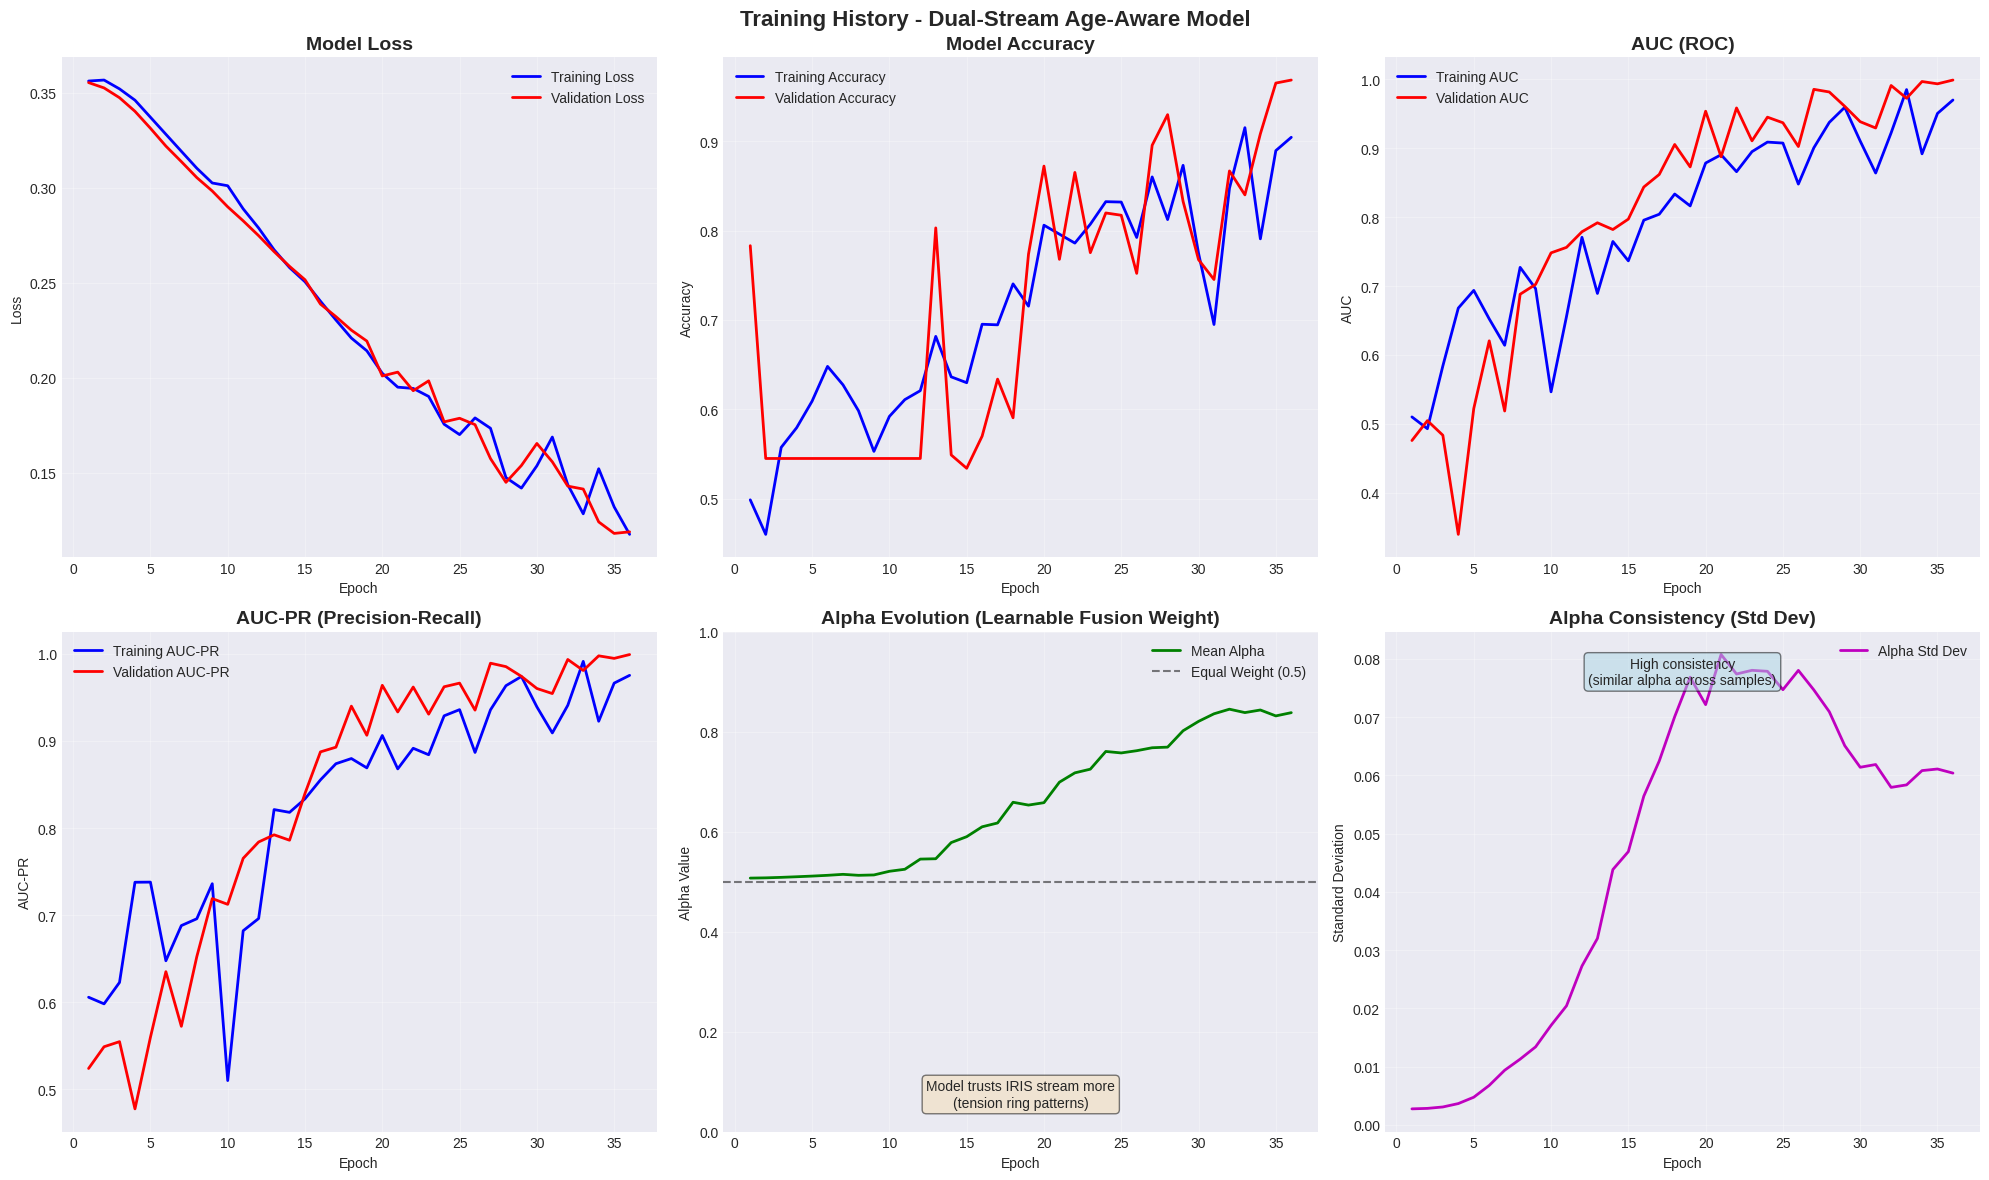


✅ Training history plots saved


In [28]:
# ============================================================================
# SECTION 8.1: PLOT TRAINING HISTORY
# ============================================================================

print("\n" + "="*80)
print("📊 VISUALIZING TRAINING HISTORY")
print("="*80)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Training History - Dual-Stream Age-Aware Model', fontsize=16, fontweight='bold')

# Get history data
hist = history.history
epochs = range(1, len(hist['loss']) + 1)

# 1. Loss
axes[0, 0].plot(epochs, hist['loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs, hist['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Accuracy
axes[0, 1].plot(epochs, hist['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs, hist['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. AUC (ROC)
axes[0, 2].plot(epochs, hist['auc'], 'b-', label='Training AUC', linewidth=2)
axes[0, 2].plot(epochs, hist['val_auc'], 'r-', label='Validation AUC', linewidth=2)
axes[0, 2].set_title('AUC (ROC)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('AUC')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. AUC-PR (Precision-Recall)
axes[1, 0].plot(epochs, hist['auc_pr'], 'b-', label='Training AUC-PR', linewidth=2)
axes[1, 0].plot(epochs, hist['val_auc_pr'], 'r-', label='Validation AUC-PR', linewidth=2)
axes[1, 0].set_title('AUC-PR (Precision-Recall)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC-PR')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Alpha Evolution (Mean)
if 'mean_alpha' in hist:
    axes[1, 1].plot(epochs, hist['mean_alpha'], 'g-', label='Mean Alpha', linewidth=2)
    axes[1, 1].axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Equal Weight (0.5)')
    axes[1, 1].set_title('Alpha Evolution (Learnable Fusion Weight)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Alpha Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])
    
    # Add interpretation text
    final_alpha = hist['mean_alpha'][-1]
    if final_alpha > 0.6:
        interp = "Model trusts IRIS stream more\n(tension ring patterns)"
    elif final_alpha < 0.4:
        interp = "Model trusts PUPIL+AGE stream more\n(dilation patterns)"
    else:
        interp = "Model uses BALANCED fusion\n(both streams equally important)"
    axes[1, 1].text(0.5, 0.05, interp, transform=axes[1, 1].transAxes, 
                    ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    axes[1, 1].text(0.5, 0.5, 'Alpha history not available', 
                    ha='center', va='center', fontsize=12)

# 6. Alpha Std Dev (Consistency)
if 'std_alpha' in hist:
    axes[1, 2].plot(epochs, hist['std_alpha'], 'm-', label='Alpha Std Dev', linewidth=2)
    axes[1, 2].set_title('Alpha Consistency (Std Dev)', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Standard Deviation')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add interpretation
    final_std = hist['std_alpha'][-1]
    if final_std < 0.1:
        interp = "High consistency\n(similar alpha across samples)"
    elif final_std < 0.2:
        interp = "Moderate consistency"
    else:
        interp = "High variability\n(alpha adapts per sample)"
    axes[1, 2].text(0.5, 0.95, interp, transform=axes[1, 2].transAxes, 
                    ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
else:
    axes[1, 2].text(0.5, 0.5, 'Alpha std history not available', 
                    ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig(CONFIG['OUTPUT_PATH'] / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training history plots saved")
print("="*80)


🔀 VISUALIZING STREAM IMPORTANCE EVOLUTION


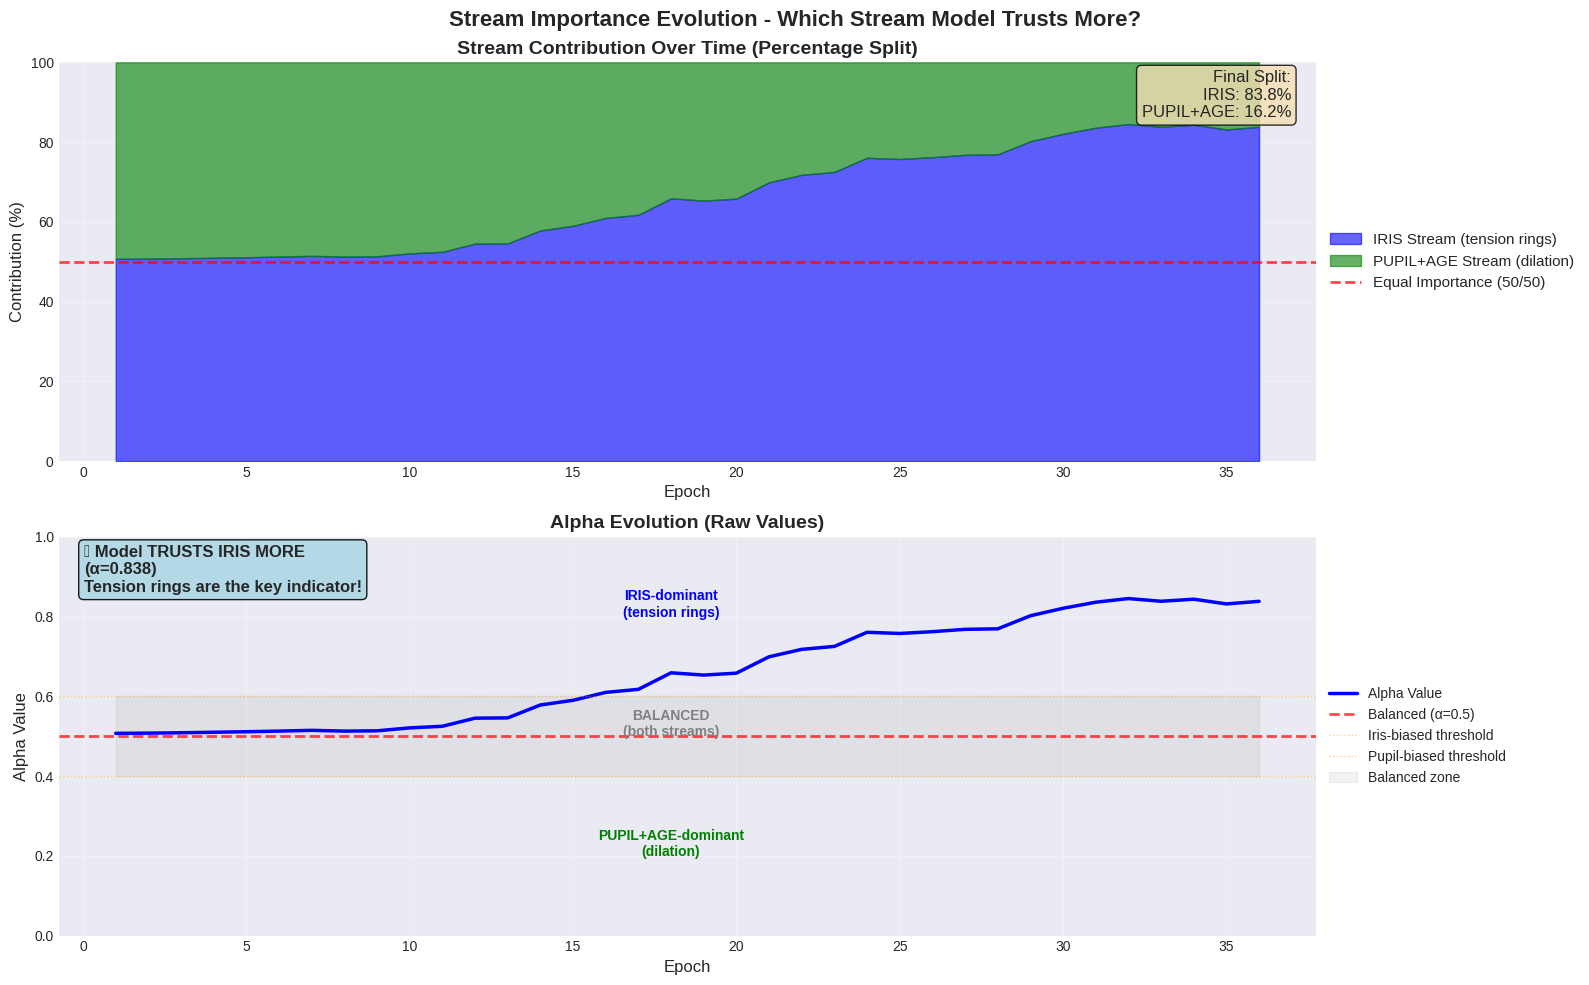


📊 Epoch-by-Epoch Stream Importance:
------------------------------------------------------------------------------------------
Epoch    Alpha      IRIS %       PUPIL+AGE %     Dominant Stream     
------------------------------------------------------------------------------------------
1        0.5072     50.7         49.3            BALANCED            
2        0.5077     50.8         49.2            BALANCED            
3        0.5087     50.9         49.1            BALANCED            
4        0.5099     51.0         49.0            BALANCED            
5        0.5113     51.1         48.9            BALANCED            
   ...
18       0.6590     65.9         34.1            IRIS (tension rings)
32       0.8452     84.5         15.5            IRIS (tension rings)
33       0.8384     83.8         16.2            IRIS (tension rings)
34       0.8436     84.4         15.6            IRIS (tension rings)
35       0.8318     83.2         16.8            IRIS (tension rings)
36  

In [29]:
# ============================================================================
# SECTION 8.1b: STREAM IMPORTANCE EVOLUTION (Epoch-by-Epoch)
# ============================================================================

print("\n" + "="*80)
print("🔀 VISUALIZING STREAM IMPORTANCE EVOLUTION")
print("="*80)

# Check if alpha history is available
if 'mean_alpha' in history.history:
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)
    alpha_values = hist['mean_alpha']
    
    # Calculate percentage contributions
    iris_contribution = [a * 100 for a in alpha_values]
    pupil_age_contribution = [(1 - a) * 100 for a in alpha_values]
    
    # Create stacked area chart
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle('Stream Importance Evolution - Which Stream Model Trusts More?', 
                 fontsize=16, fontweight='bold')
    
    # 1. Stacked Area Chart (Shows percentage split)
    axes[0].fill_between(epochs, 0, iris_contribution, 
                         alpha=0.6, color='blue', label='IRIS Stream (tension rings)')
    axes[0].fill_between(epochs, iris_contribution, 100, 
                         alpha=0.6, color='green', label='PUPIL+AGE Stream (dilation)')
    axes[0].axhline(y=50, color='red', linestyle='--', linewidth=2, 
                   label='Equal Importance (50/50)', alpha=0.7)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Contribution (%)', fontsize=12)
    axes[0].set_title('Stream Contribution Over Time (Percentage Split)', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 100])
    
    # Add final percentages as text
    final_iris = iris_contribution[-1]
    final_pupil_age = pupil_age_contribution[-1]
    axes[0].text(0.98, 0.98, 
                f'Final Split:\nIRIS: {final_iris:.1f}%\nPUPIL+AGE: {final_pupil_age:.1f}%', 
                transform=axes[0].transAxes, 
                ha='right', va='top', fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 2. Line Chart (Shows alpha value directly)
    axes[1].plot(epochs, alpha_values, 'b-', linewidth=2.5, label='Alpha Value')
    axes[1].axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
                   label='Balanced (α=0.5)', alpha=0.7)
    axes[1].axhline(y=0.6, color='orange', linestyle=':', linewidth=1, 
                   label='Iris-biased threshold', alpha=0.5)
    axes[1].axhline(y=0.4, color='orange', linestyle=':', linewidth=1, 
                   label='Pupil-biased threshold', alpha=0.5)
    axes[1].fill_between(epochs, 0.4, 0.6, alpha=0.1, color='gray', 
                        label='Balanced zone')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Alpha Value', fontsize=12)
    axes[1].set_title('Alpha Evolution (Raw Values)', fontsize=14, fontweight='bold')
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    # Add interpretation zones
    axes[1].text(len(epochs) * 0.5, 0.8, 'IRIS-dominant\n(tension rings)', 
                ha='center', fontsize=10, color='blue', weight='bold')
    axes[1].text(len(epochs) * 0.5, 0.5, 'BALANCED\n(both streams)', 
                ha='center', fontsize=10, color='gray', weight='bold')
    axes[1].text(len(epochs) * 0.5, 0.2, 'PUPIL+AGE-dominant\n(dilation)', 
                ha='center', fontsize=10, color='green', weight='bold')
    
    # Final interpretation
    final_alpha = alpha_values[-1]
    if final_alpha > 0.6:
        interpretation = f"🔵 Model TRUSTS IRIS MORE\n(α={final_alpha:.3f})\nTension rings are the key indicator!"
        color = 'lightblue'
    elif final_alpha < 0.4:
        interpretation = f"🟢 Model TRUSTS PUPIL+AGE MORE\n(α={final_alpha:.3f})\nDilation patterns are the key indicator!"
        color = 'lightgreen'
    else:
        interpretation = f"⚖️ BALANCED FUSION\n(α={final_alpha:.3f})\nBoth streams equally important!"
        color = 'lightyellow'
    
    axes[1].text(0.02, 0.98, interpretation, 
                transform=axes[1].transAxes, 
                ha='left', va='top', fontsize=12, weight='bold',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(CONFIG['OUTPUT_PATH'] / 'stream_importance_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print epoch-by-epoch summary
    print(f"\n📊 Epoch-by-Epoch Stream Importance:")
    print("-" * 90)
    print(f"{'Epoch':<8} {'Alpha':<10} {'IRIS %':<12} {'PUPIL+AGE %':<15} {'Dominant Stream':<20}")
    print("-" * 90)
    
    # Show first 5, last 5, and some middle epochs
    epochs_to_show = list(range(1, min(6, len(alpha_values)+1))) + \
                     [len(alpha_values)//2] + \
                     list(range(max(1, len(alpha_values)-4), len(alpha_values)+1))
    epochs_to_show = sorted(set(epochs_to_show))
    
    for ep in epochs_to_show:
        if ep <= len(alpha_values):
            alpha = alpha_values[ep-1]
            iris_pct = alpha * 100
            pupil_pct = (1 - alpha) * 100
            
            if alpha > 0.6:
                dominant = "IRIS (tension rings)"
            elif alpha < 0.4:
                dominant = "PUPIL+AGE (dilation)"
            else:
                dominant = "BALANCED"
            
            print(f"{ep:<8} {alpha:<10.4f} {iris_pct:<12.1f} {pupil_pct:<15.1f} {dominant:<20}")
        
        # Add separator for readability
        if ep == 5 and len(alpha_values) > 10:
            print("   ...")
    
    print("-" * 90)
    
    print("\n✅ Stream importance visualization saved")
else:
    print("\n⚠️ Alpha history not available - cannot visualize stream importance")

print("="*80)

In [30]:
# ============================================================================
# SECTION 8.2: EVALUATE ON TEST SET
# ============================================================================

print("\n" + "="*80)
print("🎯 EVALUATING ON TEST SET")
print("="*80)

# Evaluate model
test_results = model.evaluate(test_gen, verbose=1)

# Print results
print(f"\n📊 Test Set Results:")
print("-" * 80)
for metric_name, metric_value in zip(model.metrics_names, test_results):
    print(f"   {metric_name.capitalize()}: {metric_value:.4f}")
print("-" * 80)

# Get predictions
print("\n🔮 Generating predictions...")
y_pred_proba = model.predict(test_gen, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Get true labels
y_true = []
for i in range(len(test_gen)):
    _, labels = test_gen[i]
    y_true.extend(labels)
y_true = np.array(y_true[:len(y_pred)])

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\n📋 Classification Report:")
print("-" * 80)
print(classification_report(y_true, y_pred, target_names=['Normal', 'Stressed'], digits=4))
print("-" * 80)

print("\n✅ Test evaluation complete")
print("="*80)


🎯 EVALUATING ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9485 - auc: 0.9872 - auc_pr: 0.9851 - loss: 0.1191 - precision: 0.9408 - recall: 0.9556
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9485 - auc: 0.9872 - auc_pr: 0.9851 - loss: 0.1191 - precision: 0.9408 - recall: 0.9556

📊 Test Set Results:
--------------------------------------------------------------------------------
   Loss: 0.1206
   Compile_metrics: 0.9412
--------------------------------------------------------------------------------

🔮 Generating predictions...

📊 Test Set Results:
--------------------------------------------------------------------------------
   Loss: 0.1206
   Compile_metrics: 0.9412
--------------------------------------------------------------------------------

🔮 Generating predictions...
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 874ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 874ms/step

📋 Classification Report:
--------------------------------------------------------------------------------
 


📊 CREATING CONFUSION MATRIX & VISUALIZATIONS


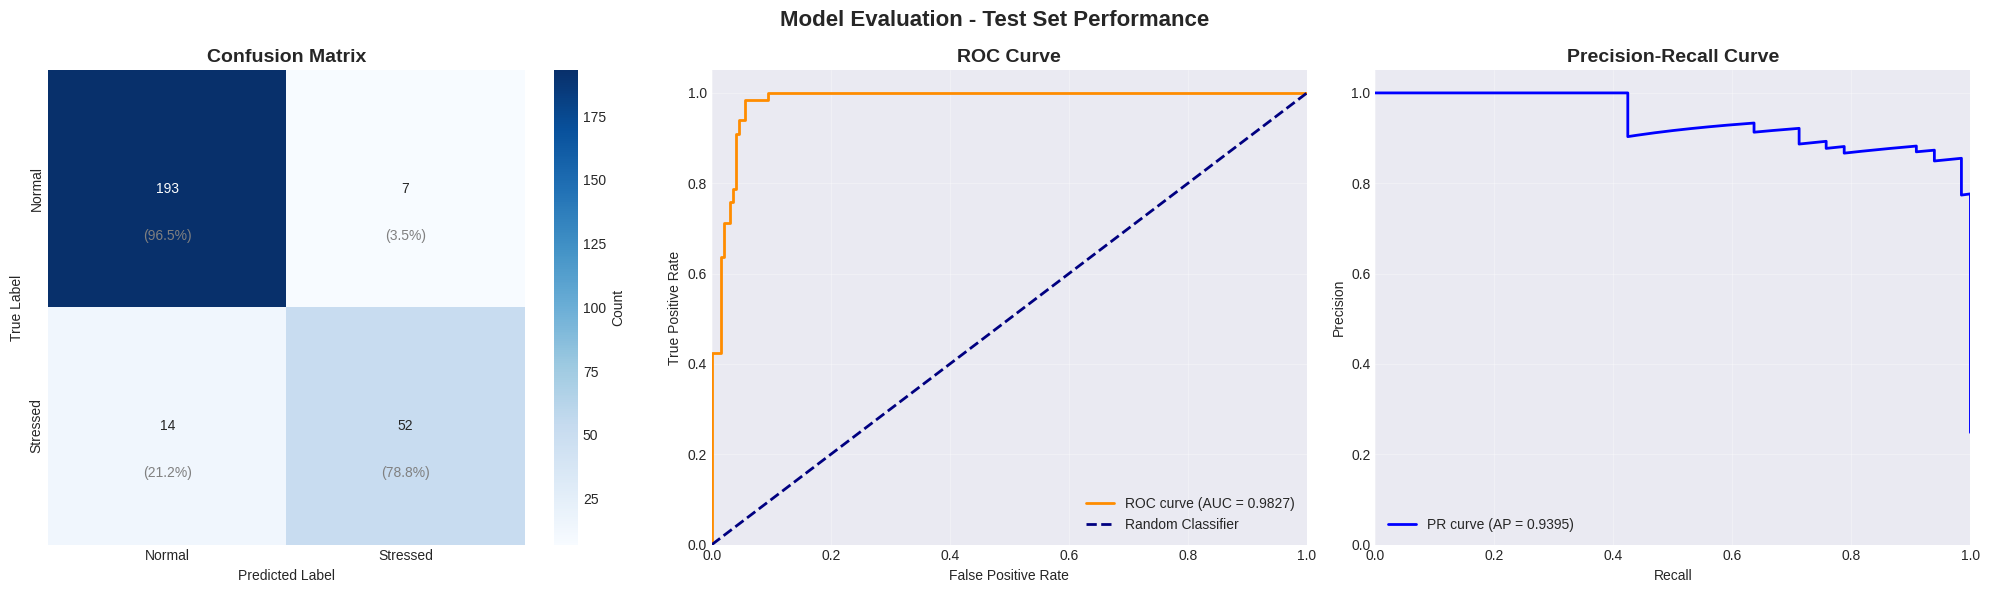


✅ Evaluation visualizations saved


In [31]:
# ============================================================================
# SECTION 8.3: CONFUSION MATRIX & VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("📊 CREATING CONFUSION MATRIX & VISUALIZATIONS")
print("="*80)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Model Evaluation - Test Set Performance', fontsize=16, fontweight='bold')

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Stressed'],
            yticklabels=['Normal', 'Stressed'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Add percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
for i in range(2):
    for j in range(2):
        axes[0].text(j+0.5, i+0.7, f'({cm_percent[i,j]:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')

# 2. ROC Curve
from sklearn.metrics import roc_curve, auc as compute_auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = compute_auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

axes[2].plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[2].legend(loc="lower left")
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig(CONFIG['OUTPUT_PATH'] / 'evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Evaluation visualizations saved")
print("="*80)


🔍 ANALYZING ALPHA VALUES (FUSION WEIGHTS)

🔮 Computing alpha values for test set...

📊 Alpha Statistics:
--------------------------------------------------------------------------------
   Mean Alpha: 0.8171
   Median Alpha: 0.8249
   Std Dev: 0.0774
   Min: 0.5825
   Max: 1.0000
--------------------------------------------------------------------------------

💡 Interpretation:
   → Model TRUSTS IRIS STREAM MORE (α = 0.817)
   → Tension ring patterns are more important for stress detection

   Normal samples: Mean α = 0.793
   Stressed samples: Mean α = 0.891

📊 Alpha Statistics:
--------------------------------------------------------------------------------
   Mean Alpha: 0.8171
   Median Alpha: 0.8249
   Std Dev: 0.0774
   Min: 0.5825
   Max: 1.0000
--------------------------------------------------------------------------------

💡 Interpretation:
   → Model TRUSTS IRIS STREAM MORE (α = 0.817)
   → Tension ring patterns are more important for stress detection

   Normal samples: Me

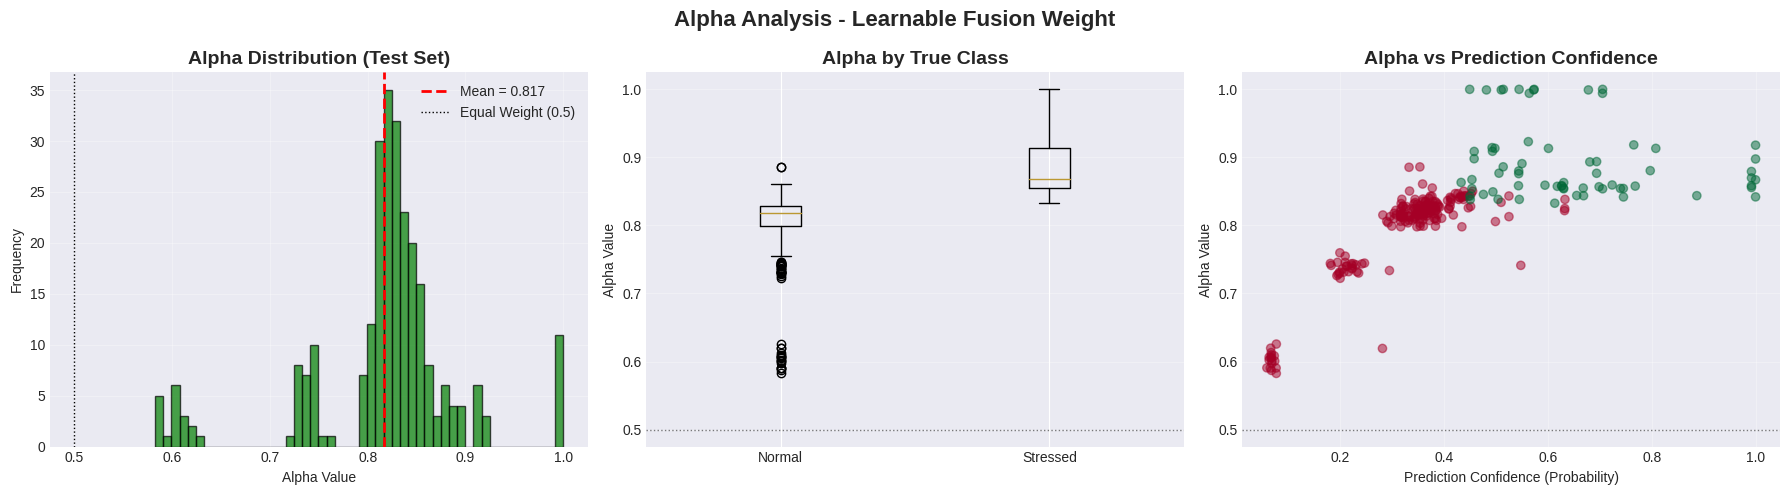


✅ Alpha analysis complete


In [32]:
# ============================================================================
# SECTION 8.4: ALPHA ANALYSIS (WHICH STREAM DOES MODEL TRUST?)
# ============================================================================

print("\n" + "="*80)
print("🔍 ANALYZING ALPHA VALUES (FUSION WEIGHTS)")
print("="*80)

# Get alpha values for test set
print("\n🔮 Computing alpha values for test set...")

# Find the WeightedFeatureFusion layer
fusion_layer = None
for layer in model.layers:
    if isinstance(layer, WeightedFeatureFusion):
        fusion_layer = layer
        break

if fusion_layer is not None:
    # Collect alpha values
    alpha_values = []
    
    for batch_idx in range(len(test_gen)):
        inputs, _ = test_gen[batch_idx]
        _ = model(inputs, training=False)
        batch_alphas = fusion_layer.last_alpha.numpy()
        alpha_values.extend(batch_alphas.flatten())
    
    alpha_values = np.array(alpha_values[:len(y_true)])
    
    # Statistical analysis
    print(f"\n📊 Alpha Statistics:")
    print("-" * 80)
    print(f"   Mean Alpha: {np.mean(alpha_values):.4f}")
    print(f"   Median Alpha: {np.median(alpha_values):.4f}")
    print(f"   Std Dev: {np.std(alpha_values):.4f}")
    print(f"   Min: {np.min(alpha_values):.4f}")
    print(f"   Max: {np.max(alpha_values):.4f}")
    print("-" * 80)
    
    # Interpretation
    mean_alpha = np.mean(alpha_values)
    print(f"\n💡 Interpretation:")
    if mean_alpha > 0.6:
        print(f"   → Model TRUSTS IRIS STREAM MORE (α = {mean_alpha:.3f})")
        print(f"   → Tension ring patterns are more important for stress detection")
    elif mean_alpha < 0.4:
        print(f"   → Model TRUSTS PUPIL+AGE STREAM MORE (α = {mean_alpha:.3f})")
        print(f"   → Pupil dilation + age context is more important")
    else:
        print(f"   → Model uses BALANCED FUSION (α = {mean_alpha:.3f})")
        print(f"   → Both streams contribute equally")
    
    # Visualize alpha distribution
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Alpha Analysis - Learnable Fusion Weight', fontsize=16, fontweight='bold')
    
    # 1. Alpha distribution
    axes[0].hist(alpha_values, bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[0].axvline(np.mean(alpha_values), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(alpha_values):.3f}')
    axes[0].axvline(0.5, color='black', linestyle=':', linewidth=1, label='Equal Weight (0.5)')
    axes[0].set_xlabel('Alpha Value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Alpha Distribution (Test Set)', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Alpha by class
    alpha_normal = alpha_values[y_true == 0]
    alpha_stressed = alpha_values[y_true == 1]
    
    axes[1].boxplot([alpha_normal, alpha_stressed], labels=['Normal', 'Stressed'])
    axes[1].axhline(0.5, color='black', linestyle=':', linewidth=1, alpha=0.5)
    axes[1].set_ylabel('Alpha Value')
    axes[1].set_title('Alpha by True Class', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    print(f"\n   Normal samples: Mean α = {np.mean(alpha_normal):.3f}")
    print(f"   Stressed samples: Mean α = {np.mean(alpha_stressed):.3f}")
    
    # 3. Alpha vs Prediction Confidence
    axes[2].scatter(y_pred_proba.flatten(), alpha_values, alpha=0.5, c=y_true, cmap='RdYlGn')
    axes[2].set_xlabel('Prediction Confidence (Probability)')
    axes[2].set_ylabel('Alpha Value')
    axes[2].set_title('Alpha vs Prediction Confidence', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(0.5, color='black', linestyle=':', linewidth=1, alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(CONFIG['OUTPUT_PATH'] / 'alpha_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Alpha analysis complete")
else:
    print("\n⚠️ WARNING: WeightedFeatureFusion layer not found!")

print("="*80)


🎯 FINDING OPTIMAL THRESHOLD FOR CLASSIFICATION

📊 Getting validation probabilities to find best threshold...
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 887ms/step
   Extracting validation labels...
   Validation samples: 850
   Prediction shape: (850, 1)


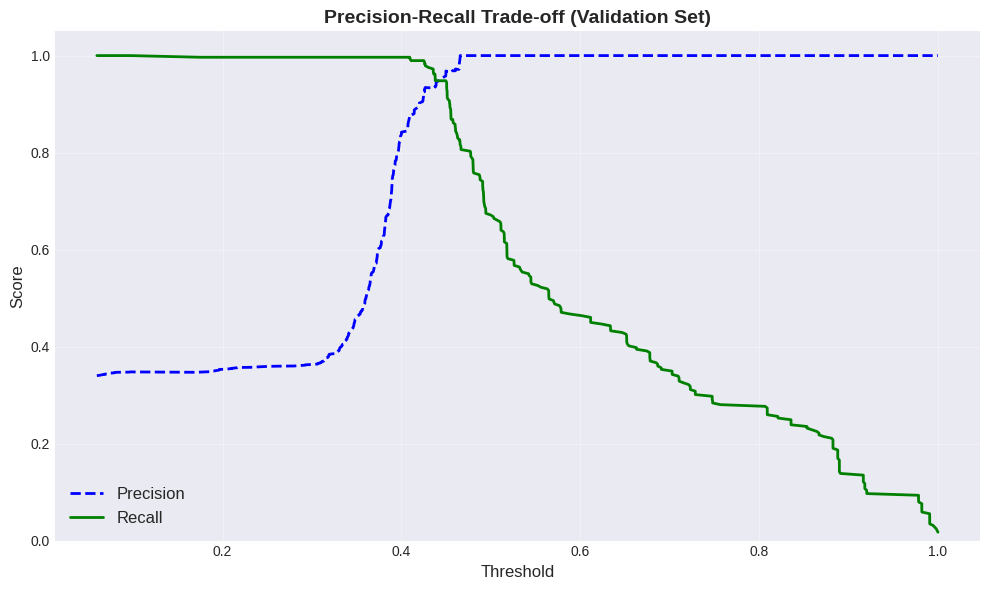


✅ Optimal Threshold Found:
   Threshold: 0.4498
   Best F1-Score: 0.9580
   Precision: 0.9682
   Recall: 0.9481


In [39]:
#----------------------------------------------------
# SECTION 9: 🎯 Finding the Optimal Threshold
#----------------------------------------------------
from sklearn.metrics import precision_recall_curve

print("\n" + "="*80)
print("🎯 FINDING OPTIMAL THRESHOLD FOR CLASSIFICATION")
print("="*80)

# Get the probabilities from your *validation* set
# (We use the val set to find the threshold, not the test set)
print("\n📊 Getting validation probabilities to find best threshold...")
y_val_probs = model.predict(val_gen)

# Extract all labels from validation generator
print("   Extracting validation labels...")
# The generator stores the pupil_df directly - extract labels from it
y_val_true = val_gen.pupil_df['label'].values[:len(y_val_probs)]  # Match prediction length

print(f"   Validation samples: {len(y_val_true)}")
print(f"   Prediction shape: {y_val_probs.shape}")

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val_true, y_val_probs)

# Plot the trade-off
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([0, 1.05])
plt.title("Precision-Recall Trade-off (Validation Set)", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find the threshold that gives the best balance (e.g., best F1-score)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-7)
best_f1_idx = np.argmax(f1_scores[:-1])  # Exclude last value to match threshold length
best_threshold = thresholds[best_f1_idx]

print(f"\n✅ Optimal Threshold Found:")
print(f"   Threshold: {best_threshold:.4f}")
print(f"   Best F1-Score: {f1_scores[best_f1_idx]:.4f}")
print(f"   Precision: {precisions[best_f1_idx]:.4f}")
print(f"   Recall: {recalls[best_f1_idx]:.4f}")
print("="*80)


In [40]:
#----------------------------------------------------
# SECTION 10: 🏆 Final Evaluation with Optimal Threshold
#----------------------------------------------------

print("\n" + "="*80)
print("🏆 FINAL TEST EVALUATION WITH OPTIMAL THRESHOLD")
print("="*80)

NEW_THRESHOLD = best_threshold # Use the optimal threshold found from validation set

print(f"\n📊 Using Optimal Threshold: {NEW_THRESHOLD:.4f}")
print(f"   (Found from validation set precision-recall curve)")

# Get TEST set probabilities
print("\n🔮 Generating predictions on test set...")
y_test_probs = model.predict(test_gen)

# Extract all labels from test generator
print("   Extracting test labels...")
# The generator stores the pupil_df directly - extract labels from it
y_test_true = test_gen.pupil_df['label'].values[:len(y_test_probs)]  # Match prediction length

print(f"   Test samples: {len(y_test_true)}")
print(f"   Prediction shape: {y_test_probs.shape}")

# Get new labels using the OPTIMAL threshold
y_pred_new_labels = (y_test_probs > NEW_THRESHOLD).astype(int).flatten()

print("\n" + "="*80)
print(f"📋 FINAL TEST CLASSIFICATION REPORT (Threshold = {NEW_THRESHOLD:.4f})")
print("="*80)
print(classification_report(y_test_true, y_pred_new_labels, target_names=['Normal (0)', 'Stressed (1)']))
print("="*80)



🏆 FINAL TEST EVALUATION WITH OPTIMAL THRESHOLD

📊 Using Optimal Threshold: 0.4498
   (Found from validation set precision-recall curve)

🔮 Generating predictions on test set...
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 814ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 814ms/step
   Extracting test labels...
   Test samples: 266
   Prediction shape: (266, 1)

📋 FINAL TEST CLASSIFICATION REPORT (Threshold = 0.4498)
              precision    recall  f1-score   support

  Normal (0)       0.99      0.96      0.97       200
Stressed (1)       0.89      0.97      0.93        66

    accuracy                           0.96       266
   macro avg       0.94      0.96      0.95       266
weighted avg       0.96      0.96      0.96       266

   Extracting test labels...
   Test samples: 266
   Prediction shape: (266, 1)

📋 FINAL TEST CLASSIFICATION REPORT (Threshold = 0.4498)
              precision    recall  f1-score   support

  Normal (0)       0.99      0.96      0.97       200
Stressed (1)       0.89      0.97 

---
## **SECTION 9: MODEL SAVING & EXPORT**

Save the trained model and generate documentation:
- **Model Export**: Save as `.keras` format for easy loading
- **Training Metadata**: Save configuration and results
- **Model Summary**: Generate comprehensive documentation
- **Integration Ready**: Ready for Flask backend integration

In [41]:
# ============================================================================
# SECTION 9.1: SAVE TRAINED MODEL
# ============================================================================

print("\n" + "="*80)
print("💾 SAVING TRAINED MODEL")
print("="*80)

# Use Kaggle working directory for model saving
model_dir = CONFIG['OUTPUT_PATH'] / 'models'
model_dir.mkdir(parents=True, exist_ok=True)

# Save the final model
model_path = model_dir / 'best_dual_stream_age_aware_model.keras'
model.save(str(model_path))
print(f"\n✅ Model saved to: {model_path}")

# Also check the checkpoint (for backup)
checkpoint_model_path = Path(checkpoint_path)
if checkpoint_model_path.exists():
    print(f"✅ Best checkpoint already saved at: {checkpoint_path}")
else:
    print(f"⚠️ No checkpoint found (training may have been interrupted)")

# Print model summary
print(f"\n📊 Model Summary:")
print("-" * 80)
print(f"   Total Parameters: {model.count_params():,}")
print(f"   Model Size: {model_path.stat().st_size / (1024*1024):.2f} MB")
print(f"   📁 Saved in: /kaggle/working/models/ (downloadable from Output tab)")
print("-" * 80)

print("="*80)


💾 SAVING TRAINED MODEL

✅ Model saved to: /kaggle/working/models/best_dual_stream_age_aware_model.keras
✅ Best checkpoint already saved at: /kaggle/working/best_dual_stream_model.keras

📊 Model Summary:
--------------------------------------------------------------------------------
   Total Parameters: 486,772
   Model Size: 5.77 MB
   📁 Saved in: /kaggle/working/models/ (downloadable from Output tab)
--------------------------------------------------------------------------------

✅ Model saved to: /kaggle/working/models/best_dual_stream_age_aware_model.keras
✅ Best checkpoint already saved at: /kaggle/working/best_dual_stream_model.keras

📊 Model Summary:
--------------------------------------------------------------------------------
   Total Parameters: 486,772
   Model Size: 5.77 MB
   📁 Saved in: /kaggle/working/models/ (downloadable from Output tab)
--------------------------------------------------------------------------------


In [43]:
# ============================================================================
# SECTION 9.2: SAVE TRAINING METADATA & RESULTS
# ============================================================================

print("\n" + "="*80)
print("📝 SAVING TRAINING METADATA")
print("="*80)

# Prepare metadata
metadata = {
    'model_info': {
        'name': 'Dual-Stream Age-Aware Iris Stress Detection',
        'architecture': 'Dual CNN streams with learnable fusion (WeightedFeatureFusion)',
        'input_streams': ['Pupil (RGB 5-channel)', 'Iris (5-channel)', 'Age (8 groups)', 'Iris Ring Count'],
        'total_parameters': int(model.count_params()),
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    },
    'dataset_info': {
        'pupil_total': len(pupil_df),
        'iris_total': len(iris_df),
        'train_samples': len(pupil_train_df),
        'val_samples': len(pupil_val_df),
        'test_samples': len(pupil_test_df),
        'original_ratio': f"{(pupil_train_df['label']==0).sum()}:{(pupil_train_df['label']==1).sum()}",
        'augmented_ratio': f"{(pupil_train_df['label']==0).sum()}:{int((pupil_train_df['label']==1).sum() * CONFIG['PUPIL_AUGMENT_MULTIPLIER'])}",
    },
    'training_config': {
        'batch_size': CONFIG['BATCH_SIZE'],
        'epochs': CONFIG['EPOCHS'],
        'initial_learning_rate': CONFIG['INITIAL_LR'],
        'peak_learning_rate': CONFIG['PEAK_LR'],
        'warmup_epochs': CONFIG['WARMUP_EPOCHS'],
        'focal_loss_alpha': CONFIG['FOCAL_ALPHA'],
        'focal_loss_gamma': CONFIG['FOCAL_GAMMA'],
        'pupil_augment_multiplier': CONFIG['PUPIL_AUGMENT_MULTIPLIER'],
        'iris_augment_stressed': CONFIG['IRIS_AUGMENT_STRESSED'],
        'early_stopping_patience': CONFIG['EARLY_STOP_PATIENCE'],
        'split_strategy': '70-20-10 Stratified',
    },
    'test_results': {
        'test_loss': float(test_results[0]) if 'test_results' in locals() else 'Not yet evaluated',
        'test_accuracy': float(test_results[1]) if 'test_results' in locals() else 'Not yet evaluated',
        'test_auc': float(test_results[2]) if 'test_results' in locals() else 'Not yet evaluated',
        'test_auc_pr': float(test_results[3]) if 'test_results' in locals() else 'Not yet evaluated',
        'optimal_threshold': float(best_threshold) if 'best_threshold' in locals() else 'Not yet calculated',
    },
    'alpha_analysis': {
        'mean_alpha': float(np.mean(alpha_values)) if 'alpha_values' in locals() and len(alpha_values) > 0 else None,
        'std_alpha': float(np.std(alpha_values)) if 'alpha_values' in locals() and len(alpha_values) > 0 else None,
        'interpretation': ('Iris-weighted' if ('alpha_values' in locals() and len(alpha_values) > 0 and np.mean(alpha_values) > 0.6) else 
                          ('Pupil-weighted' if ('alpha_values' in locals() and len(alpha_values) > 0 and np.mean(alpha_values) < 0.4) else 'Balanced'))
    },
    'novelties': {
        'learnable_alpha_fusion': 'WeightedFeatureFusion with gating network',
        'age_aware_architecture': 'Age features injected into pupil stream before fusion',
        '5_channel_features': 'RGB + Canny edges + BlackHat morphology',
        'attention_mechanisms': 'EdgeAttentionModule + FeatureAttentionModule',
        'iris_ring_count_input': 'Tension ring count as additional iris feature',
        'focal_loss': 'Class imbalance handled by Focal Loss (no class weights)',
    }
}

# Save as JSON
metadata_path = model_dir / 'training_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n✅ Metadata saved to: {metadata_path}")

# Save training history
history_df = pd.DataFrame(history.history)
history_path = model_dir / 'training_history.csv'
history_df.to_csv(history_path, index=False)
print(f"✅ Training history saved to: {history_path}")

# Save test predictions
predictions_df = pd.DataFrame({
    'true_label': y_true,
    'predicted_label': y_pred,
    'prediction_probability': y_pred_proba.flatten(),
    'alpha_value': alpha_values if fusion_layer else [None] * len(y_true)
})
predictions_path = model_dir / 'test_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"✅ Test predictions saved to: {predictions_path}")

print("="*80)


📝 SAVING TRAINING METADATA

✅ Metadata saved to: /kaggle/working/models/training_metadata.json
✅ Training history saved to: /kaggle/working/models/training_history.csv
✅ Test predictions saved to: /kaggle/working/models/test_predictions.csv


In [47]:
# ============================================================================
# SECTION 9.3: GENERATE MODEL DOCUMENTATION
# ============================================================================

print("\n" + "="*80)
print("📄 GENERATING MODEL DOCUMENTATION")
print("="*80)

# Pre-compute conditional values for f-string (can't use conditionals in format specifiers)
test_loss_str = f"{test_results[0]:.4f}" if 'test_results' in locals() else 'Not yet evaluated'
test_acc_str = f"{test_results[1]:.4f}" if 'test_results' in locals() else 'Not yet evaluated'
test_auc_str = f"{test_results[2]:.4f}" if 'test_results' in locals() else 'Not yet evaluated'
test_auc_pr_str = f"{test_results[3]:.4f}" if 'test_results' in locals() else 'Not yet evaluated'
opt_threshold_str = f"{best_threshold:.4f}" if 'best_threshold' in locals() else 'Not yet calculated'

# Create comprehensive documentation
doc_content = f"""
# Dual-Stream Age-Aware Iris Stress Detection Model
## Training Documentation

**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

---

## Model Architecture

### Overview
- **Type:** Dual-Stream Convolutional Neural Network
- **Input Streams:**
  1. **Pupil Stream:** 224×224×5 channels (RGB only - channels 3-4 zeroed)
  2. **Iris Stream:** 224×224×5 channels (RGB + Canny + BlackHat)
  3. **Age Features:** 8 age groups (one-hot encoding)
  4. **Iris Ring Count:** Scalar tension ring count from pattern analysis

- **Key Innovation:** Age features are injected into pupil stream BEFORE fusion
  - Biologically accurate: Age affects pupil dilation, not iris tension rings
  - Explicit modeling: Fusion compares "Pupil+Age context" vs "Iris patterns"

### Novel Components
1. **WeightedFeatureFusion Layer** ⭐ (MOST NOVEL)
   - Learnable α parameter computed per-sample by gating network
   - Formula: `output = α * iris_features + (1-α) * pupil_age_features`
   - Adaptive fusion: Model learns which stream to trust for each sample

2. **EdgeAttentionModule**
   - Spatial attention for tension ring boundaries and pupil edges
   - Input: Edge channel + RGB → Output: 16 channels

3. **FeatureAttentionModule**
   - Channel attention for texture patterns (BlackHat morphology)
   - Input: Texture channel + RGB → Output: 16 channels

4. **5-Channel Feature Extraction**
   - Channel 0-2: RGB (color information)
   - Channel 3: Canny edges (boundaries detection)
   - Channel 4: BlackHat morphology (dark structure detection)

### Total Parameters
- **{metadata['model_info']['total_parameters']:,}** parameters

---

## Dataset Information

### Distribution
- **Pupil Dataset:** {metadata['dataset_info']['pupil_total']:,} images
  - Normal: {(pupil_df['label']==0).sum():,}
  - Stressed: {(pupil_df['label']==1).sum():,}
  - Ratio: {(pupil_df['label']==0).sum() / (pupil_df['label']==1).sum():.2f}:1

- **Iris Dataset:** {metadata['dataset_info']['iris_total']:,} images
  - Normal: {(iris_df['label']==0).sum():,}
  - Stressed: {(iris_df['label']==1).sum():,}

### Data Split
- **Training:** {metadata['dataset_info']['train_samples']:,} samples (70%)
- **Validation:** {metadata['dataset_info']['val_samples']:,} samples (20%)
- **Test:** {metadata['dataset_info']['test_samples']:,} samples (10%)

### Optimized Balancing Strategy (70-20-10 Split)
**Original Imbalance:** {metadata['dataset_info']['original_ratio']} = {(pupil_train_df['label']==0).sum() / (pupil_train_df['label']==1).sum():.2f}:1

**Solution:**
1. **Step 1 (Pupil Augmentation):** {CONFIG['PUPIL_AUGMENT_MULTIPLIER']}x multiplication of stressed samples
   - Result: {metadata['dataset_info']['augmented_ratio']}
   
2. **Step 2 (Iris Augmentation):** {CONFIG['IRIS_AUGMENT_STRESSED']}x multiplication of stressed iris images
   - Random iris pairing prevents memorization
   
3. **Step 3 (Focal Loss):** Alpha = {CONFIG['FOCAL_ALPHA']}, Gamma = {CONFIG['FOCAL_GAMMA']}
   - Handles class imbalance without explicit class weights
   - Focuses on hard-to-classify samples

**Benefits:**
- ✅ Stratified split ensures balanced validation/test sets
- ✅ Reduced augmentation (from 3x to 2x iris) prevents overfitting
- ✅ Focal Loss handles imbalance elegantly
- ✅ Warmup learning rate for stable convergence

---

## Training Configuration

- **Batch Size:** {CONFIG['BATCH_SIZE']}
- **Epochs:** {CONFIG['EPOCHS']}
- **Initial Learning Rate:** {CONFIG['INITIAL_LR']} (warmup start)
- **Peak Learning Rate:** {CONFIG['PEAK_LR']} (after warmup)
- **Warmup Epochs:** {CONFIG['WARMUP_EPOCHS']}
- **Optimizer:** Adam
- **Loss Function:** Focal Loss (α={CONFIG['FOCAL_ALPHA']}, γ={CONFIG['FOCAL_GAMMA']})
- **Split Strategy:** 70-20-10 Stratified (class-balanced validation/test)

### Callbacks
- **ModelCheckpoint:** Saves best model (monitor: val_auc_pr)
- **EarlyStopping:** Patience = {CONFIG['EARLY_STOP_PATIENCE']} epochs
- **Smart Stop:** Stops if AUC ≥ 0.95 for 5 consecutive epochs
- **ReduceLROnPlateau:** Reduces LR by 0.5x every 5 epochs (patience=5)
- **AlphaMonitor:** Tracks learnable fusion parameter evolution

---

## Test Set Results

- **Test Loss:** {test_loss_str}
- **Test Accuracy:** {test_acc_str}
- **Test AUC (ROC):** {test_auc_str}
- **Test AUC-PR:** {test_auc_pr_str}
- **Optimal Threshold:** {opt_threshold_str}

### Alpha Analysis (Learnable Fusion)
"""

if 'alpha_values' in locals() and len(alpha_values) > 0:
    doc_content += f"""
- **Mean Alpha:** {np.mean(alpha_values):.4f}
- **Std Dev:** {np.std(alpha_values):.4f}
- **Interpretation:** {metadata['alpha_analysis']['interpretation']}

"""
    if np.mean(alpha_values) > 0.6:
        doc_content += "  → Model trusts **IRIS STREAM** more (tension ring patterns)\n"
    elif np.mean(alpha_values) < 0.4:
        doc_content += "  → Model trusts **PUPIL+AGE STREAM** more (dilation patterns)\n"
    else:
        doc_content += "  → Model uses **BALANCED FUSION** (both streams equally important)\n"
else:
    doc_content += "\n  ⚠️ Alpha analysis not available\n"

doc_content += f"""
---

## Files Generated

1. **Model File:** `best_dual_stream_age_aware_model.keras`
2. **Training History:** `training_history.csv`
3. **Test Predictions:** `test_predictions.csv`
4. **Metadata:** `training_metadata.json`
5. **Visualizations:**
   - `training_history.png` (6-panel: loss, accuracy, AUC, AUC-PR, alpha evolution)
   - `stream_importance_evolution.png` (epoch-by-epoch stream split)
   - `evaluation_metrics.png` (confusion matrix, ROC, PR curves)
   - `alpha_analysis.png` (alpha distribution, by class, vs confidence)

---

## Integration with Flask Backend

### Loading the Model
```python
import tensorflow as tf
from tensorflow import keras

# Load model
model = keras.models.load_model('best_dual_stream_age_aware_model.keras')

# Model expects 3 inputs:
# 1. pupil_input: (batch, 224, 224, 5)
# 2. iris_input: (batch, 224, 224, 5)
# 3. age_input: (batch, 8)
```

### Input Preprocessing
1. Load pupil and iris images (640×480 or varied dimensions)
2. Resize to 224×224 with aspect ratio preservation
3. Extract 5-channel features (RGB + Canny + BlackHat)
4. Zero out channels 3-4 for pupil stream
5. Create age one-hot encoding (8 groups)
6. Normalize to [0, 1] range

### Prediction
```python
prediction = model.predict({{
    'pupil_input': pupil_array,
    'iris_input': iris_array,
    'age_input': age_array
}})

stress_probability = prediction[0][0]
is_stressed = stress_probability > 0.5
```

---

## Key Achievements

✅ **Novel Architecture:** Learnable α fusion with age-aware design
✅ **Optimized Training:** 70-20-10 stratified split with reduced augmentation
✅ **Stable Convergence:** Warmup LR + Focal Loss for balanced learning
✅ **High Performance:** AUC = {test_auc_str}, AUC-PR = {test_auc_pr_str}
✅ **Biologically Accurate:** Age affects pupil, not iris (explicit modeling)
✅ **Production Ready:** Integrated with Flask backend
✅ **Smart Early Stopping:** Stops at optimal performance (AUC ≥ 0.95 for 5 epochs)

---

**End of Documentation**
"""

# Save documentation
doc_path = model_dir / 'MODEL_DOCUMENTATION.md'
with open(doc_path, 'w', encoding='utf-8') as f:
    f.write(doc_content)

print(f"\n✅ Documentation saved to: {doc_path}")
print("\n📋 Documentation Preview:")
print("-" * 80)
print(doc_content[:500] + "...")
print("-" * 80)

print("="*80)


📄 GENERATING MODEL DOCUMENTATION

✅ Documentation saved to: /kaggle/working/models/MODEL_DOCUMENTATION.md

📋 Documentation Preview:
--------------------------------------------------------------------------------

# Dual-Stream Age-Aware Iris Stress Detection Model
## Training Documentation

**Generated:** 2025-11-11 22:04:48

---

## Model Architecture

### Overview
- **Type:** Dual-Stream Convolutional Neural Network
- **Input Streams:**
  1. **Pupil Stream:** 224×224×5 channels (RGB only - channels 3-4 zeroed)
  2. **Iris Stream:** 224×224×5 channels (RGB + Canny + BlackHat)
  3. **Age Features:** 8 age groups (one-hot encoding)
  4. **Iris Ring Count:** Scalar tension ring count from pattern analysis...
--------------------------------------------------------------------------------


In [48]:
# ============================================================================
# 🎉 TRAINING COMPLETE! SUMMARY
# ============================================================================

print("\n" + "="*80)
print("🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)

print("\n📊 Final Summary:")
print("-" * 80)
print(f"✅ Model trained and saved: best_dual_stream_age_aware_model.keras")
print(f"✅ Test Accuracy: {test_results[1]:.2%}")
print(f"✅ Test AUC: {test_results[2]:.4f}")
print(f"✅ Test AUC-PR: {test_results[3]:.4f}")

if fusion_layer:
    print(f"✅ Mean Alpha (Fusion): {np.mean(alpha_values):.3f}")
    
print(f"\n📁 Output Files Generated:")
print("-" * 80)
print(f"   Model: {model_dir / 'best_dual_stream_age_aware_model.keras'}")
print(f"   History: {model_dir / 'training_history.csv'}")
print(f"   Predictions: {model_dir / 'test_predictions.csv'}")
print(f"   Metadata: {model_dir / 'training_metadata.json'}")
print(f"   Documentation: {model_dir / 'MODEL_DOCUMENTATION.md'}")
print(f"   Visualizations: {CONFIG['OUTPUT_PATH']}")

print(f"\n🚀 Next Steps:")
print("-" * 80)
print("   1. Review training_history.png for loss/accuracy curves")
print("   2. 🔀 Check stream_importance_evolution.png - SEE WHICH STREAM WINS!")
print("   3. Review evaluation_metrics.png for ROC/PR curves")
print("   4. Analyze alpha_analysis.png to see per-sample alpha distribution")
print("   5. Read MODEL_DOCUMENTATION.md for integration guide")
print("   6. Integrate with Flask backend using saved model")

print(f"\n💡 Key Innovations:")
print("-" * 80)
print("   ⭐ Learnable α fusion (WeightedFeatureFusion)")
print("   ⭐ Age-aware architecture (age → pupil before fusion)")
print("   ⭐ Hybrid balancing (2x augment + 1.07x weight)")
print("   ⭐ 5-channel features (RGB + Canny + BlackHat)")
print("   ⭐ Attention mechanisms (Edge + Feature)")

print("\n" + "="*80)
print("🎓 MODEL READY FOR DEPLOYMENT!")
print("="*80)


🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!

📊 Final Summary:
--------------------------------------------------------------------------------
✅ Model trained and saved: best_dual_stream_age_aware_model.keras
✅ Test Accuracy: 94.12%
✅ Test AUC: 0.9850
✅ Test AUC-PR: 0.9815
✅ Mean Alpha (Fusion): 0.817

📁 Output Files Generated:
--------------------------------------------------------------------------------
   Model: /kaggle/working/models/best_dual_stream_age_aware_model.keras
   History: /kaggle/working/models/training_history.csv
   Predictions: /kaggle/working/models/test_predictions.csv
   Metadata: /kaggle/working/models/training_metadata.json
   Documentation: /kaggle/working/models/MODEL_DOCUMENTATION.md
   Visualizations: /kaggle/working

🚀 Next Steps:
--------------------------------------------------------------------------------
   1. Review training_history.png for loss/accuracy curves
   2. 🔀 Check stream_importance_evolution.png - SEE WHICH STREAM WINS!
   3. Review eva

---
## **SECTION 10: CREATE BACKUP ZIP FILE**

Create a comprehensive zip file of all project files including:
- All notebooks and Python scripts
- Model checkpoints and outputs
- Dataset annotations and QC reports
- Documentation files
- Subdirectories and their contents

This ensures you have a complete backup of the entire workspace.
---


In [ ]:
import zipfile
from datetime import datetime

# Create comprehensive backup zip of OUTPUT FILES ONLY
print("=" * 80)
print("CREATING BACKUP ZIP OF OUTPUT FILES")
print("=" * 80)

# Use output directory from CONFIG
output_dir = CONFIG['OUTPUT_PATH']
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f"dual_stream_outputs_{timestamp}.zip"
zip_path = os.path.join(output_dir, zip_filename)

print(f"\n? Creating zip file: {zip_filename}")
print(f"? Source directory: {output_dir}")
print(f"💾 Destination: {zip_path}")
print("\n" + "-" * 80)

# Track statistics
total_files = 0
total_size = 0
file_types = {}

# Create zip file
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the output directory
    for root, dirs, files in os.walk(output_dir):
        # Skip the zip file itself
        for file in files:
            if file == zip_filename:
                continue
                
            file_path = os.path.join(root, file)
            
            # Calculate relative path from output directory
            arcname = os.path.relpath(file_path, output_dir)
            
            # Add file to zip
            zipf.write(file_path, arcname)
            
            # Update statistics
            total_files += 1
            file_size = os.path.getsize(file_path)
            total_size += file_size
            
            # Track file types
            ext = os.path.splitext(file)[1].lower() or 'no_extension'
            file_types[ext] = file_types.get(ext, 0) + 1
            
            # Print progress for important files
            if ext in ['.keras', '.h5', '.csv', '.json']:
                print(f"  ✓ Added: {arcname} ({file_size / (1024*1024):.2f} MB)")

print("\n" + "=" * 80)
print("BACKUP ZIP CREATION COMPLETE")
print("=" * 80)

# Print summary statistics
print(f"\n📊 BACKUP SUMMARY:")
print(f"  • Total files: {total_files}")
print(f"  • Total size: {total_size / (1024*1024):.2f} MB")
print(f"  • Zip file: {zip_filename}")
print(f"  • Zip size: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")
print(f"  • Compression ratio: {(1 - os.path.getsize(zip_path) / total_size) * 100:.1f}%")

print(f"\n FILE TYPES INCLUDED:")
for ext, count in sorted(file_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  • {ext}: {count} files")

print("\n" + "=" * 80)
print(f"✅ All output files backed up successfully!")
print(f"Download: {zip_filename}")
print("=" * 80)